# Advent of code 2022

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2022/advent_of_code_2022.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2022/advent_of_code_2022.ipynb)
with Python solutions to the
[2022 Advent of Code puzzles](https://adventofcode.com/2022),
completed in December 2022,
by [Hugues Hoppe](https://hhoppe.com/).

See [reddit](https://www.reddit.com/r/adventofcode/comments/108taz7/2022_advent_notebook_with_gif_visualizations/).

The notebook presents both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 25 puzzles is less than 1 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)

Here are some visualization results (obtained by setting `SHOW_BIG_MEDIA = True`):

<p>
<a href="#day8">day8</a> <img src="results/day08e.gif" width="240">&emsp;
<a href="#day9">day9</a> <img src="results/day09b.gif" width="160">&emsp;
<a href="#day12">day12</a> <img src="results/day12c.gif" width="300">
</p>

<p>
<a href="#day14">day14</a> <img src="results/day14.gif" width="130">&emsp;
<a href="#day15">day15</a> <img src="results/day15b.gif" width="180">&emsp;
<a href="#day16">day16</a> <img src="results/day16b.gif" width="320">
</p>

<p>
<a href="#day17">day17</a> <img src="results/day17.gif" width="200">&emsp;
<a href="#day18">day18</a> <img src="results/day18a.gif" width="80">
<img src="results/day18c.gif" width="100">&emsp;
<a href="#day21">day21</a> <img src="results/day21b.png" width="300">
</p>

<p>
<a href="#day22">day22</a> <img src="results/day22.gif" width="160">&emsp;
<a href="#day23">day23</a> <img src="results/day23.gif" width="156">&emsp;
<a href="#day24">day24</a> <img src="results/day24a.gif" width="30">&nbsp;
<img src="results/day24c.gif" width="306">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null  # For mediapy.

In [2]:
!dpkg -l | grep -q libgraphviz-dev || (apt-get -qq update && apt-get -qq -y install libgraphviz-dev) >/dev/null  # https://stackoverflow.com/a/66380001

In [3]:
!pip install -q advent-of-code-hhoppe advent-of-code-ocr hhoppe-tools kaleido \
  matplotlib mediapy more-itertools networkx numba numpy plotly pygraphviz resampler scipy

In [4]:
import ast
import collections
from collections.abc import Callable
import dataclasses
import functools
import heapq
import importlib
import itertools
import math
import operator
import pathlib
import re
import string
import subprocess
import textwrap
from typing import Any, NamedTuple

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import advent_of_code_ocr  # https://github.com/bsoyka/advent-of-code-ocr/blob/main/advent_of_code_ocr/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import matplotlib.pyplot as plt
import mediapy as media  # https://github.com/google/mediapy/blob/main/mediapy/__init__.py
import more_itertools
import networkx
import numba
import numpy as np
import plotly
import plotly.graph_objects as go
import resampler  # https://github.com/hhoppe/resampler/
import scipy.ndimage
import scipy.signal

In [5]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [6]:
if pathlib.Path('results').is_dir():
  media.set_show_save_dir('results')

In [7]:
hh.start_timing_notebook_cells()

In [8]:
YEAR = 2022
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
SHOW_BIG_MEDIA = hh.get_env_bool('SHOW_BIG_MEDIA')
# echo 53616... >~/.config/aocd/token  # session cookie from "adventofcode.com" (valid 1 month).

In [9]:
TAR_URL = f'https://github.com/hhoppe/advent_of_code/raw/main/{YEAR}/data/{PROFILE}.tar.gz'
advent = advent_of_code_hhoppe.Advent(year=YEAR, tar_url=TAR_URL)

In [10]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [11]:
check_eq = hh.check_eq

In [12]:
def hex_color(r: float, g: float, b: float) -> str:
  """Return an HTML color code from RGB values in the range [0.0, 1.0]."""
  assert all(0.0 <= c <= 1.0 for c in (r, g, b))
  return '#' + ''.join(format(round(c * 255.0), '02x') for c in (r, g, b))


def color_from_hex(s: str) -> tuple[float, float, float]:
  """Return an RGB tuple in [0.0, 1.0]^3 from a hex color, e.g. '#FF4080'."""
  assert len(s) == 7 and s[0] == '#', s
  return tuple(int(s2, 16) / 255 for s2 in more_itertools.sliced(s[1:], 2))  # type: ignore


assert hex_color(0.0, 0.5, 1.0) == '#0080ff'
assert color_from_hex('#0000ff') == (0.0, 0.0, 1.0)

In [13]:
_ORIGINAL_GLOBALS = list(globals())

<a name="day1"></a>
## Day 1: Sums of subsequences

- Part 1: Find the Elf carrying the most Calories. How many total Calories is that Elf carrying?

- Part 2: Find the top three Elves carrying the most Calories. How many Calories are those Elves carrying in total?

---

This problem was straightforward.

In [14]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2022/day/1), `puzzle.input` has 2_269 lines:

3264
4043
2537
3319
2485
3218
5611
1753
 ...
5762
4989
6438
1020


The stored answers are: `{1: '72070', 2: '211805'}`

In [15]:
s1 = """\
1000
2000
3000

4000

5000
6000

7000
8000
9000

10000
"""

In [16]:
def day1a(s, *, part2=False):
  groups = s.split('\n\n')
  sums = [sum(int(s2) for s2 in group.splitlines()) for group in groups]
  return sum(sorted(sums)[-3:]) if part2 else max(sums)


check_eq(day1a(s1), 24_000)
puzzle.verify(1, day1a)

day1a_part2 = functools.partial(day1a, part2=True)
check_eq(day1a_part2(s1), 45_000)
puzzle.verify(2, day1a_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


In [17]:
# Theoretically faster using a heap rather than full sort.
def day1(s, *, part2=False):
  groups = s.split('\n\n')
  sums = [sum(int(s2) for s2 in group.splitlines()) for group in groups]
  return sum(heapq.nlargest(3, sums)) if part2 else max(sums)


check_eq(day1(s1), 24_000)
puzzle.verify(1, day1)

day1_part2 = functools.partial(day1, part2=True)
check_eq(day1_part2(s1), 45_000)
puzzle.verify(2, day1_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day2"></a>
## Day 2: Rock paper scissors

- Part 1: What would your total score be if everything goes exactly according to your strategy guide?

- Part 2: Following the Elf's instructions for the second column, what would your total score be if everything goes exactly according to your strategy guide?

---

- `day2a()`: The first approach uses dictionaries to encode all the outcomes and scores.

- `day2()`: These mappings can be more concisely encoded using modulo-3 arithmetic, for a very compact solution.

In [18]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2022/day/2), `puzzle.input` has 2_500 lines:

B Z
B Z
B Y
C Y
B Y
C Y
C Y
A Z
 ...
C Y
B Z
A Y
C Y


The stored answers are: `{1: '13005', 2: '11373'}`

In [19]:
s1 = """\
A Y
B X
C Z
"""

In [20]:
def day2a(s, *, part2=False):  # Initial code, using dicts.
  total = 0
  for line in s.splitlines():
    ch1, ch2 = line.split()
    if not part2:
      outcome = {'AX': 3, 'AY': 6, 'AZ': 0, 'BX': 0, 'BY': 3, 'BZ': 6, 'CX': 6, 'CY': 0, 'CZ': 3}[
          ch1 + ch2
      ]
      score = {'X': 1, 'Y': 2, 'Z': 3}[ch2]
    else:
      outcome = {'X': 0, 'Y': 3, 'Z': 6}[ch2]
      score = {
          'X': {'A': 3, 'B': 1, 'C': 2},  # lose
          'Y': {'A': 1, 'B': 2, 'C': 3},  # draw
          'Z': {'A': 2, 'B': 3, 'C': 1},  # win
      }[ch2][ch1]
    total += outcome + score

  return total


check_eq(day2a(s1), 15)
puzzle.verify(1, day2a)

day2a_part2 = functools.partial(day2a, part2=True)
check_eq(day2a_part2(s1), 12)
puzzle.verify(2, day2a_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


In [21]:
def day2(s, *, part2=False):  # Using modulo arithmetic.
  total = 0
  for line in s.splitlines():
    i, j = ord(line[0]) - ord('A'), ord(line[2]) - ord('X')
    total += j * 3 + (i + j + 2) % 3 + 1 if part2 else (j - i + 1) % 3 * 3 + j + 1
  return total


check_eq(day2(s1), 15)
puzzle.verify(1, day2)

day2_part2 = functools.partial(day2, part2=True)
check_eq(day2_part2(s1), 12)
puzzle.verify(2, day2_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day3"></a>
## Day 3: Intersections of groups

- Part 1: Find the item type that appears in both compartments of each rucksack. What is the sum of the priorities of those item types?

- Part 2: Find the item type that corresponds to the badges of each three-Elf group. What is the sum of the priorities of those item types?

---

For this problem, it is convenient to use the Python `set` data structure.

In [22]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2022/day/3), `puzzle.input` has 300 lines:

sfDRhjhHsHhgWPJvPmmQnmPqnW
pTddGVwcpMTTCdnQJqqQqqqVtVms
MdZCZGdcrCNRFZRhFssL
CttWnSnNfSnCHsWrTlTPPpPCTRrLpl
DgqqghjqJBVgDMTPGVlRGwbfLLGP
cgqBBhjqcBdMcWQcQNnNzsfv
lnDWMgTLlTFlHHgDDgngWFnlBWNcBQrdjcrrdQrPBrdjhWhj
JqSVRRVmmRqJJbZGGJqJvbmBNcjPNQNssQPhSSdwPwwwQr
 ...
JCWWRWCrLDDdBdLsSsLLSCrCNZMVcmMZMFwMZwNZPZVGFPmr
hhPzDzPhPNbfpzhBbdNbDhttzqWtwttHWwntjqmwmWFm
LgGZSdMMrgTLrZLdgLSgsGTFFjrWtFFmmmFtWjqHFnFtjn
vZgdLvZLZQLRQZQQdMZLdQvVpRhNNPfJDbcBbbhVNJNNhf


The stored answers are: `{1: '8053', 2: '2425'}`

In [23]:
# spellcheck=off
s1 = """\
vJrwpWtwJgWrhcsFMMfFFhFp
jqHRNqRjqzjGDLGLrsFMfFZSrLrFZsSL
PmmdzqPrVvPwwTWBwg
wMqvLMZHhHMvwLHjbvcjnnSBnvTQFn
ttgJtRGJQctTZtZT
CrZsJsPPZsGzwwsLwLmpwMDw
"""
# spellcheck=on

In [24]:
def day3a(s, *, part2=False):  # Initial code, containing some redundancy.
  total = 0
  if not part2:
    for line in s.splitlines():
      n = len(line) // 2
      (ch,) = set(line[:n]) & set(line[n:])
      total += ord(ch) - (ord('a') - 1 if ch.islower() else ord('A') - 27)
  else:
    for line0, line1, line2 in more_itertools.chunked(s.splitlines(), 3):
      (ch,) = set(line0) & set(line1) & set(line2)
      total += ord(ch) - (ord('a') - 1 if ch.islower() else ord('A') - 27)
  return total


check_eq(day3a(s1), 157)
puzzle.verify(1, day3a)

day3a_part2 = functools.partial(day3a, part2=True)
check_eq(day3a_part2(s1), 70)
puzzle.verify(2, day3a_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


In [25]:
def day3b(s, *, part2=False):  # Using a generator.
  def get_groups(lines):
    if not part2:
      for line in lines:
        n = len(line) // 2
        yield line[:n], line[n:]
    else:
      yield from more_itertools.chunked(lines, 3)

  total = 0
  for groups in get_groups(s.splitlines()):
    (ch,) = set.intersection(*map(set, groups))
    total += ord(ch) - (ord('a') - 1 if ch.islower() else ord('A') - 27)  # type: ignore
  return total


check_eq(day3b(s1), 157)
puzzle.verify(1, day3b)

day3b_part2 = functools.partial(day3b, part2=True)
check_eq(day3b_part2(s1), 70)
puzzle.verify(2, day3b_part2)

(Part 1: 0.001 s)
(Part 2: 0.000 s)


In [26]:
def day3(s, *, part2=False):  # Prettiest code.
  def score(*groups):
    (ch,) = set.intersection(*map(set, groups))
    return string.ascii_letters.index(ch) + 1  # type: ignore[arg-type]

  lines = s.splitlines()
  if not part2:
    return sum(score(line[: len(line) // 2], line[len(line) // 2 :]) for line in lines)
  return sum(score(*lines3) for lines3 in more_itertools.chunked(lines, 3))


check_eq(day3(s1), 157)
puzzle.verify(1, day3)

day3_part2 = functools.partial(day3, part2=True)
check_eq(day3_part2(s1), 70)
puzzle.verify(2, day3_part2)

(Part 1: 0.001 s)
(Part 2: 0.000 s)


<a name="day4"></a>
## Day 4: Overlaps of 1D intervals

- Part 1: In how many assignment pairs does one range fully contain the other?

- Part 2: In how many assignment pairs do the ranges overlap?

---

We explore several schemes:

- `day4a()`, `day4b()`: A brute-force `set` solution, which in principle should be slow,
  but not for this small problem.

- `day4c()`: A call to the `perl` command-line tool, which is surprisingly compact thanks to its
  command-line flags: `-lane` which enables **l**ine processing, **a**uto splitting into fields `@F`,
  **n**on-printing loop over lines, and **e**valuation of the next command-line argument.

- `day4()`: A straightforward efficient solution using inequality tests for intervals.

In [27]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2022/day/4), `puzzle.input` has 1_000 lines:

15-60,14-59
32-80,17-79
47-80,79-80
64-64,12-63
93-93,8-92
35-41,34-41
7-52,7-8
28-95,28-94
 ...
44-95,43-94
61-68,9-62
27-55,28-48
22-88,20-23


The stored answers are: `{1: '466', 2: '865'}`

In [28]:
s1 = """\
2-4,6-8
2-3,4-5
5-7,7-9
2-8,3-7
6-6,4-6
2-6,4-8
"""

In [29]:
def day4a(s, *, part2=False):  # Using sets.
  count = 0
  for line in s.splitlines():
    a, b = (
        set(range(i, j + 1)) for pair in line.split(',') for i, j in (map(int, pair.split('-')),)
    )
    count += bool(a & b) if part2 else a <= b or a >= b
  return count


check_eq(day4a(s1), 2)
puzzle.verify(1, day4a)

day4a_part2 = functools.partial(day4a, part2=True)
check_eq(day4a_part2(s1), 4)
puzzle.verify(2, day4a_part2)

(Part 1: 0.002 s)
(Part 2: 0.002 s)


In [30]:
def day4b(s, *, part2=False):  # Using sets, with only comprehensions.
  return sum(
      bool(a & b) if part2 else a <= b or a >= b
      for line in s.splitlines()
      for a, b in (
          (
              set(range(i, j + 1))
              for pair in line.split(',')
              for i, j in (map(int, pair.split('-')),)
          ),
      )
  )


check_eq(day4b(s1), 2)
puzzle.verify(1, day4b)

day4b_part2 = functools.partial(day4b, part2=True)
check_eq(day4b_part2(s1), 4)
puzzle.verify(2, day4b_part2)

(Part 1: 0.002 s)
(Part 2: 0.002 s)


In [31]:
def _run_in_shell(command: list[str], s: str) -> str:
  return subprocess.run(
      command, shell=False, check=True, encoding='utf-8', input=s, capture_output=True
  ).stdout

In [32]:
def day4c(s, *, part2=False):  # Using Perl.
  # part1_command = r"""
  #   perl -F'\D' -lane '$n += $F[0] <= $F[2] && $F[1] >= $F[3] ||
  #       $F[2] <= $F[0] && $F[3] >= $F[1]; END {print $n}'
  # """
  # part2_command = r"""
  #   perl -F'\D' -lane '$n += $F[1] >= $F[2] && $F[3] >= $F[0]; END {print $n}'
  # """
  p1 = '$n += $F[0] <= $F[2] && $F[1] >= $F[3] || $F[2] <= $F[0] && $F[3] >= $F[1]; END {print $n}'
  p2 = '$n += $F[1] >= $F[2] && $F[3] >= $F[0]; END {print $n}'
  command = ['perl', r'-F\D', '-lane', (p2 if part2 else p1)]
  return int(_run_in_shell(command, s))


check_eq(day4c(s1), 2)
puzzle.verify(1, day4c)

day4c_part2 = functools.partial(day4c, part2=True)
check_eq(day4c_part2(s1), 4)
puzzle.verify(2, day4c_part2)

(Part 1: 0.008 s)
(Part 2: 0.008 s)


In [33]:
def day4(s, *, part2=False):  # Straightforward and fast.
  count = 0
  for line in s.splitlines():
    a, b = (tuple(map(int, pair.split('-'))) for pair in line.split(','))
    overlaps = max(a[0], b[0]) <= min(a[1], b[1])
    contained = (a[0] <= b[0] and a[1] >= b[1]) or (b[0] <= a[0] and b[1] >= a[1])
    count += overlaps if part2 else contained
  return count


check_eq(day4(s1), 2)
puzzle.verify(1, day4)

day4_part2 = functools.partial(day4, part2=True)
check_eq(day4_part2(s1), 4)
puzzle.verify(2, day4_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


<a name="day5"></a>
## Day 5: Rearranging stacks

- Part 1: After the rearrangement procedure completes, what crate ends up on top of each stack?

- Part 2: Given that moved crates stay in the same order, what crate ends up on top of each stack?

---

Like most people, I initially spent much time on writing code to parse the input string.

After that, it is straightforward to represent each stack as a `list`.

Interestingly, one can express the movement operation between stacks without introducing any temporary variable
by using a Python tuple-assignment &mdash;
a generalization of the `a, b = b, a` Python idiom for swap.

In [34]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2022/day/5), `puzzle.input` has 512 lines:

[W] [V]     [P]                    
[B] [T]     [C] [B]     [G]        
[G] [S]     [V] [H] [N] [T]        
[Z] [B] [W] [J] [D] [M] [S]        
[R] [C] [N] [N] [F] [W] [C]     [W]
[D] [F] [S] [M] [L] [T] [L] [Z] [Z]
[C] [W] [B] [G] [S] [V] [F] [D] [N]
[V] [G] [C] [Q] [T] [J] [P] [B] [M]
 ...
move 2 from 2 to 5
move 4 from 5 to 7
move 5 from 6 to 1
move 1 from 3 to 4


The stored answers are: `{1: 'TBVFVDZPN', 2: 'VLCWHTDSZ'}`

In [35]:
s1 = """\
    [D]    @
[N] [C]    @
[Z] [M] [P]@
 1   2   3 @

move 1 from 2 to 1
move 3 from 1 to 3
move 2 from 2 to 1
move 1 from 1 to 2
""".replace(
    '@', ''
)

In [36]:
def day5a(s, *, part2=False):  # Initial implementation.
  lines1, lines2 = (t.splitlines() for t in s.split('\n\n'))
  stacks: list[list[str]] = [[] for _ in lines1[0][1::4]]

  for line in lines1:
    for i, stack in enumerate(stacks):
      ch = line[i * 4 + 1]
      if ch.isalpha():
        stack.append(ch)

  def order(x):
    return x if part2 else x[::-1]

  for line in lines2:
    words = line.split()
    count, src, dst = int(words[1]), int(words[3]) - 1, int(words[5]) - 1
    stacks[src][:count], stacks[dst][0:0] = [], order(stacks[src][:count])

  return ''.join(stack[0] for stack in stacks)


check_eq(day5a(s1), 'CMZ')
puzzle.verify(1, day5a)

day5a_part2 = functools.partial(day5a, part2=True)
check_eq(day5a_part2(s1), 'MCD')
puzzle.verify(2, day5a_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


In [37]:
def day5(s, *, part2=False):  # More compact.
  lines1, lines2 = (t.splitlines() for t in s.split('\n\n'))
  stacks = [
      [ch for line in lines1 if (ch := line[i * 4 + 1]).isalpha()]
      for i in range(len(lines1[0][1::4]))
  ]

  for line in lines2:
    words = line.split()
    count, src, dst = int(words[1]), int(words[3]) - 1, int(words[5]) - 1
    stacks[src][:count], stacks[dst][0:0] = [], stacks[src][:count][:: 1 if part2 else -1]

  return ''.join(stack[0] for stack in stacks)


check_eq(day5(s1), 'CMZ')
puzzle.verify(1, day5)

day5_part2 = functools.partial(day5, part2=True)
check_eq(day5_part2(s1), 'MCD')
puzzle.verify(2, day5_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day6"></a>
## Day 6: All-different subsequence

- Part 1: How many characters need to be processed before the last 4 characters are all different?

- Part 2: How many characters need to be processed before the last 14 characters are all different?

---

A clever solution is to
(1) use a `deque` to maintain a moving window of characters,
(2) maintain a counter (`dict` or `collections.Counter`) of the elements within the window, and
(3) efficiently update the counter by incrementally adding/subtracting characters as they enter and leave the window.

However, as shown below, this is significantly slower than just computing a new `set` for each window,
given the small window size in this problem.

In [38]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2022/day/6), `puzzle.input` has a single line of 4_095 characters:

jfnjjwbbqttplpvllqgllmdllfmllscssqmqzmmwzznqnwqnwnqnjjbdbpbtbdbzzzljljzjjpccrmmp ... vmdtfqjgmdsrqtctsdmznngbsrfjvhllgwt


The stored answers are: `{1: '1300', 2: '3986'}`

In [39]:
# spellcheck=off
def day6_part1_tests(solver):
  check_eq(solver('mjqjpqmgbljsphdztnvjfqwrcgsmlb'), 7)
  check_eq(solver('bvwbjplbgvbhsrlpgdmjqwftvncz'), 5)
  check_eq(solver('nppdvjthqldpwncqszvftbrmjlhg'), 6)
  check_eq(solver('nznrnfrfntjfmvfwmzdfjlvtqnbhcprsg'), 10)
  check_eq(solver('zcfzfwzzqfrljwzlrfnpqdbhtmscgvjw'), 11)


def day6_part2_tests(solver):
  check_eq(solver('mjqjpqmgbljsphdztnvjfqwrcgsmlb'), 19)
  check_eq(solver('bvwbjplbgvbhsrlpgdmjqwftvncz'), 23)
  check_eq(solver('nppdvjthqldpwncqszvftbrmjlhg'), 23)
  check_eq(solver('nznrnfrfntjfmvfwmzdfjlvtqnbhcprsg'), 29)
  check_eq(solver('zcfzfwzzqfrljwzlrfnpqdbhtmscgvjw'), 26)


# spellcheck=on

In [40]:
def day6a(s, *, part2=False):  # Theoretically fast for large subsequences, but slower here.
  s = s.strip()
  n = 14 if part2 else 4
  queue = collections.deque(s[:n], n)
  counts = np.full(26, 0)
  for ch in queue:
    counts[ord(ch) - ord('a')] += 1
  for i, ch in enumerate(s[n:]):
    if not (counts > 1).any():
      return n + i
    exiting_ch = queue.popleft()
    counts[ord(exiting_ch) - ord('a')] -= 1
    counts[ord(ch) - ord('a')] += 1
    queue.append(ch)


day6_part1_tests(day6a)
puzzle.verify(1, day6a)

day6a_part2 = functools.partial(day6a, part2=True)
day6_part2_tests(day6a_part2)
puzzle.verify(2, day6a_part2)

(Part 1: 0.003 s)
(Part 2: 0.009 s)


In [41]:
def day6b(s, *, part2=False):  # Also theoretically fast but slower here.
  s = s.strip()
  n = 14 if part2 else 4
  queue = collections.deque(s[:n], n)
  counts = collections.Counter(s[:n])
  if len(counts) == n:
    return n
  for i, ch in enumerate(s[n:], 1):
    counts -= collections.Counter(queue[0])
    counts += collections.Counter(ch)
    queue.append(ch)
    if len(counts) == n:
      return n + i


day6_part1_tests(day6b)
puzzle.verify(1, day6b)

day6b_part2 = functools.partial(day6b, part2=True)
day6_part2_tests(day6b_part2)
puzzle.verify(2, day6b_part2)

(Part 1: 0.004 s)
(Part 2: 0.012 s)


In [42]:
def day6(s, *, part2=False):  # Fastest and most compact
  s = s.strip()
  n = 14 if part2 else 4
  for i in range(len(s)):
    if len(set(s[i : i + n])) == n:
      return i + n


day6_part1_tests(day6)
puzzle.verify(1, day6)

day6_part2 = functools.partial(day6, part2=True)
day6_part2_tests(day6_part2)
puzzle.verify(2, day6_part2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day7"></a>
## Day 7: Filesystem directory sizes

- Part 1: Find all of the directories with a total size of at most 100000. What is the sum of the total sizes of those directories?

- Part 2: Find the smallest directory that, if deleted, would free up enough space on the filesystem to run the update. What is the total size of that directory?

---

- `day7a()`, `day7b()`: The initial implementation is a general solution that builds a
  directory structure with file sizes.

- `day7()`: Only later did I recognize that the input follows the specific pattern corresponding
  to a depth-first traversal, so the solution can be greatly simplified.

In [43]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2022/day/7), `puzzle.input` has 1_063 lines:

$ cd /
$ ls
dir bcfwbq
14779 cmss
dir ctctt
101350 gpbswq.njr
270744 mglrchsr
260405 qtvftbl
 ...
$ cd wqctlzz
$ ls
23662 mglrchsr
60923 pldhhjch


The stored answers are: `{1: '1581595', 2: '1544176'}`

In [44]:
s1 = """\
$ cd /
$ ls
dir a
14848514 b.txt
8504156 c.dat
dir d
$ cd a
$ ls
dir e
29116 f
2557 g
62596 h.lst
$ cd e
$ ls
584 i
$ cd ..
$ cd ..
$ cd d
$ ls
4060174 j
8033020 d.log
5626152 d.ext
7214296 k
"""

In [45]:
def day7a(s, *, part2=False):  # Overly general solution.
  subdirs_of_dir = collections.defaultdict(list)
  filesize_of_dir = {}
  path = '/'
  for command in s[2:].split('\n$ '):
    if command == 'cd /':
      path = '/'
    elif command == 'cd ..':
      path = path[: path.rindex('/')]
    elif command.startswith('cd '):
      path += '/' + command[3:]
    elif command.startswith('ls'):
      filesize = 0
      for line in command[3:].splitlines():
        field, name = line.split()
        if field == 'dir':
          subdirs_of_dir[path].append(f'{path}/{name}')
        else:
          filesize += int(field)
      filesize_of_dir[path] = filesize
    else:
      raise ValueError(command)

  def dirs(dir='/'):
    yield dir
    for dir2 in subdirs_of_dir[dir]:
      yield from dirs(dir2)

  def dir_size(dir):
    return filesize_of_dir[dir] + sum(dir_size(dir2) for dir2 in subdirs_of_dir[dir])

  if not part2:
    return sum(dir_size(dir2) for dir2 in dirs() if dir_size(dir2) <= 100_000)

  needed_space = dir_size('/') - (70_000_000 - 30_000_000)
  return min(dir_size(dir) for dir in dirs() if dir_size(dir) >= needed_space)


check_eq(day7a(s1), 95437)
puzzle.verify(1, day7a)

day7a_part2 = functools.partial(day7a, part2=True)
check_eq(day7a_part2(s1), 24933642)
puzzle.verify(2, day7a_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


In [46]:
# From https://www.reddit.com/r/adventofcode/comments/zesk40/comment/iz8fww6/
def day7b(s, *, part2=False):
  dirs = collections.defaultdict[str, int](int)
  curr: list[str]
  for line in s.splitlines():
    match line.split():
      case '$', 'cd', '/':
        curr = ['/']
      case '$', 'cd', '..':
        curr.pop()
      case '$', 'cd', x:
        curr.append(x + '/')
      case '$', 'ls':
        pass
      case 'dir', _:
        pass
      case size, _:
        for p in itertools.accumulate(curr):
          dirs[p] += int(size)

  if not part2:
    return sum(v for v in dirs.values() if v <= 100_000)
  return min(v for v in dirs.values() if v >= dirs['/'] - 40_000_000)


check_eq(day7b(s1), 95437)
puzzle.verify(1, day7b)

day7b_part2 = functools.partial(day7b, part2=True)
check_eq(day7b_part2(s1), 24933642)
puzzle.verify(2, day7b_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


day07

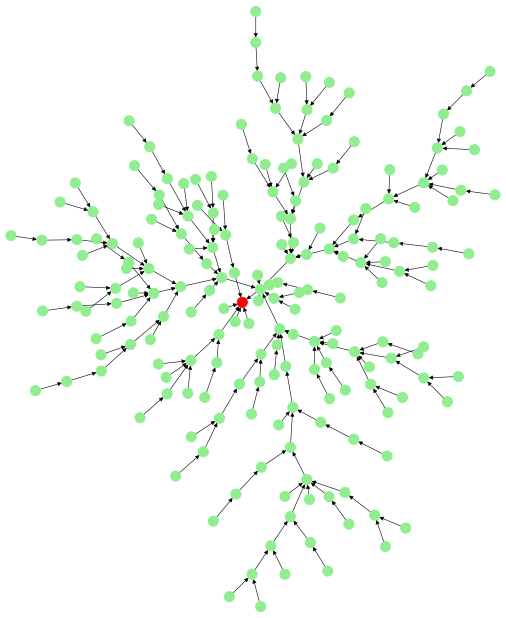

In [47]:
def day7v(s):  # Visualization
  graph = networkx.DiGraph()
  graph.add_node('/', label='/', node_color='red', size=0)
  dirs = collections.defaultdict[str, int](int)
  for line in s.splitlines():
    fields = line.split()
    if line == '$ cd /':
      curr = ['/']
    elif line == '$ cd ..':
      curr.pop()
    elif fields[1] == 'cd':
      parent = ''.join(curr)
      child = parent + fields[2] + '/'
      graph.add_node(child, label=fields[2], node_color='lightgreen', size=0)
      graph.add_edge(child, parent)
      curr.append(fields[2] + '/')
    elif line == '$ ls' or fields[0] == 'dir':
      pass
    else:
      parent = ''.join(curr)
      child = parent + fields[1]
      if 0:  # Adding files to the graph makes it overly busy.
        graph.add_node(child, label=fields[1], node_color='#D0D0D0', size=int(fields[0]))
        graph.add_edge(child, parent)
      for p in itertools.accumulate(curr):
        dirs[p] += int(fields[0])

  pos = hh.graph_layout(graph, prog='neato')
  fig, ax = plt.subplots(figsize=(12, 12), dpi=60)
  ax.set_aspect('equal')
  # labels = networkx.get_node_attributes(graph, 'label')
  node_color = [attr for _, attr in graph.nodes(data='node_color')]
  networkx.draw(graph, pos, node_size=150, node_color=node_color, width=0.7)
  fig.tight_layout(pad=0)
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  media.show_image(image, border=True, title='day07')
  plt.close(fig)


day7v(puzzle.input)

In [48]:
def day7(s, *, part2=False):  # Solution assuming depth-first traversal.
  stack: list[int] = []
  sizes: list[int] = []
  for line in s.splitlines():
    if line == '$ cd ..':
      sizes.append(size := stack.pop())
      stack[-1] += size
    elif line.startswith('$ cd '):
      stack.append(0)
    elif line[0].isdigit():
      stack[-1] += int(line.split()[0])
  sizes.extend(itertools.accumulate(stack[::-1]))
  if not part2:
    return sum(n for n in sizes if n <= 100_000)
  return min(n for n in sizes if n >= max(sizes) - 40_000_000)


check_eq(day7(s1), 95437)
puzzle.verify(1, day7)

day7_part2 = functools.partial(day7, part2=True)
check_eq(day7_part2(s1), 24933642)
puzzle.verify(2, day7_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day8"></a>
## Day 8: Visibility in height grid

- Part 1: Consider your map; how many trees are visible from outside the grid?

- Part 2: Consider each tree on your map. What is the highest scenic score possible for any tree?

---

For this problem it is natural to use a 2D `np.ndarray` grid.
One useful trick is to perform computations in a single direction, e.g., the positive X (row) direction,
rotate the grid by 90 degrees, and repeat 3 more times.
Because `numpy` maintains views over the arrays, the rotation operation is efficient as it
only manipulates some offset and stride parameters.

For Part 1, a clever vectorization approach is to use `np.maximum.accumulate`.

For Part 2, there is no obvious way to vectorize, so I resort to a `numba`-jitted function.

The `plotly` plotting tool supports interactive 3D rendering,
and is also used here to create image frames for a GIF video animation.

In [49]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2022/day/8), `puzzle.input` has 99 lines:

101002200302221033023303143134003020403131311534441424251301311211314032120023113231033031121022011
000000201330102222312340313324430424413214435242113342242434514432041413213343304030120232213020102
010000203232213031433114342021403232235333514333553111322134215441434143114041342040010222003200011
201120030122210332140433403113122131244442241135435342113515341543341343142312131142111133212030212
102222201221120143442131002141522315514253432414212415252133341422341353034001030100033222300111111
121102223123133443003222043412143224143335142344513313134225453143435255411141013220230131131103220
001113200123030444213411141214335523335333534154243113221355254515244442254124002044421400233210010
110103213102123332202242154123512313351111234166565435351154333252135532152130134301110311011211302
 ...
011003112002012034340041324422224354112355545251413535512312452115342144411141020000324121133331211
11022220330300210331443441223155415135235145523321544552344121522131324023003032133432113132003

The stored answers are: `{1: '1849', 2: '201600'}`

In [50]:
s1 = """\
30373
25512
65332
33549
35390
"""

In [51]:
def day8a_part1(s):  # Slow.
  grid = np.array([list(line) for line in s.splitlines()], int)
  visible = np.full(grid.shape, False)
  for _ in range(4):
    shape = grid.shape
    for y in range(shape[0]):
      visible[y, 0] = True
      vmax = -1
      for x in range(shape[1]):
        if grid[y, x] > vmax:
          visible[y, x] = True
        vmax = max(vmax, grid[y, x])
    grid, visible = map(np.rot90, [grid, visible])
  return visible.sum()


check_eq(day8a_part1(s1), 21)
puzzle.verify(1, day8a_part1)

(Part 1: 0.009 s)


In [52]:
def day8a_part2(s):  # Slow.
  grid = np.array([list(line) for line in s.splitlines()], int)
  product = np.ones_like(grid)
  for _ in range(4):
    for (y, x), value in np.ndenumerate(grid):
      num = 0
      for xx in range(x - 1, -1, -1):
        num += 1
        if grid[y, xx] >= value:
          break
      product[y, x] *= num
    grid, product = map(np.rot90, [grid, product])
  return product.max()


check_eq(day8a_part2(s1), 8)
puzzle.verify(2, day8a_part2)

(Part 2: 0.027 s)


(Part 1: 0.310 s)
(Part 2: 0.307 s)


day08a,day08b

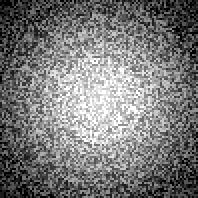
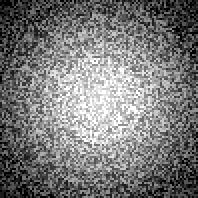

In [53]:
# From https://www.reddit.com/r/adventofcode/comments/zfpnka/comment/izd90g1/
# Compact but 10x slower.  Add 2D visualization.
def day8v(s, *, part2=False, visualize=False):
  grid = np.array([list(line) for line in s.splitlines()], int)
  matrix1 = np.zeros_like(grid, int)
  matrix2 = np.ones_like(grid, int)
  for _ in range(4):
    for y, x in np.ndindex(grid.shape):
      lower = [t < grid[y, x] for t in grid[y, x + 1 :]]
      matrix1[y, x] |= all(lower)
      matrix2[y, x] *= next((i + 1 for i, t in enumerate(lower) if ~t), len(lower))
    grid, matrix1, matrix2 = map(np.rot90, [grid, matrix1, matrix2])

  if visualize:
    image0 = media.to_rgb(grid.astype(float), cmap='gray')
    image1, image2 = image0.copy(), image0.copy()
    image1[:] = (matrix1[..., None] == 0) * 0.95
    matrix2.flat[matrix2.argmax()] = 10**8  # Select a unique maximum.
    for _ in range(4):
      y, x = np.unravel_index(matrix2.argmax(), matrix2.shape)  # type: ignore[assignment]
      image2[y, x] = 1.0, 0.0, 0.0
      for x2 in range(x + 1, grid.shape[1]):
        if grid[y, x2] >= grid[y, x]:
          break
        image2[y, x2] = 1.0, 0.0, 0.0
      grid, image2, matrix2 = map(np.rot90, [grid, image2, matrix2])
    videos = {
        'day08a': np.array([image0, image1]).repeat(2, axis=1).repeat(2, axis=2),
        'day08b': np.array([image0, image2]).repeat(2, axis=1).repeat(2, axis=2),
    }
    media.show_videos(videos, codec='gif', fps=1)

  return matrix2.max() if part2 else matrix1.sum()


check_eq(day8v(s1), 21)
puzzle.verify(1, day8v)

day8v_part2 = functools.partial(day8v, part2=True)
check_eq(day8v_part2(s1), 8)
puzzle.verify(2, day8v_part2)

_ = day8v(puzzle.input, visualize=True)

day08c

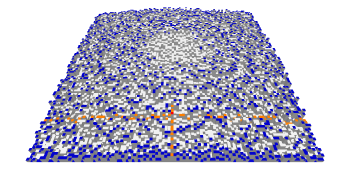

In [54]:
def day8w(s):  # Use plotly to create 3D visualization.
  grid = np.array([list(line) for line in s.splitlines()], int)
  matrix1 = np.full_like(grid, 0)
  matrix2 = np.full_like(grid, 1)
  for _ in range(4):
    for y, x in np.ndindex(grid.shape):
      lower = [t < grid[y, x] for t in grid[y, x + 1 :]]
      matrix1[y, x] |= all(lower)
      matrix2[y, x] *= next((i + 1 for i, t in enumerate(lower) if ~t), len(lower))
    grid, matrix1, matrix2 = map(np.rot90, [grid, matrix1, matrix2])

  lighting = dict(ambient=0.5, diffuse=0.5, fresnel=0.1, specular=0.1, roughness=0.05)
  lighting.update(facenormalsepsilon=1e-15)  # Crucial given the degenerate triangles.
  facecolor = np.full((*grid.shape[:2], 3), (0.94,) * 3)
  facecolor[matrix1 != 0] = 0.0, 0.0, 0.8
  matrix2.flat[matrix2.argmax()] = 10**8  # Select a unique Part 2 maximum.
  for _ in range(4):
    y, x = np.unravel_index(matrix2.argmax(), matrix2.shape)  # type: ignore[assignment]
    facecolor[y, x] = 1.0, 0.0, 0.0
    for x2 in range(x + 1, grid.shape[1]):
      if grid[y, x2] >= grid[y, x]:
        break
      facecolor[y, x2] = 1.0, 0.5, 0.0
    grid, facecolor, matrix2 = map(np.rot90, [grid, facecolor, matrix2])

  surface = hh.mesh3d_from_height(
      grid,
      facecolor=facecolor,
      color=(0.94,) * 3,
      flatshading=True,
      lighting=lighting,
      lightposition=dict(x=-20, y=-100, z=50),
  )
  fig = go.Figure(data=[surface])

  def set_fig_layout(*, for_tilt):
    a = 0.1  # Downscale dimensions to avoid clipping eye coordinates to max ~100.
    aspectratio = dict(x=grid.shape[1] * a, y=grid.shape[0] * a, z=10 * a)
    eye = dict(x=0, y=-100 * a, z=80 * a) if for_tilt else dict(x=0, y=-75 * a, z=60 * a)
    camera = dict(center=dict(x=0, y=0, z=-20 * a), eye=eye)
    no_axes = dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False))
    scene = dict(aspectratio=aspectratio, camera=camera, **no_axes)
    fig.layout.update(width=700, height=350, margin=dict(l=0, r=0, b=0, t=0), scene=scene)

  set_fig_layout(for_tilt=False)
  if SHOW_BIG_MEDIA and hh.in_notebook():
    hh.display_html('Interactively control the viewpoint by dragging or scrolling:')
    fig.show()

  image = hh.image_from_plotly(fig, width=350, height=175)
  media.show_image(image, border=True, title='day08c')

  if SHOW_BIG_MEDIA:
    video: Any = hh.wobble_video(fig, amplitude=2.0)
    media.show_video(video, codec='gif', fps=10, border=True, title='day08d')
    set_fig_layout(for_tilt=True)
    video = np.array(hh.tilt_video(fig))[:, :, 140:-140]
    media.show_video(video, codec='gif', fps=3, border=True, title='day08e')

  hh.no_vertical_scroll()


day8w(puzzle.input)

Cached result:<br/>
<img src="results/day08e.gif"/>

In [55]:
# Adapted from https://www.reddit.com/r/adventofcode/comments/zfpnka/comment/izd90g1/
# Sped up by using lazy generator, but still slow.
def day8z(s, *, part2=False):
  grid = np.array([list(line) for line in s.splitlines()], int)
  matrix = np.full_like(grid, 1 if part2 else 0)
  for _ in range(4):
    for y, x in np.ndindex(grid.shape):
      lower = (t < grid[y, x] for t in grid[y, x + 1 :])
      if part2:
        matrix[y, x] *= next((i + 1 for i, t in enumerate(lower) if ~t), len(grid[y, x + 1 :]))
      else:
        matrix[y, x] |= all(lower)
    grid, matrix = map(np.rot90, [grid, matrix])
  return matrix.max() if part2 else matrix.sum()


check_eq(day8z(s1), 21)
puzzle.verify(1, day8z)

day8z_part2 = functools.partial(day8z, part2=True)
check_eq(day8z_part2(s1), 8)
puzzle.verify(2, day8z_part2)

(Part 1: 0.044 s)
(Part 2: 0.108 s)


In [56]:
def day8_part1(s):  # Fast using np.maximum.accumulate().
  grid = np.array([list(line) for line in s.splitlines()], int)
  visible = np.full(grid.shape, False)
  for _ in range(4):
    visible[:, 0] = True
    visible[:, 1:] |= grid[:, 1:] > np.maximum.accumulate(grid, 1)[:, :-1]
    grid, visible = map(np.rot90, [grid, visible])
  return visible.sum()


check_eq(day8_part1(s1), 21)
puzzle.verify(1, day8_part1)

(Part 1: 0.001 s)


In [57]:
# Fast using numba (~30x speedup).
# We must include the function signature because rotation of array requires general (non-C) layout.
@numba.njit('int64(int64[:, :])')
def day8_part2_inner(grid):
  product = np.ones_like(grid)
  for _ in range(4):
    for (y, x), value in np.ndenumerate(grid):
      num = 0
      for xx in range(x - 1, -1, -1):
        num += 1
        if grid[y, xx] >= value:
          break
      product[y, x] *= num
    grid, product = map(np.rot90, [grid, product])
  return product.max()


def day8_part2(s):
  grid = np.array([list(line) for line in s.splitlines()], np.int64)
  return day8_part2_inner(grid)


check_eq(day8_part2(s1), 8)
puzzle.verify(2, day8_part2)

(Part 2: 0.001 s)


<a name="day9"></a>
## Day 9: Snaking rope

- Part 1: Simulate your complete hypothetical series of motions. How many positions does the tail of the rope visit at least once?

- Part 2: Simulate your complete series of motions on a larger rope with ten knots. How many positions does the tail of the rope visit at least once?

---

One acceleration trick useful in Part 2 is to recognize that if a node (in the chain of nodes) does not move,
then it is unnecessary to check for possible motions of any subsequent nodes.

A video animation starts with a close-up view of the snake advancing at a slow pace, then gradually zooms out (based on a bounding box) and accelerates the action.
What makes this video challenging to create is that we do not know the extent of the final grid during the snake simulation.
The solution is to accumulate batches of updates (using coordinate sets) per-frame, with an increasing time delay between frames,
and only convert these batch updates into images at the end of the snake simulation when the final bounding box is known.

In [58]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2022/day/9), `puzzle.input` has 2_000 lines:

D 2
R 1
L 2
U 1
R 2
L 2
R 2
L 1
 ...
D 18
U 16
D 9
U 12


The stored answers are: `{1: '6284', 2: '2661'}`

In [59]:
s1 = """\
R 4
U 4
L 3
D 1
R 4
D 1
L 5
R 2
"""

In [60]:
s2 = """\
R 5
U 8
L 8
D 3
R 17
D 10
L 25
U 20
"""

In [61]:
def day9a(s, *, part2=False):  # Most compact solution (but numpy abs() is slow).
  nodes = np.zeros((10 if part2 else 2, 2), int)
  visited = {(0, 0)}

  for line in s.splitlines():
    delta_yx = {'D': (1, 0), 'U': (-1, 0), 'R': (0, 1), 'L': (0, -1)}[line[0]]
    for _ in range(int(line[2:])):
      nodes[0] += delta_yx
      for front, rear in zip(nodes[:-1], nodes[1:]):
        if abs(front - rear).max() <= 1:
          break
        rear += np.sign(front - rear)
      visited.add(tuple(nodes[-1]))  # type: ignore[arg-type]

  return len(visited)


check_eq(day9a(s1), 13)
puzzle.verify(1, day9a)

day9a_part2 = functools.partial(day9a, part2=True)
check_eq(day9a_part2(s2), 36)
puzzle.verify(2, day9a_part2)

(Part 1: 0.069 s)
(Part 2: 0.175 s)


In [62]:
def day9b(s, *, part2=False, visualize=False, pad=1, pad0=12, background=(245,) * 3):
  nodes = np.zeros((10 if part2 else 2, 2), int)
  visited = {(0, 0)}

  # For visualize=True:
  class Frame(NamedTuple):
    visited: set[tuple[int, int]]
    nodes: np.ndarray
    step_index: int

  frames: list[Frame] = []
  countdown = 1
  partial_visited = {(0, 0)}
  step_index = 0

  for line in s.splitlines():
    delta_yx = {'D': (1, 0), 'U': (-1, 0), 'R': (0, 1), 'L': (0, -1)}[line[0]]
    for _ in range(int(line[2:])):
      nodes[0] += delta_yx
      for front, rear in zip(nodes[:-1], nodes[1:]):
        if abs(front - rear).max() <= 1:
          break
        rear += np.sign(front - rear)
      visited.add(tuple(nodes[-1]))  # type: ignore[arg-type]
      if visualize:
        partial_visited.add(tuple(nodes[-1]))  # type: ignore[arg-type]
        step_index += 1
        countdown -= 1
        if countdown == 0:
          countdown = np.clip((len(frames) - 120) // 6, 1, 50)
          frames.append(Frame(partial_visited, nodes.copy(), step_index))
          partial_visited = set()

  if visualize:
    frames.append(Frame(partial_visited, nodes.copy(), step_index))
    images = []
    pos = [node for frame in frames for node in frame.nodes] + list(visited)
    yx1_min, yx1_max = np.min(pos, axis=0) - pad, np.max(pos, axis=0) + pad  # Final window.
    shape = tuple(yx1_max - yx1_min + 1) + (3,)
    image = np.full(shape, background, np.uint8)
    final_shape = shape[0] * 2, shape[1] * 2
    yx0_min, yx0_max = np.maximum(-pad0, yx1_min), np.minimum(pad0, yx1_max)  # Initial window.
    for partial_visited, nodes, step_index in frames:
      image[tuple((list(partial_visited) - yx1_min).T)] = 180
      image2 = image.copy()
      image2[tuple((nodes[1:-1] - yx1_min).T)] = 0, 0, 0
      image2[tuple(nodes[0] - yx1_min)] = 255, 0, 0
      image2[tuple(nodes[-1] - yx1_min)] = 0, 255, 0
      pos = list(nodes) + list(partial_visited)
      yx0_min = np.min([yx0_min] + pos, axis=0)
      yx0_max = np.max([yx0_max] + pos, axis=0)
      slices = tuple(
          slice(yx0_min[c] - pad - yx1_min[c], yx0_max[c] + pad + 1 - yx1_min[c]) for c in range(2)
      )
      cropped = image2[slices]
      options: Any = dict(boundary='border', gamma='identity', cval=np.array(background) / 255)
      resized = resampler.uniform_resize(cropped, final_shape, filter='trapezoid', **options)
      text = f'Step {step_index:5}'
      hh.overlay_text(resized, (6, 3), text, fontsize=20, background=background)
      images.append(resized)
    images = [images[0]] * 5 + images + [images[-1]] * 50
    media.show_image(images[-1], title='day09a')
    if SHOW_BIG_MEDIA:  # ~1 MB GIF (or 444 MB h264).
      media.show_video(images, codec='gif', fps=50, title='day09b')

  return len(visited)


check_eq(day9b(s1), 13)
puzzle.verify(1, day9b)

day9b_part2 = functools.partial(day9b, part2=True)
check_eq(day9b_part2(s2), 36)
puzzle.verify(2, day9b_part2)

(Part 1: 0.071 s)
(Part 2: 0.180 s)


day09a

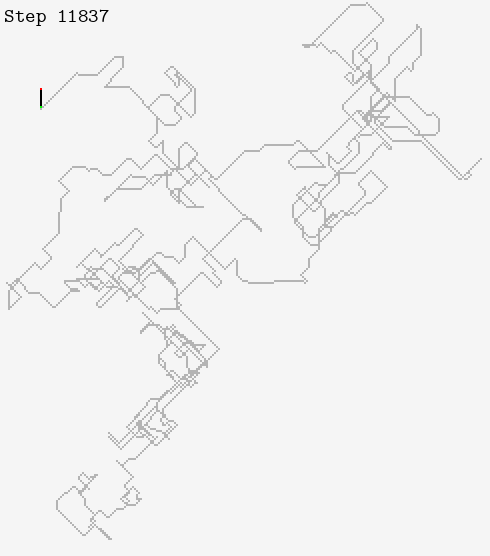

In [63]:
_ = day9b_part2(puzzle.input, visualize=True)

Cached result:<br/>
<img src="results/day09b.gif"/>

In [64]:
def day9(s, *, part2=False):  # Faster solution with explicit coordinates and no numpy.
  nodes = [[0, 0] for _ in range(10 if part2 else 2)]
  visited = {(0, 0)}

  for line in s.splitlines():
    dy, dx = {'D': (1, 0), 'U': (-1, 0), 'R': (0, 1), 'L': (0, -1)}[line[0]]
    for _ in range(int(line[2:])):
      front_y, front_x = nodes[0] = [nodes[0][0] + dy, nodes[0][1] + dx]
      for rear in nodes[1:]:
        rear_y, rear_x = rear
        if abs(front_y - rear_y) <= 1 and abs(front_x - rear_x) <= 1:
          break
        rear_y = rear[0] = rear_y + (1 if front_y > rear_y else -1 if front_y < rear_y else 0)
        rear_x = rear[1] = rear_x + (1 if front_x > rear_x else -1 if front_x < rear_x else 0)
        front_y, front_x = rear_y, rear_x
      visited.add((nodes[-1][0], nodes[-1][1]))

  return len(visited)


check_eq(day9(s1), 13)
puzzle.verify(1, day9)

day9_part2 = functools.partial(day9, part2=True)
check_eq(day9_part2(s2), 36)
puzzle.verify(2, day9_part2)

(Part 1: 0.007 s)
(Part 2: 0.014 s)


<a name="day10"></a>
## Day 10: Raster scan

- Part 1: Find the signal strength during the 20th, 60th, 100th, 140th, 180th, and 220th cycles. What is the sum of these six signal strengths?

- Part 2: Render the image given by your program. What eight capital letters appear on your CRT?

---

For this problem, it is handy to use a generator function.

A colleague showed me how the small 2D grid can be conveniently visualized as text
using the Unicode characters '⬜' and '⬛'.

In [65]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2022/day/10), `puzzle.input` has 139 lines:

addx 1
noop
noop
noop
addx 5
addx 5
noop
noop
 ...
addx 3
noop
addx -30
noop


The stored answers are: `{1: '11960', 2: 'EJCFPGLH'}`

In [66]:
s1 = """\
addx 15 addx -11 addx 6 addx -3 addx 5 addx -1 addx -8 addx 13 addx 4 noop
addx -1 addx 5 addx -1 addx 5 addx -1 addx 5 addx -1 addx 5 addx -1 addx -35
addx 1 addx 24 addx -19 addx 1 addx 16 addx -11 noop noop addx 21 addx -15
noop noop addx -3 addx 9 addx 1 addx -3 addx 8 addx 1 addx 5 noop
noop noop noop noop addx -36 noop addx 1 addx 7 noop noop
noop addx 2 addx 6 noop noop noop noop noop addx 1 noop
noop addx 7 addx 1 noop addx -13 addx 13 addx 7 noop addx 1 addx -33
noop noop noop addx 2 noop noop noop addx 8 noop addx -1
addx 2 addx 1 noop addx 17 addx -9 addx 1 addx 1 addx -3 addx 11 noop
noop addx 1 noop addx 1 noop noop addx -13 addx -19 addx 1 addx 3
addx 26 addx -30 addx 12 addx -1 addx 3 addx 1 noop noop noop addx -9
addx 18 addx 1 addx 2 noop noop addx 9 noop noop noop addx -1
addx 2 addx -37 addx 1 addx 3 noop addx 15 addx -21 addx 22 addx -6 addx 1
noop addx 2 addx 1 noop addx -10 noop noop addx 20 addx 1 addx 2
addx 2 addx -6 addx -11 noop noop noop
"""

In [67]:
s2 = """\
##..##..##..##..##..##..##..##..##..##..
###...###...###...###...###...###...###.
####....####....####....####....####....
#####.....#####.....#####.....#####.....
######......######......######......####
#######.......#######.......#######.....
"""

In [68]:
def day10a(s, *, part2=False, return_multiline=False, visualize=False):
  def xvalues():
    x = 1
    for word in (it := iter(s.split())):
      yield x
      if word != 'noop':
        yield x
        x += int(next(it, None))  # type: ignore[arg-type]

  if not part2:
    return sum(cycle * x for cycle, x in enumerate(xvalues(), 1) if cycle % 40 == 20)

  a = np.array(['.#'[abs(x - v) < 2] for (y, x), v in zip(np.ndindex(6, 40), xvalues())])
  s2 = '\n'.join(''.join(row) for row in a.reshape(6, 40))

  if visualize:
    hh.display_html(s2.replace('.', '⬜').replace('#', '⬛').replace('\n', '<br/>'))

  if visualize:
    xv = list(xvalues())
    _, ax = plt.subplots(figsize=(7, 4))
    ax.plot(np.arange(len(xv)), np.arange(len(xv)) % 40)
    ax.plot(range(len(xv)), xv)
    ax.set(xlabel='Cycle', ylabel='Value of $x$')

  return s2 + '\n' if return_multiline else advent_of_code_ocr.convert_6(s2)


check_eq(day10a(s1), 13140)
puzzle.verify(1, day10a)

day10a_part2 = functools.partial(day10a, part2=True)
check_eq(day10a_part2(s1, return_multiline=True), s2)
puzzle.verify(2, day10a_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


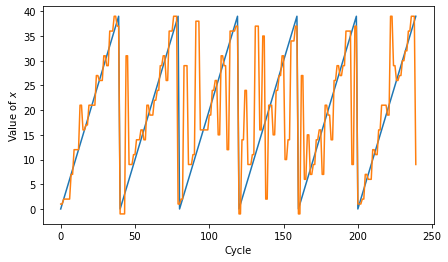

In [69]:
_ = day10a_part2(puzzle.input, visualize=True)

In [70]:
def day10(s, *, part2=False, w=40):  # Most compact, with OCR.
  def xs():
    x = 1
    for word in (it := iter(s.split())):
      yield x
      if word != 'noop':
        yield x
        x += int(next(it, None))  # type: ignore[arg-type]

  if not part2:
    return sum(i * x for i, x in enumerate(xs(), 1) if i % w == 20)

  s2 = ''.join('.#'[abs(i % w - x) < 2] for i, x in enumerate(xs()))
  s2 = '\n'.join(textwrap.wrap(s2, width=w))
  return advent_of_code_ocr.convert_6(s2)


check_eq(day10(s1), 13140)
puzzle.verify(1, day10)

day10_part2 = functools.partial(day10, part2=True)
puzzle.verify(2, day10_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day11"></a>
## Day 11: Monkeys passing items

- Part 1: Determine how many items each monkey inspects over 20 rounds; what is the product of these numbers for the two most active monkeys?

- Part 2: Worry levels are no longer divided by three after each item is inspected. Starting again from the initial state in your puzzle input, what is the level of monkey business after 10000 rounds?

---

This problem begs for some type of `class/struct` data structure.
The implementations below using `dataclass` and `collections.namedtuple` have similar efficiency.
A `numba`-jitted function provides a 4x speedup.

This problem led me to discover partial specialization using nested lambdas,
as in `(lambda c: lambda x: x * c)(int(arg))`,
which specializes `x * c` by capturing the constant `c` from `int(arg)`.

In [71]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2022/day/11), `puzzle.input` has 55 lines:

Monkey 0:
  Starting items: 63, 84, 80, 83, 84, 53, 88, 72
  Operation: new = old * 11
  Test: divisible by 13
    If true: throw to monkey 4
    If false: throw to monkey 7

Monkey 1:
 ...
  Operation: new = old * 19
  Test: divisible by 17
    If true: throw to monkey 2
    If false: throw to monkey 1


The stored answers are: `{1: '117640', 2: '30616425600'}`

In [72]:
s1 = """\
Monkey 0:
  Starting items: 79, 98
  Operation: new = old * 19
  Test: divisible by 23
    If true: throw to monkey 2
    If false: throw to monkey 3

Monkey 1:
  Starting items: 54, 65, 75, 74
  Operation: new = old + 6
  Test: divisible by 19
    If true: throw to monkey 2
    If false: throw to monkey 0

Monkey 2:
  Starting items: 79, 60, 97
  Operation: new = old * old
  Test: divisible by 13
    If true: throw to monkey 1
    If false: throw to monkey 3

Monkey 3:
  Starting items: 74
  Operation: new = old + 3
  Test: divisible by 17
    If true: throw to monkey 0
    If false: throw to monkey 1
"""

In [73]:
# mod = math.lcm(*[monkey.divisible_by for monkey in monkeys])

In [74]:
def day11a(s, *, part2=False):  # Using dataclass.
  @dataclasses.dataclass
  class Monkey:
    items: list[int]
    operation: Callable[[int], int]
    divisible_by: int
    throws: list[int]
    activity: int = 0

  monkeys = []
  for lines in (s2.splitlines() for s2 in s.split('\n\n')):
    items = list(map(int, lines[1].split(':')[1].split(',')))
    op, arg = lines[2][23], lines[2][25:]
    operation = (
        (lambda x: x * x)
        if arg == 'old'
        else (lambda c: lambda x: x * c)(int(arg))
        if op == '*'
        else (lambda c: lambda x: x + c)(int(arg))
    )
    divisible_by = int(lines[3][21:])
    throws = [int(line.split()[-1]) for line in lines[4:6]]
    monkeys.append(Monkey(items, operation, divisible_by, throws))

  mod = math.prod(monkey.divisible_by for monkey in monkeys)

  for _ in range(10_000 if part2 else 20):
    for monkey in monkeys:
      monkey.activity += len(monkey.items)
      op, throws, divisible_by = monkey.operation, monkey.throws, monkey.divisible_by
      for item in monkey.items:
        item = op(item)
        item = item % mod if part2 else item // 3
        dest = throws[item % divisible_by != 0]
        monkeys[dest].items.append(item)
      monkey.items = []

  return math.prod(sorted(monkey.activity for monkey in monkeys)[-2:])


check_eq(day11a(s1), 10605)
puzzle.verify(1, day11a)

day11a_part2 = functools.partial(day11a, part2=True)
check_eq(day11a_part2(s1), 2_713_310_158)
puzzle.verify(2, day11a_part2)

(Part 1: 0.001 s)
(Part 2: 0.136 s)


In [75]:
def day11b(s, *, part2=False):  # Using collections.namedtuple.
  Monkey = collections.namedtuple('Monkey', 'items operation divisible_by throws')
  monkeys = []

  for lines in (s2.splitlines() for s2 in s.split('\n\n')):
    items = list(map(int, lines[1].split(':')[1].split(',')))
    op, arg = lines[2][23], lines[2][25:]
    operation = (
        (lambda x: x * x)
        if arg == 'old'
        else (lambda c: lambda x: x * c)(int(arg))
        if op == '*'
        else (lambda c: lambda x: x + c)(int(arg))
    )
    divisible_by = int(lines[3][21:])
    throws = [int(line.split()[-1]) for line in lines[4:6]]
    monkeys.append(Monkey(items, operation, divisible_by, throws))

  activities = [0] * len(monkeys)
  mod = math.prod(monkey.divisible_by for monkey in monkeys)

  for _ in range(10_000 if part2 else 20):
    for i, monkey in enumerate(monkeys):
      activities[i] += len(monkey.items)
      op, throws, divisible_by = monkey.operation, monkey.throws, monkey.divisible_by
      for item in monkey.items:
        item = op(item)
        item = item % mod if part2 else item // 3
        dest = throws[item % divisible_by != 0]
        monkeys[dest].items.append(item)
      monkey.items.clear()

  return math.prod(sorted(activities)[-2:])


check_eq(day11b(s1), 10605)
puzzle.verify(1, day11b)

day11b_part2 = functools.partial(day11b, part2=True)
check_eq(day11b_part2(s1), 2_713_310_158)
puzzle.verify(2, day11b_part2)

(Part 1: 0.001 s)
(Part 2: 0.132 s)


In [76]:
# Fast using numba, but ugly because numba function parameters cannot be lists.
@numba.njit
def day11_process(itemss1, ops, args, divisible_bys, throwss, activities, part2, mod):
  # Convert "ragged" 2d array to list of lists.
  itemss = [[item for item in items if item >= 0] for items in itemss1]
  for _ in range(10_000 if part2 else 20):
    for i, (items, op, arg, divisible_by, throws) in enumerate(
        zip(itemss, ops, args, divisible_bys, throwss)
    ):
      activities[i] += len(items)
      for item in items:
        item = item * (arg if arg >= 0 else item) if op == '*' else item + arg
        item = item % mod if part2 else item // 3
        dest = throws[int(item % divisible_by != 0)]
        itemss[dest].append(item)
      itemss[i].clear()


def day11(s, *, part2=False):
  ss = s.split('\n\n')
  itemss = []
  ops = np.full(len(ss), ' ')
  args = np.full(len(ss), 0, np.int64)
  divisible_bys = np.full(len(ss), 0, np.int64)
  throwss = np.full((len(ss), 2), 0, np.int64)
  activities = np.full(len(ss), 0, np.int64)

  for i, s2 in enumerate(ss):
    lines = s2.splitlines()
    itemss.append(list(map(int, lines[1].split(':')[1].split(','))))
    ops[i] = lines[2][23]
    args[i] = -1 if (arg := lines[2][25:]) == 'old' else int(arg)
    divisible_bys[i] = int(lines[3][21:])
    throwss[i] = [int(line.split()[-1]) for line in lines[4:6]]

  # Convert list of lists to "ragged" array.
  max_items = max(len(items) for items in itemss)
  itemss1 = np.full((len(ss), max_items), -1, np.int64)
  for i, items in enumerate(itemss):
    itemss1[i, : len(items)] = items
  mod = math.prod(divisible_bys)
  day11_process(itemss1, ops, args, divisible_bys, throwss, activities, part2, mod)
  return math.prod(sorted(activities)[-2:])


check_eq(day11(s1), 10605)
puzzle.verify(1, day11)

day11_part2 = functools.partial(day11, part2=True)
check_eq(day11_part2(s1), 2_713_310_158)
puzzle.verify(2, day11_part2)

(Part 1: 0.000 s)
(Part 2: 0.035 s)


<a name="day12"></a>
## Day 12: Shallow hill climbing

- Part 1: What is the fewest steps required to move from your current position to the location that should get the best signal?

- Part 2: What is the fewest steps required to move starting from any square with elevation a to the location that should get the best signal?

---

The initial approach is a breadth-first-search (BFS) using a `deque` and a `set` of already visited nodes.

An important observation for Part 2 is that a multi-source BFS is extremely easy &mdash;
one simply initializes the queue with not just one node but the entire set of source nodes.

We explore a sequence of accelerations:

1. Use a 2D `np.ndarray` rather than `set` to maintain the visited nodes.

2. Use array padding to obviate the need to check array bounds during the search.

3. Convert the characters to integers in the array.

4. Implement the BFS as a separate BFS for each distance unit &mdash; using two queues (current and next),
   thereby obviating the need to maintain distance state in the queue.

5. Implement the final algorithm in a `numba`-jitted function; the resulting computation takes just 2 ms.

Of the visualizations, my favorite is a looping video which tilts the viewpoint of a 3D rendering.

In [77]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2022/day/12), `puzzle.input` has 41 lines:

abccccaaaaaaaaaaaaaccaaaaaaaacccccccccaaaaaaaaccccccccaaacaaacccccccaaaaaacccccc ... cccccccccccccccccccccccccccccccaaaa
abccccaaaaacaaaaaaccccaaaaaaccccccccccaaaaaaacccccccccaaaaaaacccccaaaaaaaaaacccc ... ccccccccccccccccccccccccccccccaaaaa
abcccaaaaaccaaaaaaccccaaaaaaccccccaacccaaaaaacccccccccaaaaaacccaaaaaaaaaaaaaaaca ... ccccccccccccccccccccccccccccccaaaaa
abccccccaaccaaaaaaccaaaaaaaaccccccaaacaaaacaaacccccccaaaaaaaaccaaaaaaaaaaaaaaaca ... cccccccccccccccccacccccccccccaaaaaa
abccccccccccaaccaaccaaaaccaacccccccaaaaaaaccccccccccaaaaaaaaaaaaaaaaaaaaaaaaaaaa ... cccccccccccccccccaaccccccccccccccaa
abcccccccaaaaacccaaaaaaaacccaaccccaaaaaaccccccccccccaaaaaaaaaaaaaaaacaaaaaaaccaa ... ccccccccccccccccccaccccccccccccccca
abcccccccaaaaacccaaaaaaaaccaaaaccaaaaaaaaccccccccccccccaaacaaaaaaaaacaaaaaaccccc ... cccccccccllllllccccdccccccccccccccc
abccccccaaaaaacccccaaaaccccaaaaacaaaaaaaaccccccccccccccaaacccccaaaccccaaaaaaccca ... cccccccklllllllllcddddccaccaaaccccc
 ...
abccccaaccccccaaaaaaccccccc

The stored answers are: `{1: '534', 2: '525'}`

In [78]:
s1 = """\
Sabqponm
abcryxxl
accszExk
acctuvwj
abdefghi
"""

In [79]:
def day12a(s, *, part2=False):  # Using `set` for seen nodes.
  grid = np.array([list(line) for line in s.splitlines()])
  start_yx, end_yx = (tuple(np.argwhere(grid == c)[0]) for c in 'SE')
  grid[start_yx], grid[end_yx] = 'a', 'z'
  seen = set([start_yx] if not part2 else map(tuple, np.argwhere(grid == 'a')))
  queue = collections.deque([(yx, 0) for yx in seen])

  while True:
    yx, distance = queue.popleft()
    if yx == end_yx:
      return distance
    for dy, dx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
      yx2 = y2, x2 = yx[0] + dy, yx[1] + dx
      inbounds = 0 <= y2 < grid.shape[0] and 0 <= x2 < grid.shape[1]
      if inbounds and yx2 not in seen and ord(grid[yx2]) <= ord(grid[yx]) + 1:
        seen.add(yx2)
        queue.append((yx2, distance + 1))


check_eq(day12a(s1), 31)
puzzle.verify(1, day12a)

day12a_part2 = functools.partial(day12a, part2=True)
check_eq(day12a_part2(s1), 29)
puzzle.verify(2, day12a_part2)

(Part 1: 0.015 s)
(Part 2: 0.016 s)


day12a

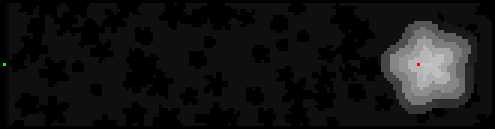

In [80]:
def day12v(s, *, n=3):  # Visualize as GIF image.
  # See also https://www.reddit.com/r/adventofcode/comments/zjsgaa/2022_day_12_part_2_in_minecraft/
  images = []
  grid_ch = np.array([list(line) for line in s.splitlines()])
  start_yx, end_yx = (tuple(np.argwhere(grid_ch == c)[0]) for c in 'SE')
  grid = np.array([[ord(c) - ord('a') for c in row] for row in grid_ch])
  grid[start_yx], grid[end_yx] = 0, 25

  for part in range(2):
    sentinel = -1, -1
    starts: Any = np.argwhere(grid == 0) if part else [start_yx]
    prev = {(y, x): sentinel for y, x in starts}
    queue = collections.deque(prev)
    image = media.to_rgb(grid / 25, vmax=1.3)
    image[tuple(zip(*prev))] = 0.0, 1.0, 0.0
    image[end_yx] = 1.0, 0.0, 0.0
    images.append(image)

    while (yx := queue.popleft()) != end_yx:
      for dy, dx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
        yx2 = y2, x2 = yx[0] + dy, yx[1] + dx
        inbounds = 0 <= y2 < grid.shape[0] and 0 <= x2 < grid.shape[1]
        if inbounds and yx2 not in prev and grid[yx2] <= grid[yx] + 1:
          prev[yx2] = yx
          queue.append(yx2)

  image = images[-1].copy()
  while yx != sentinel:
    image[yx] += 0.3
    image[yx][2] = 1.0
    yx = prev[yx]
  images.append(image)
  images = [np.pad(image, ((1, 1), (1, 1), (0, 0))) for image in images]
  images = [image.repeat(n, axis=0).repeat(n, axis=1) for image in images]
  media.show_video(images, codec='gif', fps=1, title='day12a')


day12v(puzzle.input)

day12b

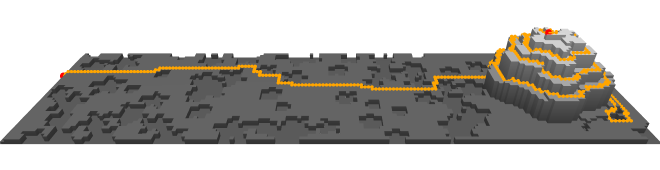

In [81]:
def day12w(s, use_tilt=True):  # Visualize using plotly 3D rendering.
  grid_ch = np.array([list(line) for line in s.splitlines()])
  start_yx, end_yx = (tuple(np.argwhere(grid_ch == c)[0]) for c in 'SE')
  grid = np.array([[ord(c) - ord('a') for c in row] for row in grid_ch])
  grid[start_yx], grid[end_yx] = 0, 25

  for part in range(2):
    sentinel = -1, -1
    starts: Any = np.argwhere(grid == 0) if part else [start_yx]
    prev = {(y, x): sentinel for y, x in starts}
    queue = collections.deque(prev)
    while (yx := queue.popleft()) != end_yx:
      for dy, dx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
        yx2 = y2, x2 = yx[0] + dy, yx[1] + dx
        inbounds = 0 <= y2 < grid.shape[0] and 0 <= x2 < grid.shape[1]
        if inbounds and yx2 not in prev and grid[yx2] <= grid[yx] + 1:
          prev[yx2] = yx
          queue.append(yx2)

  path_points = []
  while yx != sentinel:
    path_points.append((*yx, grid[yx]))
    yx = prev[yx]

  lighting = dict(ambient=0.5, diffuse=0.5, fresnel=0.1, specular=0.1, roughness=0.05)
  lighting.update(facenormalsepsilon=1e-15)  # Crucial given the degenerate triangles.
  surface = hh.mesh3d_from_height(
      grid,
      colorscale=[(0.0, 'rgb(90, 90, 90)'), (1.0, 'rgb(220, 220, 220)')],
      cmin=-10,
      showscale=False,
      flatshading=True,
      lighting=lighting,
      lightposition=dict(x=-20, y=-100, z=50),
  )

  path_array = (np.array(path_points) + (0.5, 0.5, 0.52)).T
  path_data = go.Scatter3d(
      x=path_array[1],
      y=path_array[0],
      z=path_array[2],
      mode='lines+markers',
      line=dict(color='orange', width=3),
      marker=dict(size=2, color='orange'),
  )
  path_endpoints = go.Scatter3d(
      x=path_array[1, [0, -1]],
      y=path_array[0, [0, -1]],
      z=path_array[2, [0, -1]],
      mode='markers',
      marker=dict(size=4, color='red'),
  )

  fig = go.Figure(data=[surface, path_data, path_endpoints])
  a = 0.1  # To prevent clipping of eye coordinates and allow zoom out.
  aspectratio = dict(x=grid.shape[1] * a, y=grid.shape[0] * a, z=20 * a)
  camera = (
      dict(center=dict(x=0, y=0, z=0), eye=dict(x=0, y=-92 * a, z=58 * a))
      if use_tilt
      else dict(center=dict(x=8 * a, y=0, z=0), eye=dict(x=25 * a, y=-84 * a, z=59 * a))
  )
  no_axes = dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False))
  scene = dict(aspectratio=aspectratio, camera=camera, **no_axes)
  fig.layout.update(
      width=700, height=350, margin=dict(l=0, r=0, b=0, t=0), scene=scene, showlegend=False
  )

  if SHOW_BIG_MEDIA and hh.in_notebook():
    hh.display_html('Interactively control the viewpoint by dragging or scrolling:')
    fig.show()

  image = (
      hh.image_from_plotly(fig)[110:-70, 20:-20]
      if use_tilt
      else hh.image_from_plotly(fig)[110:-25, 0:-20]
  )
  media.show_image(image, border=True, title='day12b')

  if SHOW_BIG_MEDIA:
    video = (
        np.asarray(hh.tilt_video(fig))[:, 95:-80, 20:-20]
        if use_tilt
        else np.asarray(hh.wobble_video(fig, amplitude=2.0))[:, 110:-25, 0:-20]
    )
    fps = 3 if use_tilt else 10
    media.show_video(video, codec='gif', fps=fps, border=True, title='day12c')

  hh.no_vertical_scroll()


day12w(puzzle.input)

Cached result:<br/>
<img src="results/day12c.gif"/>

In [82]:
def day12b(s, *, part2=False):  # Using `array` for seen nodes.
  grid0 = np.array([list(line) for line in s.splitlines()])
  grid = grid0.copy()
  grid[grid == 'S'], grid[grid == 'E'] = 'a', 'z'
  visited = grid == 'a' if part2 else grid0 == 'S'
  queue = collections.deque([(tuple(yx), 0) for yx in np.argwhere(visited)])

  while True:
    yx, distance = queue.popleft()
    if grid0[yx] == 'E':
      return distance
    for dy, dx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
      yx2 = y2, x2 = yx[0] + dy, yx[1] + dx
      inbounds = 0 <= y2 < grid.shape[0] and 0 <= x2 < grid.shape[1]
      if inbounds and not visited[yx2] and ord(grid[yx2]) <= ord(grid[yx]) + 1:
        visited[yx2] = True
        queue.append((yx2, distance + 1))


check_eq(day12b(s1), 31)
puzzle.verify(1, day12b)

day12b_part2 = functools.partial(day12b, part2=True)
check_eq(day12b_part2(s1), 29)
puzzle.verify(2, day12b_part2)

(Part 1: 0.016 s)
(Part 2: 0.017 s)


In [83]:
def day12c(s, *, part2=False):  # Faster, using grid padding to avoid bounds checks.
  grid0 = np.pad([list(line) for line in s.splitlines()], 1, constant_values='~')
  grid = grid0.copy()
  grid[grid == 'S'], grid[grid == 'E'] = 'a', 'z'
  visited = grid == 'a' if part2 else grid0 == 'S'
  queue = collections.deque([(tuple(yx), 0) for yx in np.argwhere(visited)])

  while True:
    yx, distance = queue.popleft()
    if grid0[yx] == 'E':
      return distance
    for dy, dx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
      yx2 = yx[0] + dy, yx[1] + dx
      if not visited[yx2] and ord(grid[yx2]) <= ord(grid[yx]) + 1:
        visited[yx2] = True
        queue.append((yx2, distance + 1))


check_eq(day12c(s1), 31)
puzzle.verify(1, day12c)

day12c_part2 = functools.partial(day12c, part2=True)
check_eq(day12c_part2(s1), 29)
puzzle.verify(2, day12c_part2)

(Part 1: 0.011 s)
(Part 2: 0.011 s)


In [84]:
# Fastest, with grid padding, integer heights, successive queues, and numba.
@numba.njit
def day12_func(grid_ch, grid, visited):
  queue = [(y, x) for y, x in np.argwhere(visited)]  # pylint: disable=unnecessary-comprehension
  distance = 0
  while queue:
    next_queue = []
    for yx in queue:
      if grid_ch[yx] == 'E':
        return distance
      y, x = yx
      for yx2 in ((y - 1, x), (y, x - 1), (y, x + 1), (y + 1, x)):
        if not visited[yx2] and grid[yx2] <= grid[yx] + 1:
          visited[yx2] = True
          next_queue.append(yx2)
    queue = next_queue
    distance += 1


def day12(s, *, part2=False):
  grid_ch = np.pad([list(line) for line in s.splitlines()], 1, constant_values='~')
  grid = np.array([[ord(ch) for ch in row] for row in grid_ch])
  grid[grid_ch == 'S'], grid[grid_ch == 'E'] = ord('a'), ord('z')
  visited = grid == ord('a') if part2 else grid_ch == 'S'
  return day12_func(grid_ch, grid, visited)


check_eq(day12(s1), 31)
puzzle.verify(1, day12)

day12_part2 = functools.partial(day12, part2=True)
check_eq(day12_part2(s1), 29)
puzzle.verify(2, day12_part2)

(Part 1: 0.002 s)
(Part 2: 0.002 s)


<a name="day13"></a>
## Day 13: Order nested lists

- Part 1: Determine which pairs of packets are already in the right order. What is the sum of the indices of those pairs?

- Part 2: Organize all of the packets into the correct order. What is the decoder key for the distress signal?

---

This problem begs for recursion.

The input string is nicely compatible with Python, so one is tempted to use the `eval()` function.
However, `ast.literal_eval()` is safer as it only allows literal expressions.
A colleague also used `json.loads()`.

In [85]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2022/day/13), `puzzle.input` has 449 lines:

[[[[],[10],[5,6,2],6],[2,[6,3],7,5,2],[6,10,5,[],6],[[5,9],5]],[],[[10],[[8,9,1, ... 8,[],[5,7,7,0]],10],[[[],0,4,3],5]]
[[5,10,[[4,5],8,[0,7,5]],[6,[5,6,4,0,7],1]]]

[[[3,[8,10],3,7],[],[[6]]],[[[],[],5,9],1,[[5,10,10,5]]]]
[[4]]

[[[[9,0,4,0],[1,0,9,9,10],7],3,4,[]],[[10,[1,8],8,1],[[10,4],[2,1,1]]],[],[],[2,[5,6,[2,9,3],[2,5],[10,6,1]]]]
[[8,[[2],[10,4,3,8],[]],[5,3,1,[]],6,[8,[10],[10,5]]],[]]
 ...
[[6,[],[10],[],1],[10,[0,[],[0,0,6,9,2]]],[6],[[3,[0],7,1],9]]

[[3,3]]
[[[],[5],6,[7,1,0,8]],[5,1,10],[],[[8,3,0,[5,10],5],1,10,[10,[5,5],10,1,[7,3,9,5 ... [[10],8,[9,1],[2,3,8,3],[10,0,2]]]]


The stored answers are: `{1: '6484', 2: '19305'}`

In [86]:
s1 = """\
[1,1,3,1,1]
[1,1,5,1,1]

[[1],[2,3,4]]
[[1],4]

[9]
[[8,7,6]]

[[4,4],4,4]
[[4,4],4,4,4]

[7,7,7,7]
[7,7,7]

[]
[3]

[[[]]]
[[]]

[1,[2,[3,[4,[5,6,7]]]],8,9]
[1,[2,[3,[4,[5,6,0]]]],8,9]
"""

In [87]:
def day13a(s, *, part2=False):  # Initial code.
  def compare(expr0, expr1) -> int:
    is_list0, is_list1 = isinstance(expr0, list), isinstance(expr1, list)
    if not is_list0 and not is_list1:
      return 0 if expr0 == expr1 else -1 if expr0 < expr1 else 1
    if is_list0 and is_list1:
      for e0, e1 in itertools.zip_longest(expr0, expr1):
        if e0 is None:
          return -1
        if e1 is None:
          return 1
        if (cmp := compare(e0, e1)) != 0:
          return cmp
      return 0
    if not is_list0:
      expr0 = [expr0]
    else:
      expr1 = [expr1]
    return compare(expr0, expr1)

  if not part2:
    total = 0
    for index, pair in enumerate(s.split('\n\n'), 1):
      if compare(*map(ast.literal_eval, pair.splitlines())) < 0:
        total += index
    return total

  lines = s.replace('\n\n', '\n').splitlines() + ['[[2]]', '[[6]]']
  expressions = [ast.literal_eval(line) for line in lines]
  expressions = sorted(expressions, key=functools.cmp_to_key(compare))
  return (expressions.index([[2]]) + 1) * (expressions.index([[6]]) + 1)


check_eq(day13a(s1), 13)
puzzle.verify(1, day13a)

day13a_part2 = functools.partial(day13a, part2=True)
check_eq(day13a_part2(s1), 140)
puzzle.verify(2, day13a_part2)

(Part 1: 0.009 s)
(Part 2: 0.012 s)


In [88]:
# Merger of my code and
# https://www.reddit.com/r/adventofcode/comments/zkmyh4/2022_day_13_solutions/j00osdl/ and
# https://www.reddit.com/r/adventofcode/comments/zkmyh4/2022_day_13_solutions/j00n934/ .
def day13(s, *, part2=False):
  def compare(a, b) -> int:
    if isinstance(a, int) and isinstance(b, int):
      return (a > b) - (a < b)
    a = [a] if isinstance(a, int) else a
    b = [b] if isinstance(b, int) else b
    if a and b:
      return cmp if (cmp := compare(a[0], b[0])) else compare(a[1:], b[1:])
    return 1 if a else -1 if b else 0

  expr = [ast.literal_eval(line) for line in s.splitlines() if line]
  if not part2:
    pairs = enumerate(more_itertools.chunked(expr, 2), 1)
    return sum(i for i, pair in pairs if compare(*pair) < 0)

  dividers = [[[2]], [[6]]]
  expr = sorted(expr + dividers, key=functools.cmp_to_key(compare))
  return math.prod(expr.index(divider) + 1 for divider in dividers)


check_eq(day13(s1), 13)
puzzle.verify(1, day13)

day13_part2 = functools.partial(day13, part2=True)
check_eq(day13_part2(s1), 140)
puzzle.verify(2, day13_part2)

(Part 1: 0.010 s)
(Part 2: 0.012 s)


<a name="day14"></a>
## Day 14: Dropping sand

- Part 1: Using your scan, simulate the falling sand. How many units of sand come to rest before sand starts flowing into the abyss below?

- Part 2: Using your scan, simulate the falling sand until the source of the sand becomes blocked. How many units of sand come to rest?

---

It is fun to create a GIF animation for this problem.
However, the animation must gradually speed up, or else it quickly becomes boring.

In [89]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2022/day/14), `puzzle.input` has 163 lines:

475,65 -> 475,60 -> 475,65 -> 477,65 -> 477,58 -> 477,65 -> 479,65 -> 479,57 ->  ... 91,65 -> 493,65 -> 493,64 -> 493,65
468,162 -> 468,158 -> 468,162 -> 470,162 -> 470,159 -> 470,162 -> 472,162 -> 472 ... 62 -> 480,162 -> 480,155 -> 480,162
482,143 -> 487,143
465,52 -> 465,44 -> 465,52 -> 467,52 -> 467,51 -> 467,52 -> 469,52 -> 469,44 ->  ... 81,52 -> 483,52 -> 483,46 -> 483,52
468,162 -> 468,158 -> 468,162 -> 470,162 -> 470,159 -> 470,162 -> 472,162 -> 472 ... 62 -> 480,162 -> 480,155 -> 480,162
465,52 -> 465,44 -> 465,52 -> 467,52 -> 467,51 -> 467,52 -> 469,52 -> 469,44 ->  ... 81,52 -> 483,52 -> 483,46 -> 483,52
468,162 -> 468,158 -> 468,162 -> 470,162 -> 470,159 -> 470,162 -> 472,162 -> 472 ... 62 -> 480,162 -> 480,155 -> 480,162
495,81 -> 495,83 -> 494,83 -> 494,91 -> 505,91 -> 505,83 -> 501,83 -> 501,81
 ...
468,162 -> 468,158 -> 468,162 -> 470,162 -> 470,159 -> 470,162 -> 472,162 -> 472 ... 62 -> 480,162 -> 480,155 -> 480,162
465,52 -> 465,44 -> 465,52 -> 467,52 -> 467,51 -> 46

The stored answers are: `{1: '897', 2: '26683'}`

In [90]:
s1 = """\
498,4 -> 498,6 -> 496,6
503,4 -> 502,4 -> 502,9 -> 494,9
"""

In [91]:
@numba.njit
def day14_drop_sand(grid: np.ndarray, y: int, x: int) -> tuple[int, int, bool]:
  """Returns (final_y, final_x, done)."""
  if not grid[y, x]:
    while y < grid.shape[0] - 1:
      if not grid[y + 1, x]:
        y = y + 1
      elif not grid[y + 1, x - 1]:
        y, x = y + 1, x - 1
      elif not grid[y + 1, x + 1]:
        y, x = y + 1, x + 1
      else:
        grid[y, x] = True
        return y, x, False
  return y, x, True


def day14(s, *, part2=False, visualize=False, period=2, acceleration=18, magnify=2, sand_x=500):
  polys = [np.array(re.findall(r'(\d+),(\d+)', line), int)[:, ::-1] for line in s.splitlines()]
  coords = np.concatenate(polys, axis=0)
  shape = coords.max(0)[0] + 3, 400
  offset_x = sand_x - shape[1] // 2
  grid = np.full(shape, False)
  floor_y = coords.max(0)[0] + 2
  if part2:
    grid[floor_y] = True

  for poly in polys:
    poly[:, 1] -= offset_x
    for (y1, x1), (y2, x2) in more_itertools.sliding_window(poly, 2):
      if x1 == x2:
        grid[slice(y1, y2 + 1) if y1 < y2 else slice(y2, y1 + 1), x1] = True
      else:
        grid[y1, slice(x1, x2 + 1) if x1 < x2 else slice(x2, x1 + 1)] = True

  image = hh.to_image(grid, 255, 0)
  color, part2_color = (0, 255, 0), (180, 210, 255)
  images = []

  def record_image(index):
    image2 = image[:, 140:-140].repeat(magnify, axis=0).repeat(magnify, axis=1)
    text = f'{index:5}'
    hh.overlay_text(image2, (10, 220), text, fontsize=18, background=255, align='tr')
    images.append(image2)

  countdown1, countdown2 = 1, 1
  for index in itertools.count():
    if visualize and not (countdown1 := countdown1 - 1):
      countdown1 = period
      record_image(index)
      if not (countdown2 := countdown2 - 1):
        countdown2 = acceleration
        period = int(period * 1.5)
    y, x, done = day14_drop_sand(grid, 0, sand_x - offset_x)
    if done:
      break
    if visualize:
      if part2 and y == floor_y - 1:
        color = part2_color
      image[y, x] = color

  if visualize:
    record_image(index)  # Add final frame.
    images = [images[0]] * 25 + images + [images[-1]] * 50
    media.show_video(images, codec='gif', fps=50, border=True, title='day14')

  return index


check_eq(day14(s1), 24)
puzzle.verify(1, day14)

day14_part2 = functools.partial(day14, part2=True)
check_eq(day14_part2(s1), 93)
puzzle.verify(2, day14_part2)

(Part 1: 0.006 s)
(Part 2: 0.016 s)


day14

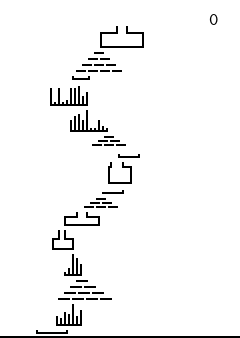

In [92]:
_ = day14_part2(puzzle.input, visualize=True)

<a name="day15"></a>
## Day 15: Beacon distances

- Part 1: In the row where y=2000000, how many positions cannot contain a beacon?

- Part 2: Find the only possible position for the distress beacon. What is its tuning frequency?

---

This is a challenging problem because the numbers are too large to allow a 2D grid solution.

In some ways it is similar to https://adventofcode.com/2018/day/23 which also involves
[cocubes](https://en.wikipedia.org/wiki/Cross-polytope);
that earlier problem seemed even harder as it was in 3D and required a `min` search.

I implement a general solution (making no assumptions and generalizable to any dimension) by reusing
the quadtree/octree/any-D recursive partitioning algorithm from that earlier 2018 problem.
The computation takes about 3 ms.

With `plotly`, we can interactively visualize the geometry of the cocubes,
and create a GIF video animation that zooms onto the unique grid cell not covered by any cocube.

In [93]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2022/day/15), `puzzle.input` has 33 lines:

Sensor at x=2302110, y=2237242: closest beacon is at x=2348729, y=1239977
Sensor at x=47903, y=2473047: closest beacon is at x=-432198, y=2000000
Sensor at x=2363579, y=1547888: closest beacon is at x=2348729, y=1239977
Sensor at x=3619841, y=520506: closest beacon is at x=2348729, y=1239977
Sensor at x=3941908, y=3526118: closest beacon is at x=3772294, y=3485243
Sensor at x=3206, y=1564595: closest beacon is at x=-432198, y=2000000
Sensor at x=3123411, y=3392077: closest beacon is at x=2977835, y=3592946
Sensor at x=3279053, y=3984688: closest beacon is at x=2977835, y=3592946
 ...
Sensor at x=2270816, y=3197807: closest beacon is at x=2017966, y=3158243
Sensor at x=3999999, y=2810929: closest beacon is at x=3998497, y=2812428
Sensor at x=3978805, y=3296024: closest beacon is at x=3772294, y=3485243
Sensor at x=1054910, y=811769: closest beacon is at x=2348729, y=1239977


The stored answers are: `{1: '5083287', 2: '13134039205729'}`

In [94]:
s1 = """\
Sensor at x=2, y=18: closest beacon is at x=-2, y=15
Sensor at x=9, y=16: closest beacon is at x=10, y=16
Sensor at x=13, y=2: closest beacon is at x=15, y=3
Sensor at x=12, y=14: closest beacon is at x=10, y=16
Sensor at x=10, y=20: closest beacon is at x=10, y=16
Sensor at x=14, y=17: closest beacon is at x=10, y=16
Sensor at x=8, y=7: closest beacon is at x=2, y=10
Sensor at x=2, y=0: closest beacon is at x=2, y=10
Sensor at x=0, y=11: closest beacon is at x=2, y=10
Sensor at x=20, y=14: closest beacon is at x=25, y=17
Sensor at x=17, y=20: closest beacon is at x=21, y=22
Sensor at x=16, y=7: closest beacon is at x=15, y=3
Sensor at x=14, y=3: closest beacon is at x=15, y=3
Sensor at x=20, y=1: closest beacon is at x=15, y=3
"""

In [95]:
# Original post.
def day15a(s, *, part2=False, y_part1=2_000_000, side_part2=4_000_000):
  tmp = np.array([list(map(int, re.findall(r'([\d-]+)', line))) for line in s.splitlines()])
  sensor, beacon = np.split(tmp, 2, axis=1)
  beacon_dist = abs(sensor - beacon).sum(1)

  if not part2:
    offset = -(sensor[:, 0] - beacon_dist).min()
    size = (sensor[:, 0] + beacon_dist + 1).max() + offset
    grid = np.full(size, False)
    for i, (x, y) in enumerate(sensor):
      radius = beacon_dist[i] - abs(y_part1 - y)
      if radius >= 0:
        grid[x - radius + offset : x + radius + offset + 1] = True

    for bx, by in beacon:
      if by == y_part1:
        grid[bx + offset] = False

    return np.count_nonzero(grid)

  xl, xh = np.array([0, 0], np.int64), np.array([side_part2] * 2, np.int64)
  stack = [(xl, xh)]

  while True:
    xl, xh = stack.pop()
    if np.all(xl == xh):
      return xl[0] * 4_000_000 + xl[1]
    xm = (xl + xh) // 2  # Partition into up to 4 quadtree child cells.
    for child_min_max in itertools.product(
        *(((l, m), (m + 1, h)) if m < h else ((l, h),) for l, m, h in zip(xl, xm, xh))
    ):
      xl, xh = np.array(child_min_max).T
      dist = (np.maximum(xh - sensor, 0) + np.maximum(sensor - xl, 0)).sum(1)
      if not np.any(dist <= beacon_dist):
        stack.append((xl, xh))


check_eq(day15a(s1, y_part1=10), 26)
puzzle.verify(1, day15a)

day15a_part2 = functools.partial(day15a, part2=True)
check_eq(day15a_part2(s1, side_part2=20), 56_000_011)
puzzle.verify(2, day15a_part2)

(Part 1: 0.003 s)
(Part 2: 0.004 s)


In [96]:
# Cleaned up.  Recursive subdivider function is much slower than stack.
def day15b(s, *, part2=False, y_part1=2_000_000, side_part2=4_000_000):
  tmp = np.array([list(map(int, re.findall(r'([\d-]+)', line))) for line in s.splitlines()])
  sensor, beacon = np.split(tmp, 2, axis=1)
  beacon_dist = abs(sensor - beacon).sum(1)

  if not part2:
    offset = -(sensor[:, 0] - beacon_dist).min()
    size = (sensor[:, 0] + beacon_dist + 1).max() + offset
    grid = np.full(size, False)
    for i, (x, y) in enumerate(sensor):
      radius = beacon_dist[i] - abs(y_part1 - y)
      if radius >= 0:
        grid[x - radius + offset : x + radius + offset + 1] = True
    num_row_beacons = len(set(x for x, y in beacon if y == y_part1))
    return np.count_nonzero(grid) - num_row_beacons

  # Recursive quadtree subdivision of an initial square, discarding any box if it is contained
  # within the cocube extent of a sensor.
  def find(low, high):
    if all(low == high):
      return low[0] * 4_000_000 + low[1]
    mid = (low + high) // 2  # Partition into child cells.
    for child_low_high in itertools.product(
        *(((l, m), (m + 1, h)) if m < h else ((l, h),) for l, m, h in zip(low, mid, high))
    ):
      low, high = np.array(child_low_high).T
      # Manhattan distance from [low, high] box to sensor.
      dist = (np.maximum(high - sensor, 0) + np.maximum(sensor - low, 0)).sum(1)
      if all(dist > beacon_dist):
        if ret := find(low, high):
          return ret
    return None

  return find(sensor[0] * 0, sensor[0] * 0 + side_part2)


check_eq(day15b(s1, y_part1=10), 26)
puzzle.verify(1, day15b)

day15b_part2 = functools.partial(day15b, part2=True)
check_eq(day15b_part2(s1, side_part2=20), 56_000_011)
if 0:
  puzzle.verify(2, day15b_part2)  # Slow.

(Part 1: 0.002 s)


day15a

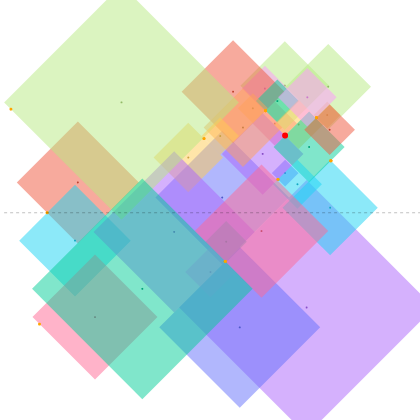

In [97]:
# Visualization.
def day15v(s, *, y_part1=2_000_000, side_part2=4_000_000):
  tmp = np.array([list(map(int, re.findall(r'([\d-]+)', line))) for line in s.splitlines()])
  sensor, beacon = np.split(tmp, 2, axis=1)
  beacon_dist = abs(sensor - beacon).sum(1)
  vmin, vmax = (sensor - beacon_dist[..., None]).min(0), (sensor + beacon_dist[..., None]).max(0)

  stack = [(sensor[0] * 0, sensor[0] * 0 + side_part2)]  # See day15().
  while True:
    low, high = stack.pop()
    if all(low == high):
      break
    mid = (low + high) // 2
    for child_low_high in itertools.product(
        *(((l, m), (m + 1, h)) if m < h else ((l, h),) for l, m, h in zip(low, mid, high))
    ):
      low, high = np.array(child_low_high).T
      dist = (np.maximum(high - sensor, 0) + np.maximum(sensor - low, 0)).sum(1)
      if all(dist > beacon_dist):
        stack.append((low, high))

  pp = low  # Solution point for Part 2.

  colors = itertools.cycle(plotly.colors.qualitative.Plotly)
  fig = go.Figure()
  for sensor1, beacon1, r, color in zip(sensor, beacon, beacon_dist, colors):
    x, y = np.array(
        [sensor1 + (dy * r, dx * r) for dy, dx in [(-1, 0), (0, -1), (1, 0), (0, 1), (-1, 0)]]
    ).T
    fig.add_trace(go.Scatter(x=x, y=y, mode='none', fill='toself', opacity=0.5, fillcolor=color))
    color2 = hex_color(*(np.array(color_from_hex(color)) * 0.8))  # type: ignore[call-overload]
    marker = dict(color=color2, size=2, opacity=1.0)
    fig.add_trace(go.Scatter(x=[sensor1[0]], y=[sensor1[1]], mode='markers', marker=marker))
    marker = dict(color='orange', size=6 if beacon1[0] == y_part1 else 3)
    fig.add_trace(go.Scatter(x=[beacon1[0]], y=[beacon1[1]], mode='markers', marker=marker))

  fig.add_trace(go.Scatter(x=[pp[0]], y=[pp[1]], mode='markers', marker=dict(color='red')))
  line = dict(color='black', width=0.25, dash='dot')
  fig.add_shape(type='line', x0=vmin[0], y0=y_part1, x1=vmax[0], y1=y_part1, line=line)

  # Overrides marker at extreme close-up.
  xys = dict(x0=pp[0] - 0.5, y0=pp[1] - 0.5, x1=pp[0] + 0.5, y1=pp[1] + 0.5)
  fig.add_shape(type='rect', **xys, line_width=0, fillcolor='red')

  fig.layout.update(
      width=500,
      height=500,
      margin=dict(l=0, r=0, b=0, t=0),
      plot_bgcolor='white',
      showlegend=False,
      hovermode=False,
      dragmode='pan',
  )
  fig.update_yaxes(scaleanchor='x', scaleratio=1.0)  # Preserve aspect ratio!
  fig.layout.xaxis.visible = fig.layout.yaxis.visible = False  # For smooth scroll-zooming.

  if SHOW_BIG_MEDIA and hh.in_notebook():
    hh.display_html('Interactively control the viewpoint by dragging or scrolling:')
    config = dict(
        scrollZoom=True,
        displaylogo=False,
        modeBarButtonsToRemove='select lasso2d'.split(),
    )
    fig.show(config=config)

  if 1:
    image = hh.image_from_plotly(fig)[40:-40, 40:-40]
    media.show_image(image, border=True, title='day15a')

  if SHOW_BIG_MEDIA:
    images = []
    while (diam := (vmax - vmin).astype(float)).min() > 6:
      fig.layout.xaxis.range = [vmin[0], vmax[0]]
      fig.layout.yaxis.range = [vmin[1], vmax[1]]
      images.append(hh.image_from_plotly(fig)[40:-40, 40:-40])
      scale = 0.97 if len(images) < 16 else 0.92 if min(vmax - vmin) > 110_000 else 0.70
      pp_norm = (pp - vmin) / (vmax - vmin)
      assert 0 <= pp_norm[0] <= 1 and 0 <= pp_norm[1] <= 1, pp_norm
      alpha = 0.96  # Geometric progression of pp towards center of window.
      diam = vmax - vmin
      offset = (pp_norm - scale * (alpha * (pp_norm - 0.5) + 0.5)) * diam
      vmin = vmin + offset
      vmax = vmin + diam * scale
      assert len(images) < 400
    images = [images[0]] * 30 + images + [images[-1]] * 20
    media.show_video(images, codec='gif', fps=15, title='day15b')

  hh.no_vertical_scroll()


day15v(puzzle.input)

Cached result:<br/>
<img src="results/day15b.gif"/>

In [98]:
# Compact and fast; Part 1 assumes contiguous line covering; Part 2 works in any dimension.
def day15(s, *, part2=False, y_part1=2_000_000, side_part2=4_000_000):
  tmp = np.array(
      [list(map(int, re.findall(r'([\d-]+)', line))) for line in s.splitlines()], np.int64
  )
  sensor, beacon = np.split(tmp, 2, axis=1)
  beacon_dist = abs(sensor - beacon).sum(1)

  if not part2:
    # Radius of intersection along line y==y_part1 for each sensor.
    radius = beacon_dist - abs(y_part1 - sensor[:, 1])
    sensor2x, radius2 = sensor[:, 0][radius >= 0], radius[radius >= 0]
    xmin, xmax = (sensor2x - radius2).min(), (sensor2x + radius2).max()
    num_row_beacons = len(set(x for x, y in beacon if y == y_part1))
    return xmax - xmin + 1 - num_row_beacons

  # Recursive quadtree subdivision of an initial square, discarding any box if it is contained
  # within the cocube extent of a sensor.
  stack = [(sensor[0] * 0, sensor[0] * 0 + side_part2)]
  while True:
    low, high = stack.pop()
    if all(low == high):
      return low[0] * 4_000_000 + low[1]
    mid = (low + high) // 2  # Partition into child cells.
    for child_low_high in itertools.product(
        *(((l, m), (m + 1, h)) if m < h else ((l, h),) for l, m, h in zip(low, mid, high))
    ):
      low, high = np.array(child_low_high).T
      # Manhattan distance from [low, high] box to sensor.
      dist = (np.maximum(high - sensor, 0) + np.maximum(sensor - low, 0)).sum(1)
      if all(dist > beacon_dist):
        stack.append((low, high))


check_eq(day15(s1, y_part1=10), 26)
puzzle.verify(1, day15)

day15_part2 = functools.partial(day15, part2=True)
check_eq(day15_part2(s1, side_part2=20), 56_000_011)
puzzle.verify(2, day15_part2)

(Part 1: 0.000 s)
(Part 2: 0.003 s)


<a name="day16"></a>
## Day 16: Activate valves

- Part 1: Work out the steps to release the most pressure in 30 minutes. What is the most pressure you can release?

- Part 2: With you and an elephant working together for 26 minutes, what is the most pressure you could release?

---

This may have been the most difficult problem this year.

It is similar to https://adventofcode.com/2019/day/18 in that there are a set of objectives
that are separated by "empty" nodes, and Part 2 involves multiple workers to reach the objectives.

As in that earlier problem, it is beneficial to precompute distances to the objectives,
rather than advancing iteratively through the empty nodes in the main search.

- `day16a()`: The initial solution uses a depth-first search and requires about 3 minutes of
  computation for Part 2.
  It involves as state: the position of the two workers, the subset of enabled valves, with worker
  0 being idle and worker 1 still needed `other_working` time.

- `day16d()`: The search is accelerated using branch-and-bound pruning and heuristically ordering edges
  to more quickly find good first solutions.

- `day16e()`: The search is further accelerated using heuristic pruning; an optimal solution is
  still found although this is no longer guaranteed.

- `day16()`: A hack is to determine the optimal node activation sequence for one worker,
  then do the same for the second worker using the remaining available nodes.
  Although this fails on the example data, it does work on the puzzle input.

Using `matplotlib` (and optional improved graph layout by `graphviz`), we create a video GIF that
animates the traversal by the workers and the activation of the valves.
This builds on a [reddit algorithm](https://www.reddit.com/r/adventofcode/comments/zn6k1l/comment/j0fti6c/)
which is adapted to memoize not just the best objective value but also the best path.

In [99]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2022/day/16), `puzzle.input` has 58 lines:

Valve YK has flow rate=0; tunnels lead to valves GL, FT
Valve QA has flow rate=0; tunnels lead to valves JX, FD
Valve LN has flow rate=0; tunnels lead to valves FD, FG
Valve AU has flow rate=0; tunnels lead to valves BD, PQ
Valve MM has flow rate=0; tunnels lead to valves UL, AA
Valve JX has flow rate=0; tunnels lead to valves QA, NZ
Valve CV has flow rate=0; tunnels lead to valves UP, QW
Valve UZ has flow rate=0; tunnels lead to valves FG, NZ
 ...
Valve ZO has flow rate=0; tunnels lead to valves RZ, CH
Valve QX has flow rate=0; tunnels lead to valves AB, SG
Valve BO has flow rate=0; tunnels lead to valves IN, DX
Valve OW has flow rate=0; tunnels lead to valves AT, ML


The stored answers are: `{1: '2029', 2: '2723'}`

In [100]:
s1 = """\
Valve AA has flow rate=0; tunnels lead to valves DD, II, BB
Valve BB has flow rate=13; tunnels lead to valves CC, AA
Valve CC has flow rate=2; tunnels lead to valves DD, BB
Valve DD has flow rate=20; tunnels lead to valves CC, AA, EE
Valve EE has flow rate=3; tunnels lead to valves FF, DD
Valve FF has flow rate=0; tunnels lead to valves EE, GG
Valve GG has flow rate=0; tunnels lead to valves FF, HH
Valve HH has flow rate=22; tunnel leads to valve GG
Valve II has flow rate=0; tunnels lead to valves AA, JJ
Valve JJ has flow rate=21; tunnel leads to valve II
"""

In [101]:
def day16a(s, *, part2=False):  # First solution; DFS; no pruning; very slow on Part 2.
  rate, dsts = {}, {}
  for line in s.splitlines():
    node, s_rate, *dsts[node] = re.findall(r'([A-Z]{2}|\d+)', line)
    rate[node] = int(s_rate)
  assert rate['AA'] == 0  # Stated in problem.

  @functools.cache
  def possible_paths(node):  # BFS to return [(node2, time) if rate[node2] > 0].
    queue = collections.deque([(0, node)])
    result = {}
    while queue:
      distance, node = queue.popleft()
      for node2 in dsts[node]:
        if node2 not in result:
          result[node2] = distance + 2  # Add extra 1 for "time to turn on the valve".
          queue.append((distance + 1, node2))
    return [(node, time) for node, time in result.items() if rate[node] > 0]

  # Given workers located at `nodes`, with a subset of `enabled` nodes, worker 0 idle,
  # and worker 1 still needing `other_working` time, compute the maximum benefit.
  def compute_benefit(time_left, enabled, nodes, other_working):
    benefit = 0
    for dst, time in possible_paths(nodes[0]):
      if dst not in enabled and time <= time_left:
        nodes2, time_left2, other_working2 = (
            ((nodes[1], dst), time_left - other_working, time - other_working)
            if other_working < time
            else ((dst, nodes[1]), time_left - time, other_working - time)
        )
        remaining = compute_benefit(time_left2, enabled | {dst}, nodes2, other_working2)
        candidate = (time_left - time) * rate[dst] + remaining
        benefit = max(benefit, candidate)
    if other_working < time_left:  # This branch is necessary only on some inputs.
      benefit = max(benefit, compute_benefit(time_left - other_working, enabled, nodes[::-1], 99))
    return benefit

  return compute_benefit(26 if part2 else 30, set(), ('AA', 'AA'), 0 if part2 else 99)


check_eq(day16a(s1), 1651)
puzzle.verify(1, day16a)

day16a_part2 = functools.partial(day16a, part2=True)
check_eq(day16a_part2(s1), 1707)
# puzzle.verify(2, day16a_part2)  # 178 or 430 s.

(Part 1: 0.155 s)


In [102]:
# Noteworthy 20-liner: https://www.reddit.com/r/adventofcode/comments/zn6k1l/comment/j0fti6c/
def day16b(s, *, part2=False):
  V, F, D = set(), {}, collections.defaultdict(lambda: 1000)

  for v, f, us in re.findall(r'Valve (\w+) .*=(\d*); .* valves? (.*)', s):
    V.add(v)
    if f != '0':
      F[v] = int(f)  # Flow rate.
    for u in us.split(', '):
      D[u, v] = 1  # Distance.

  for k, i, j in itertools.product(V, V, V):  # Floyd-Warshall.
    D[i, j] = min(D[i, j], D[i, k] + D[k, j])

  @functools.cache
  def search(t, u='AA', vs=frozenset(F), e=False):
    return max(
        [
            F[v] * (t - D[u, v] - 1) + search(t - D[u, v] - 1, v, vs - {v}, e)
            for v in vs
            if D[u, v] < t
        ]
        + [search(26, vs=vs) if e else 0]
    )

  return search(26, e=True) if part2 else search(30)


check_eq(day16b(s1), 1651)
puzzle.verify(1, day16b)  # ~0.2 s.

day16b_part2 = functools.partial(day16b, part2=True)
check_eq(day16b_part2(s1), 1707)
# puzzle.verify(2, day16b_part2)  # ~15-18 s.

(Part 1: 0.192 s)


In [103]:
# Adapted for visualization.
def day16c(s, *, part2=False, visualize=False, only_last_frame=False, start='AA'):
  rate, dsts = {}, {}
  for line in s.splitlines():
    node, s_rate, *dsts[node] = re.findall(r'([A-Z]{2}|\d+)', line)
    rate[node] = int(s_rate)
  valves = {node: rate for node, rate in rate.items() if rate > 0}

  def distance_and_prev(node):  # BFS to return {node2: distance} and {node2: node_prev}
    queue = collections.deque([(0, node)])
    distance, prev = {}, {}
    while queue:
      dist, node = queue.popleft()
      for node2 in dsts[node]:
        if node2 not in distance:
          distance[node2] = dist + 2  # Add extra 1 for "time to turn on the valve".
          prev[node2] = node
          queue.append((dist + 1, node2))
    return distance, prev

  @functools.cache
  def valve_distance(node):
    return {node2: dist for node2, dist in distance_and_prev(node)[0].items() if rate[node2] > 0}

  @functools.cache
  def search(t, u=start, vs=frozenset(valves), e=False):
    return max(
        [
            (rate[v] * (t - distance) + search(t - distance, v, vs - {v}, e)[0], v)
            for v, distance in valve_distance(u).items()
            if distance < t and v in vs
        ]
        + [(search(26, vs=vs)[0], '') if e else (0, '')]
    )

  def get_path(path, t, u=start, vs=frozenset(valves), e=False):
    v = search(t, u, vs=vs, e=e)[1]
    return get_path(path + [v], t - valve_distance(u)[v], v, vs - {v}, e) if v else (path, vs)

  graph = networkx.Graph()
  for node, dsts1 in dsts.items():
    rate1 = rate[node]
    graph.add_node(node, label=f'{node}\n{rate1}')
    for dst in dsts1:
      graph.add_edge(node, dst)

  pos = hh.graph_layout(graph, prog='dot')

  if visualize:
    fig, ax = plt.subplots(figsize=(16, 12), dpi=66)
    ax.set_aspect('equal')  # Preserve aspect ratio.

  time = 26 if part2 else 30
  paths = {}
  paths[0], vs = get_path([], time, e=part2)
  if part2:
    paths[1], _ = get_path([], time, vs=vs)
  current = {worker: start for worker in paths}
  to_visit: dict[int, list[str]] = {worker: [] for worker in paths}
  enabled_valves = set[str]()
  total_flow = 0
  images = []

  def get_color(node):
    there = [current.get(worker, '') == node for worker in range(2)]
    return (
        'plum'
        if all(there)
        else 'lightblue'
        if there[0]
        else 'lightgreen'
        if there[1]
        else '#F0F0F0'
        if node == start
        else 'white'
    )

  for time_index in range(time):
    if visualize and (not only_last_frame or time_index == time - 1):
      ax.clear()
      labels = networkx.get_node_attributes(graph, 'label')
      node_size = [2400 if rate[node] else 1500 for node in graph]
      node_color = [get_color(node) for node in graph]
      linewidths = [6 if node in valves else 1 for node in graph]
      edgecolors = [
          'tomato' if node in enabled_valves else 'gray' if node in valves else 'black'
          for node in graph
      ]
      params: Any = dict(node_size=node_size, node_color=node_color, width=0.8)
      params |= dict(labels=labels, font_family='sans-serif', font_size=14)
      params |= dict(linewidths=linewidths, edgecolors=edgecolors)
      params |= dict(ax=ax, margins=0.07)
      networkx.draw(graph, pos, **params)
      fig.tight_layout(pad=0)
      image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
      text = f'Time {time_index + 1:2}'
      hh.overlay_text(image, (8, 400), text, fontsize=20, background=255)
      images.append(image)

    total_flow += sum(rate[valve] for valve in enabled_valves)
    for worker, path in paths.items():
      node = current[worker]
      if not to_visit[worker] and node in valves and node not in enabled_valves:
        enabled_valves.add(node)
        continue  # It takes one time unit to turn on the valve.
      if not to_visit[worker] and path:
        dst = path.pop(0)
        while dst != node:
          to_visit[worker].append(dst)
          dst = distance_and_prev(node)[1][dst]
      if to_visit[worker]:
        current[worker] = to_visit[worker].pop()

  if visualize:
    plt.close(fig)
    images = [images[0]] * 4 + images + [images[-1]] * 8
    return images

  return total_flow


check_eq(day16c(s1), 1651)
# puzzle.verify(1, day16c)  # ~0.4 s.

day16c_part2 = functools.partial(day16c, part2=True)
check_eq(day16c_part2(s1), 1707)
# puzzle.verify(2, day16c_part2)  # ~16 s.

day16a

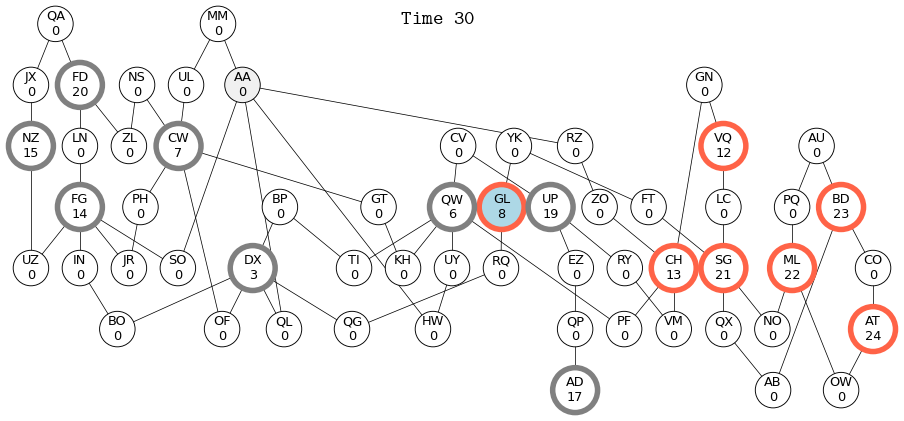

In [104]:
media.show_image(
    day16c(puzzle.input, visualize=True, only_last_frame=True)[0], border=True, title='day16a'
)

In [105]:
if SHOW_BIG_MEDIA:  # Slow due to search(); ~16 s.
  media.show_video(
      day16c_part2(puzzle.input, visualize=True), codec='gif', fps=2, border=True, title='day16b'
  )

Cached result:<br/>
<img src="results/day16b.gif"/>

In [106]:
def day16d(s, *, part2=False):  # Heuristically order edges and add branch-and-bound pruning.
  rate, dsts = {}, {}
  for line in s.splitlines():
    node, s_rate, *dsts[node] = re.findall(r'([A-Z]{2}|\d+)', line)
    rate[node] = int(s_rate)
  best_benefit_found = 0

  @functools.cache
  def possible_paths(node):  # BFS to return [(node2, time) if rate[node2] > 0].
    queue = collections.deque([(0, node)])
    result = {}
    while queue:
      distance, node = queue.popleft()
      for node2 in dsts[node]:
        if node2 not in result:
          result[node2] = distance + 2  # Add extra 1 for "time to turn on the valve".
          queue.append((distance + 1, node2))
    result2 = [(node, time) for node, time in result.items() if rate[node] > 0]
    result2 = sorted(result2, key=lambda t: rate[t[0]] / t[1], reverse=True)
    return result2

  # Given workers located at `nodes`, with a subset of `enabled` nodes, worker 0 idle,
  # and worker 1 still needing `other_working` time, update the maximum benefit.
  # Adding "@functools.lru_cache(maxsize=100_000)" here increases solution time.
  def consider_benefit(cur_benefit, time_left, enabled, nodes, other_working):
    nonlocal best_benefit_found
    remaining = sum(
        (time_left - t) * rate[n] for n, t in possible_paths(nodes[0]) if t < time_left
    ) + sum(
        (time_left - other_working - t) * rate[n]
        for n, t in possible_paths(nodes[0])
        if t < time_left - other_working
    )
    if cur_benefit + remaining <= best_benefit_found:  # Branch-and-bound pruning.
      return

    for dst, time in possible_paths(nodes[0]):
      if dst not in enabled and time < time_left:
        cur_benefit2 = cur_benefit + (time_left - time) * rate[dst]
        best_benefit_found = max(best_benefit_found, cur_benefit2)
        nodes2, time_left2, other_working2 = (
            ((nodes[1], dst), time_left - other_working, time - other_working)
            if other_working < time
            else ((dst, nodes[1]), time_left - time, other_working - time)
        )
        consider_benefit(cur_benefit2, time_left2, enabled | {dst}, nodes2, other_working2)
    if other_working < time_left:
      if cur_benefit + (time_left - other_working) * 30 > best_benefit_found:  # Branch-and-bound.
        consider_benefit(cur_benefit, time_left - other_working, enabled, nodes[::-1], 99)

  consider_benefit(0, 26 if part2 else 30, set(), ('AA', 'AA'), 0 if part2 else 99)
  return best_benefit_found


check_eq(day16d(s1), 1651)
puzzle.verify(1, day16d)

day16d_part2 = functools.partial(day16d, part2=True)
check_eq(day16d_part2(s1), 1707)
# puzzle.verify(2, day16d_part2)  # ~7.8 or 20 s.

(Part 1: 0.034 s)


In [107]:
def day16e(s, *, part2=False):  # Heuristically order edges and add heuristic pruning.
  rate, dsts = {}, {}
  for line in s.splitlines():
    node, s_rate, *dsts[node] = re.findall(r'([A-Z]{2}|\d+)', line)
    rate[node] = int(s_rate)
  best_benefit_found = 0

  @functools.cache
  def possible_paths(node):  # BFS to return [(node2, time) if rate[node2] > 0].
    queue = collections.deque([(0, node)])
    result = {}
    while queue:
      distance, node = queue.popleft()
      for node2 in dsts[node]:
        if node2 not in result:
          result[node2] = distance + 2  # Add extra 1 for "time to turn on the valve".
          queue.append((distance + 1, node2))
    result2 = [(node, time) for node, time in result.items() if rate[node] > 0]
    result2 = sorted(result2, key=lambda t: rate[t[0]] / t[1], reverse=True)
    return result2

  # Given workers located at `nodes`, with a subset of `enabled` nodes, worker 0 idle,
  # and worker 1 still needing `other_working` time, update the maximum benefit.
  def consider_benefit(cur_benefit, time_left, enabled, nodes, other_working):
    nonlocal best_benefit_found
    for dst, time in possible_paths(nodes[0]):
      if dst not in enabled and time < time_left:
        cur_benefit2 = cur_benefit + (time_left - time) * rate[dst]
        best_benefit_found = max(best_benefit_found, cur_benefit2)
        per_time = 45 if part2 else 55  # For my puzzle inputs, min are (40, 51) and (44, 49).
        optimistic_remaining = (time_left - time + max(time_left - other_working, 0) + 3) * per_time
        if cur_benefit2 + optimistic_remaining <= best_benefit_found:  # Branch-and-bound pruning.
          continue
        nodes2, time_left2, other_working2 = (
            ((nodes[1], dst), time_left - other_working, time - other_working)
            if other_working < time
            else ((dst, nodes[1]), time_left - time, other_working - time)
        )
        consider_benefit(cur_benefit2, time_left2, enabled | {dst}, nodes2, other_working2)
    if other_working < time_left:
      if cur_benefit + (time_left - other_working) * 30 > best_benefit_found:  # Branch-and-bound.
        consider_benefit(cur_benefit, time_left - other_working, enabled, nodes[::-1], 99)

  consider_benefit(0, 26 if part2 else 30, set(), ('AA', 'AA'), 0 if part2 else 99)
  return best_benefit_found


check_eq(day16e(s1), 1651)
puzzle.verify(1, day16e)

day16e_part2 = functools.partial(day16e, part2=True)
check_eq(day16e_part2(s1), 1707)
puzzle.verify(2, day16e_part2)  # ~0.15 or 0.54 s.

(Part 1: 0.005 s)
(Part 2: 0.150 s)


In [108]:
# Determine the optimal node activation sequence for one worker, then do the same for the second
# worker using the remaining available nodes.  Although this fails on the example data, it seems
# to work on the puzzle input!
def day16(s, *, part2=False):
  rate, dsts = {}, {}
  for line in s.splitlines():
    node, s_rate, *dsts[node] = re.findall(r'([A-Z]{2}|\d+)', line)
    rate[node] = int(s_rate)
  best_benefit_found = 0
  best_nodes_found = set()

  @functools.cache
  def possible_paths(node):  # BFS to return {node2: time if rate[node2] > 0}.
    queue = collections.deque([(0, node)])
    result = {}
    while queue:
      distance, node = queue.popleft()
      for node2 in dsts[node]:
        if node2 not in result:
          result[node2] = distance + 2  # Add extra 1 for "time to turn on the valve".
          queue.append((distance + 1, node2))
    return [(node, time) for node, time in result.items() if rate[node] > 0]

  def consider_benefit(benefit, time_left, enabled, node):
    nonlocal best_benefit_found, best_nodes_found
    for dst, time in possible_paths(node):
      if dst not in enabled and time <= time_left:
        time_left2 = time_left - time
        benefit2 = benefit + time_left2 * rate[dst]
        if benefit2 > best_benefit_found:
          best_benefit_found = benefit2
          best_nodes_found = enabled | {dst}
        if benefit2 + time_left2 * 60 > best_benefit_found:  # Branch-and-bound pruning.
          consider_benefit(benefit2, time_left2, enabled | {dst}, dst)

  consider_benefit(0, 26 if part2 else 30, set(), 'AA')
  if part2:
    consider_benefit(best_benefit_found, 26, best_nodes_found, 'AA')
  return best_benefit_found


check_eq(day16(s1), 1651)
puzzle.verify(1, day16)

day16_part2 = functools.partial(day16, part2=True)
# check_eq(day16_part2(s1), 1707)  # This algorithm fails on the example data!
puzzle.verify(2, day16_part2)

(Part 1: 0.003 s)
(Part 2: 0.003 s)


In [109]:
# Explore a BFS/queue approach and prune the set of states?

In [110]:
# Dynamic programming in Rust: https://www.reddit.com/r/adventofcode/comments/zn6k1l/comment/j0gmocd/

<a name="day17"></a>
## Day 17: Tetris

- Part 1: How many units tall will the tower of rocks be after 2022 rocks have stopped falling?

- Part 2: How tall will the tower be after 1000000000000 rocks have stopped?

---

A nice approach is to represent the 2D grid using `numpy` and use boolean operations (`&` and `|`)
on 2D windows to test for shape overlap and perform shape insertion.

Efficiently solving Part 2 requires finding a cycle in the insertion process,
i.e. two states that are effectively identical, and then extrapolate the growth of the tower height.
The challenge is to precisely encode this state, i.e., the position in the cyclic jet pattern and
the configuration of "some upper part of the tower".
My approach is to avoid a complex state encoding and instead look for a long repeating subsequence of
increments (deltas) in the height of the tower &mdash; as in the end this is really what we seek.

We explore four methods for efficiently matching the repeating subsequence:

1. brute-force `list`-based,

2. brute-force `numpy`-based using `np.lib.stride_tricks.as_strided()`,

3. FFT-based `scipy.signal.correlate()`, and

4. Subsequence search using the
   [Boyer-Moore-Horspool algorithm](https://en.wikipedia.org/wiki/Boyer-Moore-Horspool_algorithm).

For the subsequence size in this problem, method 4 (Boyer-Moore-Horspool search) is fastest.

In [111]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2022/day/17), `puzzle.input` has a single line of 10_091 characters:

>>><<<>>><<<>><<>><<>>>><>>>><><<><<<>>>><<<>>>><<<>><><><><<><<<>><>>><>>>><<>> ... ><>>>><<<>><<<<>><>>><<>>><<<>>><>>


The stored answers are: `{1: '3144', 2: '1565242165201'}`

In [112]:
s1 = '>>><<><>><<<>><>>><<<>>><<<><<<>><>><<>>'

In [113]:
def day17a(s, *, part2=False, num=10**12, rocks_in_part2=8_000):
  rocks0 = [
      [[1, 1, 1, 1]],
      [[0, 1, 0], [1, 1, 1], [0, 1, 0]],
      [[0, 0, 1], [0, 0, 1], [1, 1, 1]],
      [[1], [1], [1], [1]],
      [[1, 1], [1, 1]],
  ]
  rocks = [np.array(rock, bool)[::-1] for rock in rocks0]
  num_rocks = rocks_in_part2 if part2 else 2022
  grid = np.full((num_rocks * 4, 7), False)  # (y=0 is at bottom.)
  heights = [0]
  jet_iterator = itertools.cycle(s.strip())

  for rock in itertools.islice(itertools.cycle(rocks), num_rocks):
    ry, rx = rock.shape
    y, x = heights[-1] + 3, 2
    while True:
      dx = {'<': -1, '>': 1}[next(jet_iterator)]
      if (
          x + dx >= 0
          and x + dx + rx <= 7
          and not (grid[y : y + ry, x + dx : x + dx + rx] & rock).any()
      ):
        x += dx
      if y > 0 and not (grid[y - 1 : y - 1 + ry, x : x + rx] & rock).any():
        y -= 1
      else:
        grid[y : y + ry, x : x + rx] |= rock
        heights.append(max(heights[-1], y + ry))
        break

  if not part2:
    return heights[-1]

  # Find a repeating sequence of height deltas, starting from the end.
  deltas = np.diff(heights)
  tail = deltas[-rocks_in_part2 // 3 :]
  # If the next line fails, increase `rocks_in_part2`.
  i0, i1, *_ = [
      i for i in range(len(deltas) - len(tail) + 1) if all(deltas[i : i + len(tail)] == tail)
  ]
  h0, h1 = heights[i0], heights[i1]
  # hh.show(i0, i1, h0, h1)  # i0 = 1823, i1 = 3578, h0 = 2817, h1 = 5564
  div, mod = divmod(num - i0, i1 - i0)
  return heights[i0 + mod] + div * (h1 - h0)


check_eq(day17a(s1), 3068)
puzzle.verify(1, day17a)

day17a_part2 = functools.partial(day17a, part2=True)
check_eq(day17a_part2(s1), 1514285714288)
puzzle.verify(2, day17a_part2)

(Part 1: 0.047 s)
(Part 2: 0.193 s)


In [114]:
# Faster using numba (10x) and efficient subsequence matching (2x).
@numba.njit
def day17_drop(grid, rock, y, x, jet, jet_index):
  ry, rx = rock.shape
  while True:
    dx = jet[jet_index[0]]
    jet_index[0] = (jet_index[0] + 1) % len(jet)
    if (
        x + dx >= 0
        and x + dx + rx <= 7
        and not (grid[y : y + ry, x + dx : x + dx + rx] & rock).any()
    ):
      x += dx
    if y > 0 and not (grid[y - 1 : y - 1 + ry, x : x + rx] & rock).any():
      y -= 1
    else:
      grid[y : y + ry, x : x + rx] |= rock
      return y + ry


def day17(s, *, part2=False, num=10**12, rocks_in_part2=8_000):
  rocks0 = [
      [[1, 1, 1, 1]],
      [[0, 1, 0], [1, 1, 1], [0, 1, 0]],
      [[0, 0, 1], [0, 0, 1], [1, 1, 1]],
      [[1], [1], [1], [1]],
      [[1, 1], [1, 1]],
  ]
  rocks = [np.array(rock, bool)[::-1] for rock in rocks0]
  num_rocks = rocks_in_part2 if part2 else 2022
  grid = np.full((num_rocks * 4, 7), False)  # (y=0 is at bottom.)
  heights = [0]
  jet = 1 - (np.array(list(s.strip())) == '<') * 2
  jet_index = np.array([0])

  for rock in itertools.islice(itertools.cycle(rocks), num_rocks):
    y, x = heights[-1] + 3, 2
    height = day17_drop(grid, rock, y, x, jet, jet_index)
    heights.append(max(heights[-1], height))

  if not part2:
    return heights[-1]

  # Find a repeating sequence of height deltas, starting from the end.
  deltas = np.diff(heights)
  seqn = rocks_in_part2 // 3
  # In the following methods, if the assignment to (i0, i1) fails, increase `rocks_in_part2`.
  if 0:
    i0, i1, *_ = [
        i for i in range(len(deltas) - seqn + 1) if all(deltas[i : i + seqn] == deltas[-seqn:])
    ]
  elif 0:
    a = np.lib.stride_tricks.as_strided(
        deltas, shape=(len(deltas) - seqn + 1, seqn), strides=[deltas.strides[0]] * 2
    )
    ((i0, i1, *_),) = np.nonzero((a == deltas[-seqn:]).all(1))
  elif 0:
    deltas2 = deltas - deltas.mean()
    corr = scipy.signal.correlate(deltas2, deltas2[-seqn:], mode='valid')
    i0, i1 = np.nonzero(corr > corr.std() * 2.5)[0][-2:]  # This seems too fuzzy.
  else:
    i0 = hh.boyer_subsequence_find(deltas[:-1], deltas[-seqn:])
    assert i0 >= 0
    i1 = len(deltas) - seqn

  h0, h1 = heights[i0], heights[i1]
  div, mod = divmod(num - i0, i1 - i0)
  return heights[i0 + mod] + div * (h1 - h0)


check_eq(day17(s1), 3068)
puzzle.verify(1, day17)

day17_part2 = functools.partial(day17, part2=True)
check_eq(day17_part2(s1), 1514285714288)
puzzle.verify(2, day17_part2)

(Part 1: 0.003 s)
(Part 2: 0.009 s)


day17

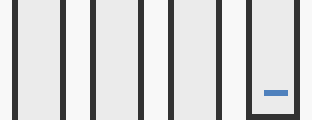

In [115]:
def day17_visualize(s, *, num_cols=4, num_rows=20, size=6):
  rocks0 = [
      [[1, 1, 1, 1]],
      [[0, 1, 0], [1, 1, 1], [0, 1, 0]],
      [[0, 0, 1], [0, 0, 1], [1, 1, 1]],
      [[1], [1], [1], [1]],
      [[1, 1], [1, 1]],
  ]
  rocks = [np.array(rock, bool)[::-1] for rock in rocks0]
  jet_iterator = itertools.cycle(s.strip())
  extra_height = 12
  grid_height = num_cols * num_rows - 1 + extra_height
  grid = np.full((grid_height, 7), '.')  # (y=0 is at bottom.)
  height = 0
  images: Any = []

  def add_rock_and_append_image(grid, y, x, rock):
    (rock_index,) = [i for i, r in enumerate(rocks) if r.shape == rock.shape and (r == rock).all()]
    grid[y : y + rock.shape[0], x : x + rock.shape[1]][rock] = chr(ord('0') + rock_index)
    grid = np.pad(grid[:-extra_height], 1, constant_values='W')[:-1]
    grid = np.pad(grid, ((0, 0), (2, 2)), constant_values=' ')
    grid = grid[::-1].reshape(num_cols, num_rows, -1).transpose(1, 0, 2).reshape(num_rows, -1)
    cmap = {
        ' ': (248,) * 3,
        '.': (235,) * 3,
        'W': (50,) * 3,
        '0': (79, 129, 189),
        '1': (192, 80, 77),
        '2': (155, 187, 89),
        '3': (128, 100, 162),
        '4': (75, 172, 198),
        '5': (247, 150, 70),
    }
    image = np.array([cmap[e] for e in grid.flat], np.uint8).reshape(*grid.shape, 3)
    images.append(image.repeat(size, axis=0).repeat(size, axis=1))

  for rock in itertools.cycle(rocks):
    ry, rx = rock.shape
    y, x = height + 3, 2
    if y + ry > grid.shape[0]:
      break
    add_rock_and_append_image(grid.copy(), y, x, rock)
    while True:
      dx = {'<': -1, '>': 1}[next(jet_iterator)]
      if (
          x + dx >= 0
          and x + dx + rx <= 7
          and not (grid[y : y + ry, x + dx : x + dx + rx][rock] != '.').any()
      ):
        x += dx
        add_rock_and_append_image(grid.copy(), y, x, rock)
      if y > 0 and not (grid[y - 1 : y - 1 + ry, x : x + rx][rock] != '.').any():
        y -= 1
        add_rock_and_append_image(grid.copy(), y, x, rock)
      else:
        add_rock_and_append_image(grid, y, x, rock)
        height = max(height, y + ry)
        break

  images = [images[0] * 1] + images + [images[-1]] * 50
  media.show_video(images, codec='gif', fps=50, title='day17')


day17_visualize(s1)

<a name="day18"></a>
## Day 18: Surface area of cubes

- Part 1: What is the surface area of your scanned lava droplet?

- Part 2: What is the exterior surface area of your scanned lava droplet?

---

For this problem, two natural representations for the cubes are a `set` or a 3D grid (`np.ndarray`).
Because all the cube coordinates are small, I chose a 3D grid.

Here are the approaches considered, in order of increasing speed:

- `day18a()`: Python iteration over each cube and its neighbors (using a generator), and depth-first traversal
  to mark exterior cubes for Part 2.

- `day18b()`: Use of a 3D array (`np.array([np.roll(grid, ...])`) to access grid neighbors.

- `day18w()`: Elegant, compact
  [solution from mjpieters](https://github.com/mjpieters/adventofcode/blob/master/2022/Day%2018.ipynb)
  involving `scipy.ndimage.binary_fill_holes` and `scipy.signal.convolve`.

- `day18()`: Incremental march over just the outer surface of the cubes, jitted using `numba`.

We visualize the cubes in 3D using `matplotlib`'s  `Axes3D.voxels` and
interactively using `plotly`.

In [116]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2022/day/18), `puzzle.input` has 2_025 lines:

10,17,7
8,14,15
15,5,5
17,7,13
6,6,15
9,1,11
15,11,16
11,5,3
 ...
10,4,13
6,9,1
5,17,7
15,11,3


The stored answers are: `{1: '3650', 2: '2118'}`

In [117]:
s1 = """\
2,2,2
1,2,2
3,2,2
2,1,2
2,3,2
2,2,1
2,2,3
2,2,4
2,2,6
1,2,5
3,2,5
2,1,5
2,3,5
"""

In [118]:
def day18a(s, *, part2=False):  # DFS to fill all exterior cubes.
  cubes = np.array([line.split(',') for line in s.splitlines()], int) + 1
  shape = tuple(cubes.max(0) + 2)
  grid = np.full(shape, False)
  grid[tuple(cubes.T)] = True

  def adjacent(p):
    x, y, z = p
    if x > 0:
      yield x - 1, y, z
    if x < grid.shape[0] - 1:
      yield x + 1, y, z
    if y > 0:
      yield x, y - 1, z
    if y < grid.shape[1] - 1:
      yield x, y + 1, z
    if z > 0:
      yield x, y, z - 1
    if z < grid.shape[2] - 1:
      yield x, y, z + 1

  if not part2:
    return sum(1 for p in np.argwhere(grid) for p2 in adjacent(p) if not grid[p2])

  # Depth-first traversal to fill all outside cubes.
  outside = np.full_like(grid, False)
  stack = [(0, 0, 0)]
  while stack:
    p = stack.pop()
    for p2 in adjacent(p):
      if not outside[p2] and not grid[p2]:
        outside[p2] = True
        stack.append(p2)

  return sum(1 for p in np.argwhere(grid) for p2 in adjacent(p) if outside[p2])


check_eq(day18a(s1), 64)
puzzle.verify(1, day18a)

day18a_part2 = functools.partial(day18a, part2=True)
check_eq(day18a_part2(s1), 58)
puzzle.verify(2, day18a_part2)

(Part 1: 0.005 s)
(Part 2: 0.014 s)


In [119]:
# def adjacent(p):  # Too slow.
#   for dp in dps:
#     p2 = p + dp
#     if all(0 <= v < m for v, m in zip(p2, grid.shape)):
#       yield tuple(p2)

In [120]:
# Fill all exterior; vectorized neighbors.
def day18b(s, *, part2=False, visualize=False, magnify=8):
  cubes = np.array([line.split(',') for line in s.splitlines()], int) + 1
  shape = tuple(cubes.max(0) + 2)
  grid = np.full(shape, False)
  grid[tuple(cubes.T)] = True
  dps = np.concatenate([[v, -v] for v in np.eye(grid.ndim, dtype=int)])
  neighbors = np.array([np.roll(grid, dp, range(grid.ndim)) for dp in dps])

  if not part2:
    return (grid & ~neighbors).sum()

  def adjacent(p):
    x, y, z = p
    if x > 0:
      yield x - 1, y, z
    if x < grid.shape[0] - 1:
      yield x + 1, y, z
    if y > 0:
      yield x, y - 1, z
    if y < grid.shape[1] - 1:
      yield x, y + 1, z
    if z > 0:
      yield x, y, z - 1
    if z < grid.shape[2] - 1:
      yield x, y, z + 1

  # Depth-first traversal to fill all outside cubes.
  outside = np.full_like(grid, False)
  stack = [(0, 0, 0)]
  while stack:
    p = stack.pop()
    for p2 in adjacent(p):
      if not outside[p2] and not grid[p2]:
        outside[p2] = True
        stack.append(p2)

  if visualize:
    video: Any = hh.to_image(grid, 245, 0)
    video[outside] = 170, 210, 255
    video = video.repeat(magnify, axis=1).repeat(magnify, axis=2)
    video = list(video) + [video[-1]] * 1
    media.show_video(video, codec='gif', fps=5, title='day18a')

  neighbors = np.array([np.roll(outside, dp, range(grid.ndim)) for dp in dps])
  return (grid & neighbors).sum()


check_eq(day18b(s1), 64)
puzzle.verify(1, day18b)

day18b_part2 = functools.partial(day18b, part2=True)
check_eq(day18b_part2(s1), 58)
puzzle.verify(2, day18b_part2)

(Part 1: 0.001 s)
(Part 2: 0.009 s)


day18a

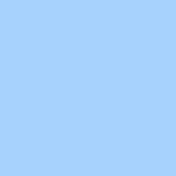

In [121]:
_ = day18b_part2(puzzle.input, visualize=True)

day18b

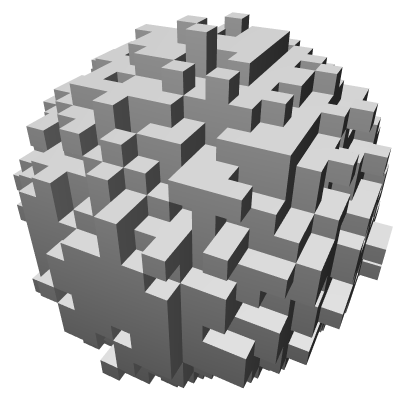

In [122]:
def day18v(s):  # Visualize Part 1 using plotly 3D rendering.
  cubes = np.array([line.split(',') for line in s.splitlines()], int) + 1
  shape = tuple(cubes.max(0) + 2)
  grid = np.full(shape, False)
  grid[tuple(cubes.T)] = True
  dps = np.concatenate([[v, -v] for v in np.eye(grid.ndim, dtype=int)])

  vertices: list[np.ndarray] = []
  faces: list[list[int]] = []
  for p in np.argwhere(grid):
    for dp in dps:
      p2 = tuple(p + dp)
      if not grid[tuple(p2)]:
        pmax = np.maximum(p, p2)
        ((axis,),) = dp.nonzero()
        i0 = len(vertices)
        for d in ((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1)):
          d2 = np.roll(d, axis)
          assert d2[axis] == 0
          vertices.append(pmax + d2)
        step = 1 if p2[axis] > p[axis] else -1
        faces.append([i0, i0 + 1, i0 + 3][::step])
        faces.append([i0, i0 + 3, i0 + 2][::step])

  x, y, z = np.array(vertices).T
  i, j, k = np.array(faces).T
  lighting = dict(ambient=0.15, diffuse=0.80, specular=0.2, roughness=1, fresnel=0)
  shading = dict(flatshading=True, lighting=lighting, lightposition=dict(x=0.55, y=0.55, z=0.50))
  surface = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color=f'rgb{(0.94,) * 3}', **shading)
  fig = go.Figure(data=[surface])

  camera = dict(center=dict(x=-0.03, y=0, z=-0.03), eye=dict(x=0.47, y=-0.99, z=0.74))
  no_axes = dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False))
  scene = dict(aspectratio=dict(x=1, y=1, z=1), camera=camera, **no_axes)
  fig.layout.update(width=400, height=400, margin=dict(l=0, r=0, b=0, t=0), scene=scene)

  if SHOW_BIG_MEDIA and hh.in_notebook():
    hh.display_html('Interactively control the viewpoint by dragging or scrolling:')
    fig.show()

  image = hh.image_from_plotly(fig)
  media.show_image(image, border=True, title='day18b')

  if SHOW_BIG_MEDIA:
    video = hh.wobble_video(fig)
    media.show_video(video, codec='gif', fps=10, title='day18c')

  hh.no_vertical_scroll()


day18v(puzzle.input)

Cached result:<br/>
<img src="results/day18c.gif"/>

(Part 1: 0.002 s)
(Part 2: 0.002 s)


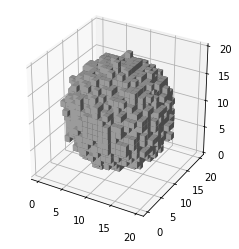

In [123]:
# https://github.com/mjpieters/adventofcode/blob/master/2022/Day%2018.ipynb is super compact,
# but not as fast as the final method.
def day18w(s, *, part2=False, visualize=False):
  # cubes = np.genfromtxt(s.splitlines(), delimiter=',', dtype=int)  # A bit slower.
  cubes = np.array([line.split(',') for line in s.splitlines()], int)
  grid = np.full(cubes.max(0) + 1, False)
  grid[tuple(cubes.T)] = True

  if visualize:
    ax = plt.figure().add_subplot(projection='3d')
    _ = ax.voxels(grid, facecolors='#B0B0B0')  # type: ignore  # attribute of Axes3D
    if hasattr(ax, 'set_box_aspect'):
      # https://stackoverflow.com/a/64453375; aspect for Axes3D is 3-tuple.
      ax.set(box_aspect=grid.shape)  # type: ignore

  if part2:
    grid = scipy.ndimage.binary_fill_holes(grid)

  kernel = [
      [[0, 0, 0], [0, -1, 0], [0, 0, 0]],
      [[0, -1, 0], [-1, 6, -1], [0, -1, 0]],
      [[0, 0, 0], [0, -1, 0], [0, 0, 0]],
  ]
  uncovered = scipy.signal.convolve(grid, kernel, 'same')
  return uncovered[grid].sum()


check_eq(day18w(s1), 64)
puzzle.verify(1, day18w)

day18w_part2 = functools.partial(day18w, part2=True)
check_eq(day18w_part2(s1), 58)
puzzle.verify(2, day18w_part2)

_ = day18w(puzzle.input, visualize=True)

In [124]:
# March along exterior cubes that are vertex-adjacent to the surface; use numba.
@numba.njit
def day18_march_along_exterior(grid, adjacent, start):
  outside = np.full_like(grid, False)
  stack = [start]
  outside[start] = True
  count = 0
  while stack:
    x, y, z = stack.pop()
    for p2 in (
        (x - 1, y, z),
        (x + 1, y, z),
        (x, y - 1, z),
        (x, y + 1, z),
        (x, y, z - 1),
        (x, y, z + 1),
    ):
      if grid[p2]:
        count += 1
      elif not outside[p2] and adjacent[p2]:
        outside[p2] = True
        stack.append(p2)
  return count


def day18(s, *, part2=False):
  # Above, we consider cubes p2 which are 2 away from the cubes, so we must pad by 2.
  cubes = np.array([line.split(',') for line in s.splitlines()], np.int64) + 2
  shape = tuple(cubes.max(0) + 3)
  grid = np.full(shape, False)
  grid[tuple(cubes.T)] = True
  face_adjacent = np.concatenate([[v, -v] for v in np.eye(grid.ndim, dtype=int)])
  neighbors = np.array([np.roll(grid, dp, range(grid.ndim)) for dp in face_adjacent])

  if not part2:
    return (grid & ~neighbors).sum()

  vertex_adjacent = set(itertools.product((-1, 0, 1), repeat=grid.ndim)) - {(0,) * grid.ndim}
  adjacent = np.array([np.roll(grid, dp, range(grid.ndim)) for dp in vertex_adjacent]).any(0)
  start = tuple(cubes[cubes[:, 0].argmin()] - (1, 0, 0))  # Outside, face-adjacent to surface.
  return day18_march_along_exterior(grid, adjacent, start)


check_eq(day18(s1), 64)
puzzle.verify(1, day18)

day18_part2 = functools.partial(day18, part2=True)
check_eq(day18_part2(s1), 58)
puzzle.verify(2, day18_part2)

(Part 1: 0.003 s)
(Part 2: 0.002 s)


<a name="day19"></a>
## Day 19: Making robots make

- Part 1: Determine the quality level of each blueprint using the largest number of geodes it could produce in 24 minutes. What do you get if you add up the quality level of all of the blueprints in your list?

- Part 2: Don't worry about quality levels; instead, just determine the largest number of geodes you could open using each of the first three blueprints. What do you get if you multiply these numbers together?

---

For me this was the most frustrating daily puzzle this year,
because it is tricky to bound the search space without introducing iffy heuristics.
However, it can be done in a principled way, with several optimizations such as constraining
the number of produced robots given the costs of the other dependent robots.

Solutions include:

- `day19a()`: A depth-first search on which robot to build next, with branch-and-bound pruning,
  which guarantees the optimal solution but takes ~850 ms.

- `day19b()`: A breadth-first-search in which the set of active of active states is heuristically pruned.

- `day19()`: Breadth-first search with additional optimization rules and accelerated with `numba`,
  yielding a solution in ~5 ms.

In [125]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2022/day/19), `puzzle.input` has 30 lines:

Blueprint 1: Each ore robot costs 4 ore. Each clay robot costs 4 ore. Each obsid ... e robot costs 3 ore and 7 obsidian.
Blueprint 2: Each ore robot costs 3 ore. Each clay robot costs 3 ore. Each obsid ...  robot costs 2 ore and 20 obsidian.
Blueprint 3: Each ore robot costs 4 ore. Each clay robot costs 3 ore. Each obsid ... e robot costs 2 ore and 9 obsidian.
Blueprint 4: Each ore robot costs 4 ore. Each clay robot costs 3 ore. Each obsid ... e robot costs 3 ore and 9 obsidian.
Blueprint 5: Each ore robot costs 4 ore. Each clay robot costs 4 ore. Each obsid ...  robot costs 2 ore and 18 obsidian.
Blueprint 6: Each ore robot costs 2 ore. Each clay robot costs 4 ore. Each obsid ...  robot costs 4 ore and 12 obsidian.
Blueprint 7: Each ore robot costs 3 ore. Each clay robot costs 3 ore. Each obsid ... e robot costs 2 ore and 8 obsidian.
Blueprint 8: Each ore robot costs 4 ore. Each clay robot costs 3 ore. Each obsid ...  robot costs 3 ore and 10 obsidian.
 ...
Blueprint 27: Each ore robo

The stored answers are: `{1: '2160', 2: '13340'}`

In [126]:
s1 = """\
Blueprint 1: Each ore robot costs 4 ore. Each clay robot costs 2 ore. Each obsidian robot costs 3 ore and 14 clay. Each geode robot costs 2 ore and 7 obsidian.
Blueprint 2: Each ore robot costs 2 ore. Each clay robot costs 3 ore. Each obsidian robot costs 3 ore and 8 clay. Each geode robot costs 3 ore and 12 obsidian.
"""

In [127]:
def day19_parse_recipe(line):
  a = np.full((4, 4), 0)
  fields = [int(t) for t in line.split()[2:] if t.isnumeric()]
  a[0, 0], a[1, 0], a[2, 0], a[2, 1], a[3, 0], a[3, 2] = fields
  return a

In [128]:
# DFS (decision is which robot to build next), with branch-and-bound pruning; guaranteed but not as efficient.
def day19a_process(recipes, part2):
  (r00, _, _, _), (r10, _, _, _), (r20, r21, _, _), (r30, _, r32, _) = recipes
  r_0 = max(r00, r10, r20, r30)
  best_num_geodes = 0

  @functools.lru_cache(maxsize=10**6)  # (The function returns None, but maybe avoid some work.)
  def compute_max_geodes(r0, r1, r2, n0, n1, n2, n3, tl):  # robots, num_resources, time_left
    nonlocal best_num_geodes
    if tl <= 1:  # (Includes case of tl < 0; in the last time step, don't build any robots.)
      return

    if n3 + tl * (tl - 1) // 2 <= best_num_geodes:  # Branch-and-bound pruning.
      return

    def adjust(nn0, nn1, nn2):
      if r0 == r_0:
        nn0 = r_0
      if r1 == r21:
        nn1 = r21
      if r2 == r32:
        nn2 = r32
      # worse lru_caching: nn1 = min(nn1, (r32 - r2) * (r21 - r1))
      # worse lru_caching: nn2 = min(nn2, r32 + (r32 - r2) * tl)
      return nn0, nn1, nn2

    if r2 > 0:  # Build robot 3 (geode).
      dt = 1 + max((r30 - n0 - 1) // r0 + 1, (r32 - n2 - 1) // r2 + 1, 0)
      if dt < tl:
        nn0, nn1, nn2 = adjust(n0 + r0 * dt - r30, n1 + r1 * dt, n2 + r2 * dt - r32)
        nn3 = n3 + (tl - dt)
        best_num_geodes = max(best_num_geodes, nn3)
        compute_max_geodes(r0, r1, r2, nn0, nn1, nn2, nn3, tl - dt)
        if tl == 2:  # Only a geode robot would be useful.
          return
        if n0 >= r30 and n2 >= r32:  # Optional heuristic greedy choice.
          return

    if r1 > 0 and r2 < r32 and n2 + r2 * tl < r32 * tl:  # Build robot 2.
      dt = 1 + max((r20 - n0 - 1) // r0 + 1, (r21 - n1 - 1) // r1 + 1, 0)
      nn0, nn1, nn2 = adjust(n0 + r0 * dt - r20, n1 + r1 * dt - r21, n2 + r2 * dt)
      compute_max_geodes(r0, r1, r2 + 1, nn0, nn1, nn2, n3, tl - dt)

    if r1 < r21 and n1 + r1 * tl < r21 * tl:  # Build robot 1.
      dt = 1 + max((r10 - n0 - 1) // r0 + 1, 0)
      nn0, nn1, nn2 = adjust(n0 + r0 * dt - r10, n1 + r1 * dt, n2 + r2 * dt)
      compute_max_geodes(r0, r1 + 1, r2, nn0, nn1, nn2, n3, tl - dt)

    if r0 < r_0 and n0 + r0 * tl < r_0 * tl:  # Build robot 0.
      dt = 1 + max((r00 - n0 - 1) // r0 + 1, 0)
      nn0, nn1, nn2 = adjust(n0 + r0 * dt - r00, n1 + r1 * dt, n2 + r2 * dt)
      compute_max_geodes(r0 + 1, r1, r2, nn0, nn1, nn2, n3, tl - dt)

  compute_max_geodes(1, 0, 0, 0, 0, 0, 0, 32 if part2 else 24)
  # hh.analyze_functools_caches(locals())  # It reveals a low cache hit rate.
  return best_num_geodes


def day19a(s, *, part2=False):
  lines = s.splitlines()[: 3 if part2 else None]
  bests = []
  for line in lines:
    recipes = day19_parse_recipe(line)
    bests.append(day19a_process(recipes, part2))
  return math.prod(bests) if part2 else sum(i * best for i, best in enumerate(bests, 1))


check_eq(day19a(s1), 33)
# puzzle.verify(1, day19a)  # ~0.6 s.

day19a_part2 = functools.partial(day19a, part2=True)
check_eq(day19a_part2(s1), 56 * 62)
# puzzle.verify(2, day19a_part2)  # ~0.85 s.

In [129]:
# BFS with numba; with few rules and naive heuristic.
# (Prior to using numba, avoiding numpy vectors yielded 10x speedup.)


# @numba.njit  # Commented out to speed up notebook evaluation.
def day19b_process(recipes, part2, prune_size):
  def estimated_goodness(state):
    return state[0] * 1 + state[1] * 2 + state[2] * 5 + state[3] * 20

  (r00, _, _, _), (r10, _, _, _), (r20, r21, _, _), (r30, _, r32, _) = recipes
  r_0 = max(r00, r10, r20, r30)
  states = set()
  states.add((1, 0, 0, 0, 0, 0, 0, 0))  # *num_robots, *num_srcs

  for _ in range(32 if part2 else 24):
    if len(states) > prune_size:
      states = set(sorted(states, key=estimated_goodness)[len(states) // 2 :])
    new_states = set()
    for r0, r1, r2, r3, n0, n1, n2, n3 in states:
      nn0, nn1, nn2, nn3 = n0 + r0, n1 + r1, n2 + r2, n3 + r3
      if n0 >= r30 and n2 >= r32:
        new_states.add((r0, r1, r2, r3 + 1, nn0 - r30, nn1, nn2 - r32, nn3))
        continue  # Heuristic greedy choice.
      if n0 >= r20 and n1 >= r21 and r2 < r32:
        new_states.add((r0, r1, r2 + 1, r3, nn0 - r20, nn1 - r21, nn2, nn3))
      if n0 >= r10 and r1 < r21:
        new_states.add((r0, r1 + 1, r2, r3, nn0 - r10, nn1, nn2, nn3))
      if n0 >= r00 and r0 < r_0:
        new_states.add((r0 + 1, r1, r2, r3, nn0 - r00, nn1, nn2, nn3))
      new_states.add((r0, r1, r2, r3, nn0, nn1, nn2, nn3))
    states = new_states

  best = 0
  for state in states:
    best = max(best, state[7])
  return best


def day19b(s, *, part2=False, prune_size=30_000):
  lines = s.splitlines()[: 3 if part2 else None]
  bests = []
  for line in lines:
    recipes = day19_parse_recipe(line)
    bests.append(day19b_process(recipes, part2, prune_size))
  return math.prod(bests) if part2 else sum(i * best for i, best in enumerate(bests, 1))


check_eq(day19b(s1), 33)  # bests = [9, 12]
# puzzle.verify(1, day19b)  # ~2.2 s.
# bests = [9, 0, 1, 9, 0, 2, 8, 1, 0, 0, 6, 2, 2, 0, 2, 0, 0, 13, 0, 7, 6, 0, 15, 1, 3, 0, 4, 13, 6, 10]

# day19b_part2 = functools.partial(day19b, part2=True)
# check_eq(day19b_part2(s1), 56 * 62)
# puzzle.verify(2, day19b_part2)  # bests = [58, 10, 23]; ~0.5 s.

In [130]:
# Improved BFS; see
# https://www.reddit.com/r/adventofcode/comments/zpy5rm/2022_day_19_what_are_your_insights_and/
# - New rule: "n2 + r2 * tl < r32 * tl"
# - Immediately credit geodes, so do not track geode robots.
# - Improve goodness function.
# - Reduce prune_size.
# - Bound n0,n1,n2 if r0,r1,r2 are at max.
@numba.njit  # ~20x speedup.
def day19_process(recipes, part2, prune_size):
  (r00, _, _, _), (r10, _, _, _), (r20, r21, _, _), (r30, _, r32, _) = recipes
  r_0 = max(r00, r10, r20, r30)
  states = set()
  states.add((1, 0, 0, 0, 0, 0, 0))  # *num_robots[:-1], *num_srcs
  total_time = 32 if part2 else 24

  for time_index in range(total_time):
    tl = total_time - 1 - time_index  # time_left

    def estimated_goodness(state):
      r0, r1, r2, n0, n1, n2, n3 = state
      u0 = min(r0 * tl + n0, r_0 * tl)
      u1 = min(r1 * tl + n1, r21 * tl)
      u2 = min(r2 * tl + n2, r32 * tl)
      return u0 * 1 + u1 * r10 + u2 * (r20 + r21 * r10) + n3 * (r30 + r32 * (r20 + r21 * r10))

    if len(states) > prune_size:
      # non-numba version: states = set(sorted(states, key=estimated_goodness)[len(states) // 2:])
      tmp = []
      for state in states:
        tmp.append((estimated_goodness(state), state))
      tmp = sorted(tmp)[len(states) // 2 :]
      states.clear()
      for _, state in tmp:
        states.add(state)
    new_states = set()
    for r0, r1, r2, n0, n1, n2, n3 in states:
      nn0, nn1, nn2 = n0 + r0, n1 + r1, n2 + r2
      if r0 == r_0:
        nn0 = min(nn0, 2 * r_0)
      if tl == 0:  # In the last time step, don't build any robots.
        new_states.add((r0, r1, r2, nn0, nn1, nn2, n3))
        continue
      if n0 >= r30 and n2 >= r32:
        new_states.add((r0, r1, r2, nn0 - r30, nn1, nn2 - r32, n3 + tl))
        if 0:
          continue  # Optional heuristic greedy choice.
      if tl <= 1:  # In the last time steps, don't build any other robots.
        new_states.add((r0, r1, r2, nn0, nn1, nn2, n3))
        continue
      nn2 = min(nn2, 10**8 * (r32 - r2))
      if n0 >= r20 and n1 >= r21 and r2 < r32 and n2 + r2 * tl < r32 * tl:
        new_states.add((r0, r1, r2 + 1, nn0 - r20, nn1 - r21, nn2, n3))
      nn1 = min(nn1, (r32 - r2) * (r21 - r1))
      if n0 >= r10 and r1 < r21 and n1 + r1 * tl < r21 * tl:
        new_states.add((r0, r1 + 1, r2, nn0 - r10, nn1, nn2, n3))
      if n0 >= r00 and r0 < r_0 and n0 + r0 * tl < r_0 * tl:
        new_states.add((r0 + 1, r1, r2, nn0 - r00, nn1, nn2, n3))
      new_states.add((r0, r1, r2, nn0, nn1, nn2, n3))
    states = new_states

  best = 0
  for state in states:
    best = max(best, state[6])
  return best


def day19(s, *, part2=False, prune_size=30):
  lines = s.splitlines()[: 3 if part2 else None]
  bests = []
  for line in lines:
    recipes = day19_parse_recipe(line)
    bests.append(day19_process(recipes, part2, prune_size))
  return math.prod(bests) if part2 else sum(i * best for i, best in enumerate(bests, 1))


check_eq(day19(s1), 33)
puzzle.verify(1, day19)

day19_part2 = functools.partial(day19, part2=True)
check_eq(day19_part2(s1), 56 * 62)
puzzle.verify(2, day19_part2)

(Part 1: 0.005 s)
(Part 2: 0.004 s)


<a name="day20"></a>
## Day 20: Mixing a circular list

- Part 1: Mix your encrypted file exactly once. What is the sum of the three numbers that form the grove coordinates?

- Part 2: Apply the decryption key and mix your encrypted file ten times. What is the sum of the three numbers that form the grove coordinates?

---

I was stuck for an hour due to not properly handling move offsets equal to or larger than the list size;
that case is not discussed in the problem description.

The following solutions consider four representations:

- `day20a()`: A single Python `list` of `(value, original_index)` tuples.

- `day20b()`: Two `list`s (one for `value` and one for `original index`) &mdash; about a 15x speedup.

- `day20c()`: A 2D `numpy.ndarray` &mdash; another 1.2x speedup.

- `day20()`: A doubly-linked list, implemented using three `ndarray`s and `numba` &mdash; another 6x speedup.

In [131]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2022/day/20), `puzzle.input` has 5_000 lines:

-4241
-7731
-8337
8675
-6125
-4896
8663
-6713
 ...
7541
9048
-7337
-1306


The stored answers are: `{1: '13183', 2: '6676132372578'}`

In [132]:
s1 = """\
1
2
-3
3
-2
0
4
"""

In [133]:
def day20a(s, *, part2=False):  # Slow, using a single list.
  values = list(map(int, s.splitlines()))
  # hh.show(len(a), len(set(a)), min(a), max(a))
  # len(a) = 5000, len(set(a)) = 3603, min(a) = -9993, max(a) = 9998
  values = [value * (811_589_153 if part2 else 1) for value in values]
  a = [(value, i) for i, value in enumerate(values)]
  n = len(a)

  num_mixes = 10 if part2 else 1
  for _ in range(num_mixes):
    for original_index in range(n):
      # (index,) = [i for i, t in enumerate(a) if t[1] == original_index]  # Slowest.
      # (index,) = [i for i, (_, value) in enumerate(a) if value == original_index]  # Slow.
      (index,) = [i for i in range(n) if a[i][1] == original_index]  # Fast.
      value = a[index][0]
      t = a.pop(index)
      index2 = (index + value) % (n - 1)
      a.insert(index2, t)

  (index0,) = [i for i, t in enumerate(a) if t[0] == 0]
  return sum(a[(index0 + offset) % n][0] for offset in [1000, 2000, 3000])


check_eq(day20a(s1), 3)
# puzzle.verify(1, day20a)  # ~0.8 s.

day20a_part2 = functools.partial(day20a, part2=True)
check_eq(day20a_part2(s1), 1623178306)
# puzzle.verify(2, day20a_part2)  # ~8.5 s.

In [134]:
def day20b(s, *, part2=False):  # Faster (15x) using two lists.
  values = list(map(int, s.splitlines()))
  values = [value * (811_589_153 if part2 else 1) for value in values]
  n = len(values)
  indices = list(range(n))

  num_mixes = 10 if part2 else 1
  for _ in range(num_mixes):
    for original_index in range(n):
      index = indices.index(original_index)
      value = values.pop(index)
      _ = indices.pop(index)
      index2 = (index + value) % (n - 1)
      values.insert(index2, value)
      indices.insert(index2, original_index)

  index0 = values.index(0)
  return sum(values[(index0 + offset) % n] for offset in [1000, 2000, 3000])


check_eq(day20b(s1), 3)
puzzle.verify(1, day20b)

day20b_part2 = functools.partial(day20b, part2=True)
check_eq(day20b_part2(s1), 1623178306)
puzzle.verify(2, day20b_part2)

(Part 1: 0.035 s)
(Part 2: 0.531 s)


In [135]:
def day20c(s, *, part2=False):  # Faster, using numpy.
  a = np.array(list(enumerate(map(int, s.splitlines()))), np.int64)
  a[:, 1] *= 811_589_153 if part2 else 1

  for _ in range(10 if part2 else 1):
    for original_index in range(len(a)):
      ((index,),) = np.nonzero(a[:, 0] == original_index)
      i, value = a[index]
      index2 = (index + value) % (len(a) - 1)
      if 0:  # 2.8x slower.
        a = np.insert(np.delete(a, index, axis=0), index2, (i, value), axis=0)
      elif 0:  # 1.7x slower.  (https://stackoverflow.com/a/61877806)
        index, index2, shift = (index, index2, -1) if index < index2 else (index2, index, 1)
        a[index : index2 + 1] = np.roll(a[index : index2 + 1], shift=shift, axis=0)
      elif 0:  # 1.2x slower.
        a[index:-1] = a[index + 1 :]
        a[index2 + 1 :] = a[index2:-1]
        a[index2] = i, value
      else:  # Fastest.
        if index < index2:
          a[index:index2], a[index2] = a[index + 1 : index2 + 1], a[index].copy()
        elif index2 < index:
          a[index2 + 1 : index + 1], a[index2] = a[index2:index], a[index].copy()

  ((index0,),) = np.nonzero(a[:, 1] == 0)
  return sum(a[(index0 + offset) % len(a), 1] for offset in [1000, 2000, 3000])


check_eq(day20c(s1), 3)
puzzle.verify(1, day20c)

day20c_part2 = functools.partial(day20c, part2=True)
check_eq(day20c_part2(s1), 1623178306)
puzzle.verify(2, day20c_part2)

(Part 1: 0.045 s)
(Part 2: 0.422 s)


In [136]:
# Fastest; using numba with doubly-linked list approach adapted from
# https://github.com/shaeberling/euler/blob/master/kotlin/src/com/s13g/aoc/aoc2022/Day20.kt
@numba.njit
def day20_mix(a_value, a_prev, a_next):
  n = len(a_value)
  for i in range(n):  # pylint: disable=consider-using-enumerate
    value, prev_, next_ = a_value[i], a_prev[i], a_next[i]
    offset = value % (n - 1)
    if offset != 0:
      a_prev[next_], a_next[prev_] = prev_, next_  # Disconnect node i.
      prev_ = i
      if offset < n // 2:
        for _ in range(offset):
          prev_ = a_next[prev_]
      else:
        for _ in range(n - offset):
          prev_ = a_prev[prev_]
      next_ = a_next[prev_]
      a_prev[i], a_next[i], a_next[prev_], a_prev[next_] = prev_, next_, i, i  # Reconnect node i.


def day20(s, *, part2=False):
  a_value = np.array(list(map(int, s.splitlines())), np.int64)
  n = len(a_value)
  a_value *= 811_589_153 if part2 else 1
  a_prev = np.array([(i - 1) % n for i in range(n)], np.uint16)
  a_next = np.array([(i + 1) % n for i in range(n)], np.uint16)
  for _ in range(10 if part2 else 1):
    day20_mix(a_value, a_prev, a_next)

  ((i,),) = np.nonzero(a_value == 0)
  values = []
  for _ in range(n):
    values.append(a_value[i])
    i = a_next[i]
  return sum(values[offset % n] for offset in [1000, 2000, 3000])


check_eq(day20(s1), 3)
puzzle.verify(1, day20)

day20_part2 = functools.partial(day20, part2=True)
check_eq(day20_part2(s1), 1623178306)
puzzle.verify(2, day20_part2)

(Part 1: 0.009 s)
(Part 2: 0.067 s)


<a name="day21"></a>
## Day 21: Expression tree

- Part 1: What number will the monkey named root yell?

- Part 2: What number do you yell to pass root's equality test?

---

Initially it was not obvious to me that the input description corresponds to a tree structure
and not a more general dag (directed acyclic graph).

Therefore the first solution involves brute-force repeated traversals of the expressions
to evaluate assignments when possible;
a small improvement was to use `graphlib.TopologicalSorter` to compute an ordering for the
assignments.

For Part 2, the initial approach is a top-down traversal of the "simplified graph" to iteratively assign values
from the `root` node all the way to the unknown `humn` node.

Some [reddit solutions](https://www.reddit.com/r/adventofcode/comments/zrav4h/2022_day_21_solutions/j12p36w/)
demonstrate the elegant use of `sympy`, which I adapt here as well.

With `matplotlib` we can visualize the original and simplified graphs.
For the large (unsimplified) graph of the puzzle input, the visualization greatly benefits from the improved graph layout
algorithms in the `apt` package `graphviz`, which is accessed from `networkx` via `pygraphviz`.

In [137]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2022/day/21), `puzzle.input` has 1_835 lines:

rgfg: 7
dvfr: 2
srjl: 15
lqvd: sqbt * rvzp
rqcs: gpvh * cdfd
vclj: 2
blts: 2
qwhw: 19
 ...
cvgg: 1
jqcr: qnqh * tzhr
ccsb: wrwl * zqpr
nfpw: 1


The stored answers are: `{1: '41857219607906', 2: '3916936880448'}`

In [138]:
s1 = """\
root: pppw + sjmn
dbpl: 5
cczh: sllz + lgvd
zczc: 2
ptdq: humn - dvpt
dvpt: 3
lfqf: 4
humn: 5
ljgn: 2
sjmn: drzm * dbpl
sllz: 4
pppw: cczh / lfqf
lgvd: ljgn * ptdq
drzm: hmdt - zczc
hmdt: 32
"""

In [139]:
def day21a(s, *, part2=False):  # Brute-force assignments.
  fields, assigned = {}, {}
  for line in s.splitlines():
    dst, rest = line.split(': ')
    if rest.isnumeric():
      assigned[dst] = int(rest)
    else:
      fields[dst] = rest.split()  # [dep0, op, dep1]

  if part2:
    del assigned['humn']
    fields['root'][1] = '='

  # Using brute-force search, assign nodes whose children are assigned.
  while True:
    for dst, (dep0, op, dep1) in fields.items():
      if dep0 in assigned and dep1 in assigned:
        a, b = assigned[dep0], assigned[dep1]
        assigned[dst] = (
            a + b if op == '+' else a - b if op == '-' else a * b if op == '*' else a // b
        )  # if op == '/'
        del fields[dst]
        break
    else:
      break

  if not part2:
    return assigned['root']

  # Trace a path from the root down, deriving the value of each unassigned node.
  dst = 'root'
  value: int
  while dst != 'humn':
    dep0, op, dep1 = fields[dst]
    if dep0 in assigned:
      a = assigned[dep0]
      match op:
        case '=':
          value = a
        case '+':
          value -= a
        case '-':
          value = a - value
        case '*':
          value //= a
        case '/':
          value = a // value
        case _:
          raise ValueError(op)
      dst = dep1
    else:
      b = assigned[dep1]
      match op:
        case '=':
          value = b
        case '+':
          value -= b
        case '-':
          value += b
        case '*':
          value //= b
        case '/':
          value *= b
        case _:
          raise ValueError(op)
      dst = dep0

  return value


check_eq(day21a(s1), 152)
puzzle.verify(1, day21a)

day21a_part2 = functools.partial(day21a, part2=True)
check_eq(day21a_part2(s1), 301)
puzzle.verify(2, day21a_part2)

(Part 1: 0.007 s)
(Part 2: 0.007 s)


In [140]:
def day21b(s, *, part2=False, mode='graphlib'):  # Topo-sort or top-down, for single-pass.
  dependencies, ops, assigned = {}, {}, {}
  for line in s.splitlines():
    dst, rest = line.split(': ')
    if rest.isnumeric():
      assigned[dst] = int(rest)
    else:
      field0, op, field1 = rest.split()
      dependencies[dst] = [field0, field1]
      ops[dst] = op

  if part2:
    del assigned['humn']
    ops['root'] = '='

  def consider_node(dst):
    dep = dependencies[dst]
    if dep[0] in assigned and dep[1] in assigned:
      a, b, op = assigned[dep[0]], assigned[dep[1]], ops[dst]
      match op:
        case '+':
          assigned[dst] = a + b
        case '-':
          assigned[dst] = a - b
        case '*':
          assigned[dst] = a * b
        case '/':
          assigned[dst] = a // b
        case _:
          raise ValueError(op)

  # In a single pass, assign nodes whose children are assigned.
  match mode:
    case 'graphlib':  # Using topological sort ordering.
      import graphlib  # pylint: disable=import-error # Python 3.9.

      for dst in graphlib.TopologicalSorter(dependencies).static_order():
        if dst in dependencies:
          consider_node(dst)

    case 'topdown':  # Using DFS ordering (assumes not a dag).

      def assign_node(dst):
        if dst not in assigned and dst in dependencies:
          dep = dependencies[dst]
          assign_node(dep[0])
          assign_node(dep[1])
          consider_node(dst)

      assign_node('root')

    case _:
      raise ValueError(mode)

  if not part2:
    return assigned['root']

  # Trace a path from the root down, deriving the value of each unassigned node.
  dst = 'root'
  value = -1  # Dummy initialization.
  while dst != 'humn':
    dep, op = dependencies[dst], ops[dst]
    if dep[0] in assigned:
      a = assigned[dep[0]]
      match op:
        case '=':
          value = a
        case '+':
          value = value - a
        case '-':
          value = a - value
        case '*':
          value = value // a
        case '/':
          value = a // value
        case _:
          raise ValueError(op)
      dst = dep[1]
    else:
      b = assigned[dep[1]]
      match op:
        case '=':
          value = b
        case '+':
          value = value - b
        case '-':
          value = value + b
        case '*':
          value = value // b
        case '/':
          value = value * b
        case _:
          raise ValueError(op)
      dst = dep[0]

  return value


hh.display_html('graphlib:')
check_eq(day21b(s1), 152)
puzzle.verify(1, day21b)

day21b_part2 = functools.partial(day21b, part2=True)
check_eq(day21b_part2(s1), 301)
puzzle.verify(2, day21b_part2)

hh.display_html('topdown:')
day21c = functools.partial(day21b, mode='topdown')
check_eq(day21c(s1), 152)
puzzle.verify(1, day21c)

day21c_part2 = functools.partial(day21c, part2=True)
check_eq(day21c_part2(s1), 301)
puzzle.verify(2, day21c_part2)

(Part 1: 0.004 s)
(Part 2: 0.004 s)


(Part 1: 0.001 s)
(Part 2: 0.001 s)


In [141]:
# Using sympy; inspired from
# https://www.reddit.com/r/adventofcode/comments/zrav4h/2022_day_21_solutions/j12p36w/
def day21(s, *, part2=False):
  import sympy

  monkeys = dict(line.split(': ') for line in s.splitlines())
  operators = {'+': operator.add, '-': operator.sub, '*': operator.mul, '/': operator.truediv}
  x = sympy.symbols('x')

  def get_value(monkey):
    if part2 and monkey == 'humn':
      return x
    expression = monkeys[monkey]
    if expression.isnumeric():
      return int(expression)
    monkey1, op, monkey2 = expression.split()
    value1, value2 = get_value(monkey1), get_value(monkey2)
    if part2 and monkey == 'root':
      return sympy.solve_linear(value1, value2)[1]
    return operators[op](value1, value2)

  sympy_result = round(get_value('root'))
  return int(sympy_result)


if not importlib.util.find_spec('sympy'):
  print('Module sympy is unavailable.')
else:
  check_eq(day21(s1), 152)
  puzzle.verify(1, day21)

  day21_part2 = functools.partial(day21, part2=True)
  check_eq(day21_part2(s1), 301)
  puzzle.verify(2, day21_part2)

(Part 1: 0.001 s)
(Part 2: 0.007 s)


""

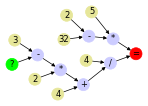

""

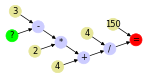

day21a

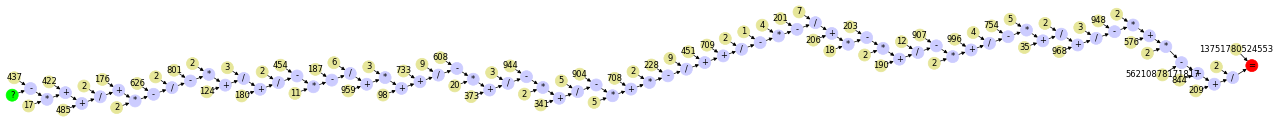

In [142]:
# Visualize graphs.
def day21v(
    s, *, simplify=False, directed=True, prog='dot', figsize=(3, 3), rot=math.tau / 2
) -> np.ndarray:
  assert prog in 'dot neato'.split()  # Possibly also 'sfdp'.
  monkeys = dict(line.split(': ') for line in s.splitlines())
  operators = {'+': operator.add, '-': operator.sub, '*': operator.mul, '/': operator.truediv}

  def recursively_simplify(monkey: str) -> str | int:
    expression = monkeys[monkey]
    if monkey == 'humn':
      return monkey
    if ' ' not in expression:
      return int(expression)
    monkey1, op, monkey2 = expression.split()
    value1, value2 = recursively_simplify(monkey1), recursively_simplify(monkey2)
    if isinstance(value1, str) or isinstance(value2, str):
      return monkey
    value = operators[op](value1, value2)
    if abs(value - round(value)) < 1e-4:
      value = round(value)
    monkeys[monkey] = str(value)
    return value

  if simplify:
    recursively_simplify('root')

  graph = networkx.DiGraph() if directed else networkx.Graph()

  def create_node(monkey: str) -> int:
    expression = monkeys[monkey]
    if ' ' not in expression:
      node = graph.number_of_nodes()
      label = '?' if monkey == 'humn' else expression
      color = hex_color(0.0, 1.0, 0.0) if monkey == 'humn' else hex_color(0.9, 0.9, 0.6)
      graph.add_node(node, label=label, color=color)
      return node
    monkey1, op, monkey2 = expression.split()
    op = '=' if monkey == 'root' else op
    node1, node2 = create_node(monkey1), create_node(monkey2)
    node = graph.number_of_nodes()
    color = hex_color(1.0, 0.0, 0.0) if monkey == 'root' else hex_color(0.8, 0.8, 1.0)
    graph.add_node(node, label=op, color=color)
    graph.add_edge(node1, node)
    graph.add_edge(node2, node)
    return node

  root_node = create_node('root')
  pos = hh.graph_layout(graph, prog=prog)
  if rot is not None:
    pos = hh.rotate_layout_so_node_is_on_left(pos, root_node, rot)

  dpi = 50  # Graph node labels are small yet readable at this resolution.
  fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
  ax.set_aspect('equal')  # Preserve aspect ratio.
  labels = networkx.get_node_attributes(graph, 'label')
  node_color = [attr for _, attr in graph.nodes(data='color')]
  networkx.draw(graph, with_labels=True, labels=labels, node_color=node_color, pos=pos, ax=ax)
  fig.tight_layout(pad=0)
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  plt.close(fig)
  return image


media.show_image(day21v(s1))
media.show_image(day21v(s1, simplify=True))
media.show_image(day21v(puzzle.input, simplify=True, figsize=(30, 15)), border=True, title='day21a')
if SHOW_BIG_MEDIA:
  media.show_image(
      day21v(puzzle.input, prog='neato', figsize=(40, 20), rot=0), border=True, title='day21b'
  )
  _image = day21v(puzzle.input, figsize=(60, 30), rot=None)
  media.show_image(_image, title='day21c', border=True, height=800, downsample=False)
hh.no_vertical_scroll()

Cached result:<br/>
<img src="results/day21b.png"/><br/>
<img src="results/day21c.png"/>

In [143]:
# See also https://github.com/mjpieters/adventofcode/blob/master/2022/Day%2021.ipynb for a
# polished visualization which bypasses `networkx` and directly creates a `graphviz.Digraph`.

<a name="day22"></a>
## Day 22: Cubemap walk

- Part 1: Follow the path given in the monkeys' notes. What is the final password?

- Part 2: Fold the map into a cube, then follow the path given in the monkeys' notes. What is the final password?

---

Representing adjacencies in the 2D cube face unfolding of Part 2 is a tedious task.

Some solution techniques tackle the general problem of supporting any planar unfolding (e.g.,
[here](https://www.reddit.com/r/adventofcode/comments/zsct8w/comment/j18dzaa)
and [here](https://github.com/mjpieters/adventofcode/blob/master/2022/Day%2022.ipynb)).

The approach here is not as ambitious;
it uses hardcoded adjacencies for the example data and the puzzle input.

A visualization animates the traversed path in the planar parameterization.
It is useful to start slow and then increase the speed of traversal by adapting the spacing
of the captured video frames.

In [144]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2022/day/22), `puzzle.input` has 202 lines:

                                                  ..............#....#.......... ... .....................#.............
                                                  ..............#....#.#......#. ... .#...................#......#......
                                                  .......#...................... ... ............#.......#.......##.....
                                                  .........#.................... ... .#.#....#................#.....#..#
                                                  #..........#..............#... ... ....#.............##....#........#.
                                                  ........##.....#..#........#.. ... ..#........##.......#...........#..
                                                  ............#......##....#.... ... ..........................#........
                                                  ..#....#...............#...... ... ..................#....##.#.....#..
 ...
.......#...#....#.........#

The stored answers are: `{1: '89224', 2: '136182'}`

In [145]:
s1 = """\
        ...#
        .#..
        #...
        ....
...#.......#
........#...
..#....#....
..........#.
        ...#....
        .....#..
        .#......
        ......#.

10R5L5R10L4R5L5
"""

In [146]:
def day22_wrap_on_cube(shape, y, x, dy, dx):
  row = {(0, 1): 0, (0, -1): 1, (1, 0): 2, (-1, 0): 3}[dy, dx]
  if shape == (12, 16):  # Example data.
    col = min(y // 4, 2) if dx != 0 else min(x // 4, 3)
    return [
        [(11 - y, 15, 0, -1), (8, 19 - y, 1, 0), (11 - y, 11, 0, -1)],
        [(4, 4 + y, 1, 0), (11, 19 - y, -1, 0), (7, 15 - y, -1, 0)],
        [(11, 11 - x, -1, 0), (15 - x, 8, 0, 1), (7, 11 - x, -1, 0), (19 - x, 0, 0, 1)],
        [(0, 11 - x, 0, -1), (x - 4, 8, 0, 1), (4, 11 - x, 1, 0), (19 - x, 11, 0, -1)],
    ][row][col]

  if shape == (200, 150):  # Puzzle input.
    col = min(y // 50, 3) if dx != 0 else min(x // 50, 2)
    return [
        [(149 - y, 99, 0, -1), (49, 50 + y, -1, 0), (149 - y, 149, 0, -1), (149, y - 100, -1, 0)],
        [(149 - y, 0, 0, 1), (100, y - 50, 1, 0), (149 - y, 50, 0, 1), (0, y - 100, 1, 0)],
        [(0, 100 + x, 1, 0), (100 + x, 49, 0, -1), (x - 50, 99, 0, -1)],
        [(50 + x, 50, 0, 1), (100 + x, 0, 0, 1), (199, x - 100, -1, 0)],
    ][row][col]

In [147]:
def day22(s, *, part2=False, visualize=False, background=(252,) * 3):
  *lines, _, instructions = s.splitlines()
  shape = len(lines), max(len(line) for line in lines)
  grid = np.full(shape, ' ')
  for y, line in enumerate(lines):
    grid[y][: len(line)] = list(line)
  y, x, dy, dx = 0, len(lines[0]) - len(lines[0].lstrip()), 0, 1

  images: list[np.ndarray] = []
  num_steps = 0

  for instruction in re.findall(r'\d+|[LR]', instructions):
    match instruction:
      case 'L':
        dy, dx = -dx, dy
      case 'R':
        dy, dx = dx, -dy
      case _:
        for _ in range(int(instruction)):
          y2, x2, dy2, dx2 = y + dy, x + dx, dy, dx
          if not part2:
            while not (0 <= y2 < shape[0] and 0 <= x2 < shape[1] and grid[y2, x2] != ' '):
              y2, x2 = (y2 + dy) % shape[0], (x2 + dx) % shape[1]
          elif not (0 <= y2 < shape[0] and 0 <= x2 < shape[1] and grid[y2, x2] != ' '):
            y2, x2, dy2, dx2 = day22_wrap_on_cube(shape, y2, x2, dy, dx)  # pytype:disable=attribute-error
          # assert 0 <= y2 < shape[0] and 0 <= x2 < shape[1] and grid[y2, x2] != ' '
          if grid[y2, x2] == '#':
            break
          y, x, dy, dx = y2, x2, dy2, dx2
          grid[y, x] = '@'
          if visualize:
            num_steps += 1
            # Various animation acceleration schedules:
            # if num_steps % 30 == 1:
            # if math.log(num_steps, 1.018) >= len(images):
            if 25 * num_steps**0.33 >= len(images):
              grid2 = np.pad(grid, 4, constant_values=' ')
              cmap = {' ': background, '.': (244,) * 3, '#': (20, 20, 20), '@': (100, 130, 255)}
              image = np.array([cmap[ch] for ch in grid2.flat], np.uint8).reshape(*grid2.shape, 3)
              image = image.repeat(2, axis=0).repeat(2, axis=1)
              text = f'Step {num_steps:5}'
              hh.overlay_text(image, (386, 140), text, fontsize=18, background=background)
              images.append(image)

  if visualize:
    images = [images[0]] * 30 + images + [images[-1]] * 50
    media.show_video(images, codec='gif', fps=50, title='day22')

  return (y + 1) * 1000 + (x + 1) * 4 + [(0, 1), (1, 0), (0, -1), (-1, 0)].index((dy, dx))


check_eq(day22(s1), 6032)
puzzle.verify(1, day22)

day22_part2 = functools.partial(day22, part2=True)
check_eq(day22_part2(s1), 5031)
puzzle.verify(2, day22_part2)

(Part 1: 0.014 s)
(Part 2: 0.011 s)


In [148]:
if SHOW_BIG_MEDIA:
  _ = day22_part2(puzzle.input, visualize=True)

Cached result:<br/>
<img src="results/day22.gif"/>

<a name="day23"></a>
## Day 23: Elves moving in 2D grid

- Part 1: Simulate the Elves' process and find the smallest rectangle that contains the Elves after 10 rounds. How many empty ground tiles does that rectangle contain?

- Part 2: What is the number of the first round where no Elf moves?

---

For this problem it is natural to use either a `set` or a 2D grid (`np.ndarray`).
Unlike in day 18, the approach here uses a `set`;
one small benefit is that there is no need for array resizing as the elf positions expand out.

The fast solution `day21()` encodes the 2D positions as 1D coordinates
and it precomputes the 1D offset for each 2D neighbor.
Interestingly, the choice of the `stride` value used in the 2D encoding has a significant effect on
the performance of the `set` data structure in `numba`;
it could be due to either the hashing efficiency or the memory cache efficiency.
The `numba`-compatible code is disappointingly verbose as it cannot use any comprehensions containing
function calls.

See also the
[solution by Martijn Pieters](https://github.com/mjpieters/adventofcode/blob/master/2022/Day%2023.ipynb)
which demonstrates that all operations can be vectorized within `numpy`.

In [149]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2022/day/23), `puzzle.input` has 71 lines:

.#.##.#...###.#.#.#.#.#....##....#...##...##..#.##..#..#.#.#.###..#....
.....#.#..####.......#.###.....##.#..#.###.#.#..##.#.#.#.#..##.#.######
#.####.##..####.#####.#.##.#..##.#.#.###.######.#.#.##..#####.#.##..##.
#..#.####...#..##...#.#####.######.#...#....##..##..#......##.#####..##
###..#.##..#########...#..####.#.#..##..#.#.#..###..##.###...##.#.#.#..
..#..##.##.###..###.###...#.##..##.#####..#.###.....##...##......##.#..
.###.#..#.#..#..#.##..#...##.#...#...##...##.####....#....#####..####.#
..#####...#..###...#..#.#.#.#..#....#.##.#.#....#.#.#.#.....#.#...###..
 ...
....##....##.###.####...#..#....##.#.#.#...####.##..#...#.......##..#.#
##..##.##.#..##.#...##.....#.##..#.#.##.##.#...#...#.##..#.#.#.#.#.##..
##..##.##...##..##.###..##.##..########..##......#.#..#..###..#####..#.
.#.##..#..##.######.#.#....##.###..#..#.#...#.#....####.#####.#.#..###.


The stored answers are: `{1: '3762', 2: '997'}`

In [150]:
s1 = """\
....#..
..###.#
#...#.#
.#...##
#.###..
##.#.##
.#..#..
"""

In [151]:
if 0:

  def get_grid(current):
    yxs = np.array(list(current))
    grid = np.full(yxs.max(0) - yxs.min(0) + 1, '.')
    grid[tuple(yxs.T)] = '#'
    # print('\n'.join(''.join(list(row)) for row in grid))
    return grid

In [152]:
def day23a(s, *, part2=False, visualize=False, pad=60, background=250):
  grid = np.array([list(line) for line in s.splitlines()])
  current = set((y, x) for y, x in np.argwhere(grid == '#'))
  offsets8 = set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}
  dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
  images: list[np.ndarray] = []

  for round_index in range(10**8 if part2 else 10):
    if visualize and (round_index < 200 or round_index % 10 == 0 or round_index > 750):
      image = np.full(((grid.shape[0] + 2 * pad,) * 2) + (3,), background, np.uint8)
      yxs = np.array(list(current))
      image[tuple((yxs + (pad, pad)).T)] = 0, 0, 180
      image = image[30:, 35:].repeat(2, axis=0).repeat(2, axis=1)
      text = f'Round {round_index:4}'
      hh.overlay_text(image, (3, 0), text, fontsize=20, background=background)
      images.append(image)

    proposed = {}
    for y, x in current:
      if any((y + dy, x + dx) in current for dy, dx in offsets8):
        for dy, dx in dirs:
          neighb3 = [tuple((i if c == 0 else c) for c in (dy, dx)) for i in (-1, 0, 1)]
          if not any((y + dy2, x + dx2) in current for dy2, dx2 in neighb3):
            proposed[y, x] = y + dy, x + dx
            break

    dirs = dirs[1:] + dirs[0:1]
    counter = collections.Counter(proposed.values())
    if part2 and 1 not in counter.values():
      if visualize:
        images = [images[0]] * 60 + images + [images[-1]] * 60
        media.show_video(images, codec='gif', fps=50, title='day23')
      return round_index + 1

    for yx in current.copy():
      if yx in proposed and counter[proposed[yx]] == 1:
        current.remove(yx)
        current.add(proposed[yx])

  return np.prod(np.ptp(list(current), 0) + 1) - len(current)


check_eq(day23a(s1), 110)
puzzle.verify(1, day23a)

day23a_part2 = functools.partial(day23a, part2=True)
check_eq(day23a_part2(s1), 20)
# puzzle.verify(2, day23a_part2)  # ~10.5 s.

(Part 1: 0.146 s)


In [153]:
if SHOW_BIG_MEDIA:  # Slow simulation.
  _ = day23a_part2(puzzle.input, visualize=True)

Cached result:<br/>
<img src="results/day23.gif"/>

In [154]:
# Fast numba version.  2D index (y, x) encoded as 1D index yx.
# Particular choice of stride affects numba hash performance.
# Future: replace `current` by array[elf_index]->yx and array[yx]->occupied.
@numba.njit
def day23_process(grid, part2, stride=570):
  current = set()
  for y, x in np.argwhere(grid):
    current.add(y * stride + x + stride // 4)
  offsets8 = (-stride - 1, -stride, -stride + 1, -1, 1, stride - 1, stride, stride + 1)
  dirs = [-stride, stride, -1, 1]
  neighb3s = [
      (-stride - 1, -stride, -stride + 1),
      (stride - 1, stride, stride + 1),
      (-stride - 1, -1, stride - 1),
      (-stride + 1, 1, stride + 1),
  ]
  elf_proposed = np.full(len(current), 0)

  for round_index in range(10**8 if part2 else 10):
    elf_proposed[:] = 10**8
    all_proposed = set()
    collisions = set()
    for elf_index, yx in enumerate(current):
      has_nearby = False
      for dyx in offsets8:
        if yx + dyx in current:
          has_nearby = True
          break
      if has_nearby:
        for i in range(4):
          possible = True
          for dyx2 in neighb3s[i]:
            if yx + dyx2 in current:
              possible = False
              break
          if possible:
            yx2 = yx + dirs[i]
            if yx2 in all_proposed:
              collisions.add(yx2)
            else:
              elf_proposed[elf_index] = yx2
              all_proposed.add(yx2)
            break

    dirs = dirs[1:] + dirs[0:1]
    neighb3s = neighb3s[1:] + neighb3s[0:1]

    have_moved = False
    future = set()
    for yx, yx2 in zip(current, elf_proposed):
      if yx2 != 10**8 and yx2 not in collisions:
        future.add(yx2)
        have_moved = True
      else:
        future.add(yx)

    current = future
    if part2 and not have_moved:
      return round_index + 1

  xmin, ymin, xmax, ymax = 10**8, 10**8, -(10**8), -(10**8)
  for yx in current:
    y, x = yx // stride, (yx % stride) - stride // 4
    xmin, ymin, xmax, ymax = min(xmin, x), min(ymin, y), max(xmax, x), max(ymax, y)
  return (ymax - ymin + 1) * (xmax - xmin + 1) - len(current)


def day23(s, *, part2=False):
  grid = np.array([list(line) for line in s.splitlines()]) == '#'
  return day23_process(grid, part2)


check_eq(day23(s1), 110)
puzzle.verify(1, day23)

day23_part2 = functools.partial(day23, part2=True)
check_eq(day23_part2(s1), 20)
puzzle.verify(2, day23_part2)

(Part 1: 0.002 s)
(Part 2: 0.133 s)


<a name="day24"></a>
## Day 24: Blizzard basin

- Part 1: What is the fewest number of minutes required to avoid the blizzards and reach the goal?

- Part 2: What is the fewest number of minutes required to reach the goal,
  go back to the start, then reach the goal again?

---

For this problem, a crucial trick is to avoid explicitly displacing the blizzard symbols
and to instead offset the 2D lookups into the original blizzard table using the time value
modulated by the table dimensions.

We explore 3 progressively faster solutions, all involving a breadth-first search:

- `day24a()`: The search stores the graph state nodes `(time, y, x)` in a `deque`.
  The search is accelerated using heuristic pruning based on a maximum path length.

- `day24b()`: At each time step $t$, we traverse the states `(y, x)` stored in a `set`,
  creating a new set of states for the next time step $t+1$.
  Again, the heuristic pruning considers a maximum path length.

- `day24()`: At each time step, we prune the set of search states to the $k$ states with the
  lowest lower-bound estimate of the distance to the destination.
  Optimal solutions are found with $k$ set as low as 50.
  The implementation is jitted using `numba`.

A GIF video visualization shows the superposition of the blizzards moving in all 4 axis directions.
Interestingly, it is possible to focus on each direction in turn and see the contributing motion.

In [155]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2022/day/24), `puzzle.input` has 37 lines:

#.####################################################################################################
#<v>v>v><>^<>^.^vv<>><>>v.>v<.v>>v<<v<.^<>>>v<v^>.^<^>v>^<^v.^>v^>>><v<>v^<v<<^^.vv>.^>v>v<.^v<><v<>>#
#>>v<^<>vvv.>^.v^^>^<<vv>>v.<^<>v^<v^>v^<>>.v.^<<v^.^v^v><<.^vv<^<^v>.vvv<v>.<>>^>.<<<<<<.<^^<v.<>.v<#
#<<<>^^>>>>.v^>v<>^>^^v>v^^v..v^.<<^>^>.>v^^vv.<>>^><<>v.<v<^^<<v^v<.>^>v<>^^<<>v<<^^><vv>vv<<^^...^>#
#>>v><><<<^<.>v^<<v^>v^^<>>v<<>>.<>v><^<^<.^<><^^^vv>><v<v>vv>^>v^>>vv>><<v^<><>^v.vv>^<^<>v<vvvv^v><#
#<^<^>v^^<>>^<.^^>^vv><v<^^^.v^>><v^>v^.>>v^<..>>.v>v<v^^<.v<<^v<<>v.^>><>v<<>.^<<<<<>>>^<><v>><^>>v>#
#>v>^^^v<v^.>^>^>v>>>v>v<v^v^<v>>><<>v..>>vvv<^><<>>^^.>v^<^>>.^v><v<^<.^>>vv<v^<^vv^<<<^><v.>v<^<.v>#
#>v^>>v^<^<<^<v>..<.v^<.<><>v>v^<.><<<<^><<.<><><><.<.^.>^v^><<<vv.<>vvv<v^v.<^<>>>^>v<^v^<><><v>.^><#
 ...
#<vv^^>v>v<^>.<>..>>vv^^v^<vv>^.>^<^><v><^>>>><.^>v^<v^>v^<>.<.>.<<^<v>><v>>vvv<>.v^<>vvvv>v<.>^vv^v>#
#>.<^<<^<>^v.^v^>v^<<>^^>^<.vvvv<^<.v^<>v>><v^^.v^v^<>><.^<v<<>.>v^>

The stored answers are: `{1: '225', 2: '711'}`

In [156]:
s1 = """\
#.######
#>>.<^<#
#.<..<<#
#>v.><>#
#<^v^^>#
######.#
"""

In [157]:
# Solutions: [time1 = 18, time2 = 41, time3 = 54], [time1 = 225, time2 = 463, time3 = 711].

In [158]:
# Single queue; `previous` dict; find shortest path, with heuristic pruning.
def day24a(s, *, part2=False, visualize=False, repeat=3):
  grid0 = np.array([list(line) for line in s.splitlines()])
  grid = grid0[1:-1, 1:-1]  # Remove walls to simplify modulo addressing.
  shape = grid.shape  # (4, 6) or (35, 100)  (lcm = 700 is not much smaller than solution)

  def shortest_path_to_dst(start_time, start_yx, dst_yx):
    previous: dict[tuple[int, int, int], tuple[int, int]] = {}
    queue = collections.deque([(start_time, *start_yx)])
    max_time = start_time + shape[0] + shape[1] + 150  # Heuristic; 113 is min for my puzzle input.
    while queue:
      time, y, x = queue.popleft()
      if (y, x) == dst_yx:
        path = []
        while time > start_time:
          path.append((y, x))
          time, y, x = time - 1, *previous[time, y, x]
        return path[::-1]
      time += 1
      for dy, dx in ((1, 0), (0, 1), (0, 0), (-1, 0), (0, -1)):
        yx2 = y2, x2 = y + dy, x + dx
        if yx2 in (start_yx, dst_yx) or (
            0 <= y2 < shape[0]
            and 0 <= x2 < shape[1]
            and grid[y2, (x2 - time) % shape[1]] != '>'
            and grid[y2, (x2 + time) % shape[1]] != '<'
            and grid[(y2 - time) % shape[0], x2] != 'v'
            and grid[(y2 + time) % shape[0], x2] != '^'
        ):
          remaining_dist = abs(y2 - dst_yx[0]) + abs(x2 - dst_yx[1])
          tyx2 = time, y2, x2
          if time + remaining_dist <= max_time and tyx2 not in previous:  # Heuristic pruning.
            previous[tyx2] = y, x
            queue.append(tyx2)
    raise ValueError(f'No path found at {time=} {start_yx=}.')

  start, final = (-1, 0), (shape[0], shape[1] - 1)
  path1 = shortest_path_to_dst(0, start, final)
  if not part2:
    return len(path1)
  path2 = shortest_path_to_dst(len(path1), final, start)
  path3 = shortest_path_to_dst(len(path1) + len(path2), start, final)

  if visualize:
    path = [start] + path1 + path2 + path3
    images = []
    for time, (y, x) in enumerate(path):
      image = hh.to_image(grid0 == '#', 255, 120)
      rolls = [
          np.roll(grid == '>', time, 1),
          np.roll(grid == '<', -time, 1),
          np.roll(grid == 'v', time, 0),
          np.roll(grid == '^', -time, 0),
      ]
      blizzards = np.array(rolls).transpose(1, 2, 0)[..., None]
      # colors = 1.0 - blizzards * [(0.3, 0, 0), (0, 0.2, 0), (0, 0, 0.3), (0.2, 0, 0.2)]
      colors = 1.0 - blizzards * (0.1, 0.1, 0.1)
      image[1:-1, 1:-1] = colors.prod(2) * 255.999
      image[y + 1, x + 1] = 255, 0, 0
      image = image.repeat(repeat, axis=0).repeat(repeat, axis=1)
      if image.shape[1] > 200:
        yx = repeat, image.shape[1] - repeat
        text = f'Time {time:3}'
        margin = [[3, 1], [2, 2]]
        hh.overlay_text(image, yx, text, fontsize=14, background=255, align='tr', margin=margin)
      images.append(image)
    fps = {4: 5, 35: 50}[grid.shape[0]]
    hold = int(fps * 1.5)
    images = [images[0]] * hold + images + [images[-1]] * hold
    return images

  return len(path1) + len(path2) + len(path3)


check_eq(day24a(s1), 18)
puzzle.verify(1, day24a)

day24a_part2 = functools.partial(day24a, part2=True)
check_eq(day24a_part2(s1), 54)
# puzzle.verify(2, day24a_part2)

(Part 1: 0.400 s)


day24a

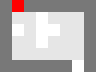

In [159]:
media.show_video(day24a_part2(s1, visualize=True, repeat=12), codec='gif', fps=5, title='day24a')

day24b

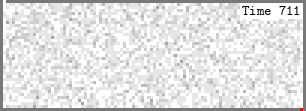

In [160]:
media.show_image(day24a_part2(puzzle.input, visualize=True)[-1], title='day24b')

In [161]:
if SHOW_BIG_MEDIA:
  media.show_video(day24a_part2(puzzle.input, visualize=True), codec='gif', fps=50, title='day24c')

Cached result:<br/>
<img src="results/day24c.gif"/>

In [162]:
# Numba; use `active` set for each time step; use max_time heuristic pruning.
@numba.njit
def day24b_min_time_at_dst(grid, time, start_yx, dst_yx):
  shape = grid.shape
  active = {start_yx}
  max_time = time + shape[0] + shape[1] + 150  # Heuristic; 113 is min for my puzzle input.
  while active:
    time += 1
    new_active = set()
    for y, x in active:
      for dy, dx in ((1, 0), (0, 1), (0, 0), (-1, 0), (0, -1)):
        yx2 = y2, x2 = y + dy, x + dx
        if yx2 == dst_yx:
          return time
        if yx2 == start_yx or (
            0 <= y2 < shape[0]
            and 0 <= x2 < shape[1]
            and grid[y2, (x2 - time) % shape[1]] != '>'
            and grid[y2, (x2 + time) % shape[1]] != '<'
            and grid[(y2 - time) % shape[0], x2] != 'v'
            and grid[(y2 + time) % shape[0], x2] != '^'
        ):
          remaining_dist = abs(y2 - dst_yx[0]) + abs(x2 - dst_yx[1])
          if time + remaining_dist <= max_time:  # Heuristic pruning.
            new_active.add(yx2)
    active = new_active

  raise ValueError('No path found; try increasing max_time.')


def day24b(s, *, part2=False):
  grid = np.array([list(line) for line in s.splitlines()])
  grid = grid[1:-1, 1:-1]  # (4, 6) or (35, 100); lcm=700 is large.
  start, final = (-1, 0), (grid.shape[0], grid.shape[1] - 1)

  time1 = day24b_min_time_at_dst(grid, 0, start, final)
  if not part2:
    return time1
  time2 = day24b_min_time_at_dst(grid, time1, final, start)
  time3 = day24b_min_time_at_dst(grid, time2, start, final)
  return time3


check_eq(day24b(s1), 18)
puzzle.verify(1, day24b)

day24b_part2 = functools.partial(day24b, part2=True)
check_eq(day24b_part2(s1), 54)
puzzle.verify(2, day24b_part2)

(Part 1: 0.044 s)
(Part 2: 0.131 s)


In [163]:
# Numba; use `active` set for each time step; use prune_size.
@numba.njit
def day24_min_time_at_dst(
    grid, time, start_yx, dst_yx, prune_size=50
):  # 30 is min prune_size for my puzzle input.
  shape = grid.shape
  active = {start_yx}

  def lower_bound_dist_to_dst(yx):
    return abs(yx[0] - dst_yx[0]) + abs(yx[1] - dst_yx[1])

  while active:
    time += 1
    new_active = set()
    # Non-numba version: pruned_active = sorted(states, key=lower_bound_dist_to_dst)[:prune_size]
    tmp = []
    for yx in active:
      tmp.append((lower_bound_dist_to_dst(yx), yx))
    tmp = sorted(tmp)[:prune_size]
    for _, (y, x) in tmp:
      for dy, dx in ((1, 0), (0, 1), (0, 0), (-1, 0), (0, -1)):
        yx2 = y2, x2 = y + dy, x + dx
        if yx2 == dst_yx:
          return time
        if yx2 == start_yx or (
            0 <= y2 < shape[0]
            and 0 <= x2 < shape[1]
            and grid[y2, (x2 - time) % shape[1]] != '>'
            and grid[y2, (x2 + time) % shape[1]] != '<'
            and grid[(y2 - time) % shape[0], x2] != 'v'
            and grid[(y2 + time) % shape[0], x2] != '^'
        ):
          new_active.add(yx2)
    active = new_active

  raise ValueError('No path found; try increasing prune_size.')


def day24(s, *, part2=False):
  grid = np.array([list(line) for line in s.splitlines()])
  grid = grid[1:-1, 1:-1]  # (4, 6) or (35, 100); lcm=700 is large.
  start, final = (-1, 0), (grid.shape[0], grid.shape[1] - 1)

  time1 = day24_min_time_at_dst(grid, 0, start, final)
  if not part2:
    return time1
  time2 = day24_min_time_at_dst(grid, time1, final, start)
  time3 = day24_min_time_at_dst(grid, time2, start, final)
  return time3


check_eq(day24(s1), 18)
puzzle.verify(1, day24)

day24_part2 = functools.partial(day24, part2=True)
check_eq(day24_part2(s1), 54)
puzzle.verify(2, day24_part2)

(Part 1: 0.006 s)
(Part 2: 0.017 s)


<a name="day25"></a>
## Day 25: Base-5 SNAFU encoding

- Part 1: What SNAFU number do you supply to Bob's console?

- Part 2: No second part on day 25.

---

A key to simplicity is to derive the operation `divmod(n + 2, 5)`.

Here are several different implementations, using loops, recursion, reductions, and iterators.

The function `day25()` computes the sum of the SNAFU numbers using
[carry arithmetic](https://en.wikipedia.org/wiki/Carry_\(arithmetic\)) entirely in the SNAFU numbering system.

In [164]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2022/day/25), `puzzle.input` has 125 lines:

1100-
11-1=12012=
111==2=-022=01
20---
1=01=20
2=2=2=-21-=
1021-02=10==-
1-22=12001-0=222011
 ...
111=--12=2
1=201
11200-1==2=001=--2
10---10--=0-2202=1


The stored answers are: `{1: '2==0=0===02--210---1', 2: ''}`

In [165]:
s1 = """\
1=-0-2
12111
2=0=
21
2=01
111
20012
112
1=-1=
1-12
12
1=
122
"""

In [166]:
def day25a(s):
  def from_snafu(text):
    n = 0
    power = 1
    for ch in list(reversed(text)):
      digit = {'=': -2, '-': -1, '0': 0, '1': 1, '2': 2}[ch]
      n += power * digit
      power *= 5
    return n

  def to_snafu(n):
    b = []
    while True:
      n, mod = divmod(n + 2, 5)
      ch = '=-012'[mod]
      b.append(ch)
      if n == 0:
        break
    return ''.join(b[::-1])

  total = sum(from_snafu(line) for line in s.splitlines())
  return to_snafu(total)


check_eq(day25a(s1), '2=-1=0')
puzzle.verify(1, day25a)

(Part 1: 0.000 s)


In [167]:
def day25b(s):
  def from_snafu(text):
    n = 0
    for ch in text:
      n = n * 5 + {'=': -2, '-': -1, '0': 0, '1': 1, '2': 2}[ch]
    return n

  def to_snafu(n):
    b = []
    while n != 0:
      n, mod = divmod(n + 2, 5)
      b.append('=-012'[mod])
    return ''.join(['0'] + b[::-1]).lstrip('0')

  total = sum(from_snafu(line) for line in s.splitlines())
  return to_snafu(total)


check_eq(day25b(s1), '2=-1=0')
puzzle.verify(1, day25b)

(Part 1: 0.000 s)


In [168]:
def day25c(s):
  def from_snafu(text):
    return functools.reduce(lambda n, ch: n * 5 + '=-012'.index(ch) - 2, text, 0)

  def to_snafu(n):
    b = []
    while n != 0:
      n, mod = divmod(n + 2, 5)
      b.append('=-012'[mod])
    return ''.join(b[::-1])

  total = sum(from_snafu(line) for line in s.splitlines())
  return to_snafu(total)


check_eq(day25c(s1), '2=-1=0')
puzzle.verify(1, day25c)

(Part 1: 0.000 s)


In [169]:
# https://www.reddit.com/r/adventofcode/comments/zur1an/comment/j1l08w6
def day25d(s):
  def from_snafu(s):
    return from_snafu(s[:-1]) * 5 + '=-012'.find(s[-1]) - 2 if s else 0

  def to_snafu(n):
    return to_snafu((n + 2) // 5) + '=-012'[(n + 2) % 5] if n else ''

  return to_snafu(sum(map(from_snafu, s.splitlines())))


check_eq(day25d(s1), '2=-1=0')
puzzle.verify(1, day25d)

(Part 1: 0.000 s)


In [170]:
def day25e(s):  # Perform addition in the SNAFU algebra.
  carry = 0
  result = ''
  for t in itertools.zip_longest(*(line[::-1] for line in s.splitlines()), '0' * 20, fillvalue='0'):
    carry, mod = divmod(carry + sum('=-012'.index(ch) - 2 for ch in t) + 2, 5)
    result += '=-012'[mod]
  return result.rstrip('0')[::-1]


check_eq(day25e(s1), '2=-1=0')
puzzle.verify(1, day25e)

(Part 1: 0.000 s)


In [171]:
def day25(s):  # Addition in the SNAFU algebra, using only iterators.
  it = itertools.accumulate(
      itertools.zip_longest(*(line[::-1] for line in s.splitlines()), '0' * 20, fillvalue='0'),
      lambda state, t: divmod(state[0] + sum('=-012'.index(ch) - 2 for ch in t) + 2, 5),
      initial=(0, 0),
  )
  return ''.join('=-012'[mod] for _, mod in it)[:0:-1].lstrip('0')


check_eq(day25(s1), '2=-1=0')
puzzle.verify(1, day25)

(Part 1: 0.000 s)


In [172]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)

(Part 2: 0.000 s)


<a name="timings"></a>
## Timings

In [173]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.000
day_2    part_1: 0.000   part_2: 0.000
day_3    part_1: 0.001   part_2: 0.000
day_4    part_1: 0.001   part_2: 0.001
day_5    part_1: 0.000   part_2: 0.000
day_6    part_1: 0.000   part_2: 0.001
day_7    part_1: 0.000   part_2: 0.000
day_8    part_1: 0.001   part_2: 0.001
day_9    part_1: 0.007   part_2: 0.014
day_10   part_1: 0.000   part_2: 0.000
day_11   part_1: 0.000   part_2: 0.035
day_12   part_1: 0.002   part_2: 0.002
day_13   part_1: 0.010   part_2: 0.012
day_14   part_1: 0.006   part_2: 0.016
day_15   part_1: 0.000   part_2: 0.003
day_16   part_1: 0.003   part_2: 0.003
day_17   part_1: 0.003   part_2: 0.009
day_18   part_1: 0.003   part_2: 0.002
day_19   part_1: 0.005   part_2: 0.004
day_20   part_1: 0.009   part_2: 0.067
day_21   part_1: 0.001   part_2: 0.007
day_22   part_1: 0.014   part_2: 0.011
day_23   part_1: 0.002   part_2: 0.133
day_24   part_1: 0.006   part_2: 0.017
day_25   part_1: 0.000   part_2: 0.000
Total time:  0.417 s


In [174]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [175]:
if 1:  # Look for unwanted pollution of namespace.
  for _name in globals().copy():
    if not (re.match(r'^(_.*|(day|Day)\d+.*|s\d+|puzzle)$', _name) or _name in _ORIGINAL_GLOBALS):
      print(_name)

In [176]:
if 0:  # Lint.
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo pyink; pyink --diff .')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo pylint; pylint -j8 . || true')
  hh.run(
      'echo flake8; flake8 --indent-size=2 --exclude .ipynb_checkpoints'
      ' --extend-ignore E129,E203,E302,E305,E501,E741'
  )

In [177]:
hh.show_notebook_cell_top_times()

# Total time: 57.40 s
# In[130] # Improved BFS; see\n# https://www.reddit.com/r/             5.179 s
# In[ 57] # Fast using numba (~30x speedup).\n# We must include the    4.823 s
# In[163] # Numba; use `active` set for each time step; use prune_     3.373 s
# In[ 76] # Fast using numba, but ugly because numba function          3.333 s
# In[ 63] _ = day9b_part2(puzzle.input, visualize=True)                2.707 s
# In[ 54] def day8w(s):  # Use plotly to create 3D visualization.\n    2.569 s
# In[160] media.show_image(day24a_part2(puzzle.input, visualize=True)  2.343 s
# In[154] # Fast numba version.  2D index (y, x) encoded as 1D index   1.838 s
# In[123] # https://github.com/mjpieters/adventofcode/blob/master/202  1.814 s
# In[ 81] def day12w(s, use_tilt=True):  # Visualize using plotly 3D   1.623 s
# In[114] # Faster using numba (10x) and efficient subsequence         1.484 s
# In[ 84] # Fastest, with grid padding, integer heights, successive    1.410 s
# In[162] # Numba; use `active

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->